# **Kaggle – DataTops®**

Tu TA ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Aspectos importantes

- Última submission:
	- Mañana: 17 de febrero a las 5pm
	- Tarde: 19 de febrero a las 5pm
- **Enlace de la competición**: https://www.kaggle.com/t/c5cc87b50c4b4770bdc8f5acbe15577d
- **Requisito**: Estar registrado en [Kaggle](https://www.kaggle.com/)

## Métrica

El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

## Librerías

In [1]:
from PIL import Image

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import urllib.request

from google.colab import drive


# Mount the Google Drive at /content/drive
drive.mount("/content/drive")

# Verify by listing the files in the drive
# !ls /content/drive/My\ Drive/

## Datos

In [44]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
path = "./data"
df = pd.read_csv(f"{path}/train.csv", encoding="utf-8")
df.shape

(912, 13)

### Exploración de los datos

In [3]:
def get_quality(dataframe: pd.DataFrame):
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])
	return data.T

In [4]:
get_quality(df)

Cardinality  Uniqueness  Null
laptop_ID               912.0    1.000000   0.0
Company                  19.0    0.020833   0.0
Product                 480.0    0.526316   0.0
TypeName                  6.0    0.006579   0.0
Inches                   17.0    0.018640   0.0
ScreenResolution         36.0    0.039474   0.0
Cpu                     107.0    0.117325   0.0
Ram                       9.0    0.009868   0.0
Memory                   37.0    0.040570   0.0
Gpu                      93.0    0.101974   0.0
OpSys                     9.0    0.009868   0.0
Weight                  165.0    0.180921   0.0
Price_in_euros          603.0    0.661184   0.0

In [45]:
df.rename(columns={"laptop_ID": "laptop_id"}, inplace=True)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_id         912 non-null    int64  
 1   Company           912 non-null    str    
 2   Product           912 non-null    str    
 3   TypeName          912 non-null    str    
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    str    
 6   Cpu               912 non-null    str    
 7   Ram               912 non-null    str    
 8   Memory            912 non-null    str    
 9   Gpu               912 non-null    str    
 10  OpSys             912 non-null    str    
 11  Weight            912 non-null    str    
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), str(10)
memory usage: 92.8 KB


In [6]:
df.head()

laptop_id Company        Product   TypeName  Inches   ScreenResolution  \
0        755      HP         250 G6   Notebook    15.6  Full HD 1920x1080   
1        618    Dell  Inspiron 7559     Gaming    15.6  Full HD 1920x1080   
2        909      HP    ProBook 450   Notebook    15.6  Full HD 1920x1080   
3          2   Apple    Macbook Air  Ultrabook    13.3           1440x900   
4        286    Dell  Inspiron 3567   Notebook    15.6  Full HD 1920x1080   

                           Cpu   Ram               Memory  \
0     Intel Core i3 6006U 2GHz   8GB            256GB SSD   
1  Intel Core i7 6700HQ 2.6GHz  16GB              1TB HDD   
2   Intel Core i7 7500U 2.7GHz   8GB              1TB HDD   
3         Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
4   Intel Core i3 6006U 2.0GHz   4GB              1TB HDD   

                              Gpu       OpSys  Weight  Price_in_euros  
0           Intel HD Graphics 520  Windows 10  1.86kg          539.00  
1  Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg          879.01  
2            Nvidia GeForce 930MX  Windows 10  2.04kg          900.00  
3          Intel HD Graphics 6000       macOS  1.34kg          898.94  
4              AMD Radeon R5 M430       Linux  2.25kg          428.00

In [7]:
df.tail()

laptop_id Company             Product            TypeName  Inches  \
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                      Gpu       OpSys  Weight  \
907             256GB SSD           AMD Radeon 530  Windows 10   2.2kg   
908             256GB SSD    Intel HD Graphics 520  Windows 10  1.48kg   
909               2TB HDD    Intel HD Graphics 620       No OS   2.2kg   
910             500GB HDD            AMD Radeon R2       No OS  1.86kg   
911  256GB SSD +  1TB HDD  Nvidia GeForce GTX 1060  Windows 10  4.42kg   

     Price_in_euros  
907          800.00  
908         1629.00  
909          519.00  
910          258.00  
911         2456.34

In [8]:
df.describe()

laptop_id      Inches  Price_in_euros
count   912.000000  912.000000      912.000000
mean    650.312500   14.981579     1111.724090
std     382.727748    1.436719      687.959172
min       2.000000   10.100000      174.000000
25%     324.750000   14.000000      589.000000
50%     636.500000   15.600000      978.000000
75%     982.250000   15.600000     1483.942500
max    1320.000000   18.400000     6099.000000

#### Transformaciones

Utilizamos regex para extraer datos de las columnas.

##### `ScreenResolution`

In [46]:
def extract_screen_data(value):
	touchscreen_match = re.search(r"touchscreen", value, re.IGNORECASE)
	panel_match = re.search(r"(ips panel|lcd|oled)", value, re.IGNORECASE)
	type_match = re.search(r"(quad|full|ultra)\s?hd\+?", value, re.IGNORECASE)
	resolution_match = re.search(r"\d{3,4}x\d{3,4}", value, re.IGNORECASE)

	return {
		"has_touchscreen": True if touchscreen_match else False,
		"screen_panel": panel_match.group(0) if panel_match else None,
		"screen_type": type_match.group(0) if type_match else None,
		"screen_resolution": resolution_match.group(0) if resolution_match else None
	}

screen_data = df["ScreenResolution"].apply(extract_screen_data)
df = pd.concat([df, pd.DataFrame(screen_data.tolist())], axis=1)

columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
df.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel screen_type  \
265  IPS Panel Full HD 1920x1080            False    IPS Panel     Full HD   
338                     1366x768            False          NaN         NaN   
729            Full HD 1920x1080            False          NaN     Full HD   
368            Full HD 1920x1080            False          NaN     Full HD   
606                     1366x768            False          NaN         NaN   

    screen_resolution  
265         1920x1080  
338          1366x768  
729         1920x1080  
368         1920x1080  
606          1366x768

Verificamos los valores nulos y los tratamos de completar en los casos en que existan en la columna.

In [47]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

ScreenResolution  has_touchscreen screen_panel  \
0                  Full HD 1920x1080            False          NaN   
1                  Full HD 1920x1080            False          NaN   
2                  Full HD 1920x1080            False          NaN   
3                           1440x900            False          NaN   
4                  Full HD 1920x1080            False          NaN   
..                               ...              ...          ...   
906                Full HD 1920x1080            False          NaN   
907                Full HD 1920x1080            False          NaN   
908  Full HD / Touchscreen 1920x1080             True          NaN   
909                Full HD 1920x1080            False          NaN   
910                         1366x768            False          NaN   

    screen_type screen_resolution  
0       Full HD         1920x1080  
1       Full HD         1920x1080  
2       Full HD         1920x1080  
3           NaN          1440x900  
4       Full HD         1920x1080  
..          ...               ...  
906     Full HD         1920x1080  
907     Full HD         1920x1080  
908     Full HD         1920x1080  
909     Full HD         1920x1080  
910         NaN          1366x768  

[688 rows x 5 columns]

In [48]:
def screen_tier(value):
	width, height = map(int, value.split("x"))
	if width <= 1366:
		return "HD"
	elif width <= 1600:
		return "HD+"
	elif width <= 1920:
		return "Full HD"
	elif width <= 2304:
		return "Full HD+"
	elif width <= 2560:
		return "Quad HD"
	elif width <= 3200:
		return "Quad HD+"
	else:
		return "UHD"

df["screen_type"] = df["screen_resolution"].apply(screen_tier)

Ya que tenemos la resolución de la pantalla y las pulgadas de la diagonal, podemos calcular los **pixel per inch** de la misma.

In [49]:
data = df["screen_resolution"].str.split("x", expand=True).astype(int)
df = pd.concat(
	[
		df,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

df["screen_ppi"] = round(
	((df["screen_width"]**2 + df["screen_height"]**2)**0.5)/df["Inches"],
	2
)

In [50]:
columns.append("screen_ppi")
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

ScreenResolution  has_touchscreen screen_panel  \
0                  Full HD 1920x1080            False          NaN   
1                  Full HD 1920x1080            False          NaN   
2                  Full HD 1920x1080            False          NaN   
3                           1440x900            False          NaN   
4                  Full HD 1920x1080            False          NaN   
..                               ...              ...          ...   
906                Full HD 1920x1080            False          NaN   
907                Full HD 1920x1080            False          NaN   
908  Full HD / Touchscreen 1920x1080             True          NaN   
909                Full HD 1920x1080            False          NaN   
910                         1366x768            False          NaN   

    screen_type screen_resolution  screen_ppi  
0       Full HD         1920x1080      141.21  
1       Full HD         1920x1080      141.21  
2       Full HD         1920x1080      141.21  
3           HD+          1440x900      127.68  
4       Full HD         1920x1080      141.21  
..          ...               ...         ...  
906     Full HD         1920x1080      141.21  
907     Full HD         1920x1080      141.21  
908     Full HD         1920x1080      165.63  
909     Full HD         1920x1080      141.21  
910          HD          1366x768      100.45  

[661 rows x 6 columns]

In [52]:
# mask = df.loc[:, "screen_type"].isna()
# imputations = df.loc[
# 	mask,
# 	["screen_type", "screen_resolution"]
# ]["screen_resolution"].apply(screen_tier)
# data = {"screen_type": imputations, "screen_panel": "unknown"}

df["screen_type"] = df["screen_resolution"].apply(screen_tier)
df.fillna({"screen_panel": "unknown"}, inplace=True)
df.loc[:, columns].sample(10)

ScreenResolution  has_touchscreen screen_panel screen_type  \
455                     1366x768            False      unknown          HD   
438                     1366x768            False      unknown          HD   
4              Full HD 1920x1080            False      unknown     Full HD   
198  IPS Panel Full HD 1920x1080            False    IPS Panel     Full HD   
34             Full HD 1920x1080            False      unknown     Full HD   
226            Full HD 1920x1080            False      unknown     Full HD   
264            Full HD 1920x1080            False      unknown     Full HD   
853                     1366x768            False      unknown          HD   
250  IPS Panel Full HD 1920x1080            False    IPS Panel     Full HD   
736            Full HD 1920x1080            False      unknown     Full HD   

    screen_resolution  screen_ppi  
455          1366x768      100.45  
438          1366x768      100.45  
4           1920x1080      141.21  
198         1920x1080      157.35  
34          1920x1080      157.35  
226         1920x1080      157.35  
264         1920x1080      141.21  
853          1366x768      100.45  
250         1920x1080      141.21  
736         1920x1080      141.21

In [53]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

ScreenResolution: (0, 6)
has_touchscreen: (0, 6)
screen_panel: (0, 6)
screen_type: (0, 6)
screen_resolution: (0, 6)
screen_ppi: (0, 6)


In [54]:
get_quality(df[columns])

Cardinality  Uniqueness  Null
ScreenResolution          36.0    0.039474   0.0
has_touchscreen            2.0    0.002193   0.0
screen_panel               2.0    0.002193   0.0
screen_type                7.0    0.007675   0.0
screen_resolution         14.0    0.015351   0.0
screen_ppi                37.0    0.040570   0.0

In [55]:
df["screen_resolution"] = df["screen_resolution"].astype("category")
df["screen_type"] = df["screen_type"].astype("category")
df["screen_panel"] = df["screen_panel"].astype("category")

In [56]:
df[columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ScreenResolution   912 non-null    str     
 1   has_touchscreen    912 non-null    bool    
 2   screen_panel       912 non-null    category
 3   screen_type        912 non-null    category
 4   screen_resolution  912 non-null    category
 5   screen_ppi         912 non-null    float64 
dtypes: bool(1), category(3), float64(1), str(1)
memory usage: 18.1 KB


##### `CPU`

In [57]:
def extract_cpu_data(value):
	if "samsung" in value.strip().lower():
		# BRAND
		pattern = r"samsung"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=Samsung\s)(Cortex)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match else None

		# SERIES
		pattern = r"(?P<serie>[A-Z]\d{1,2}&[A-Z]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		generation = None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "amd" in value.strip().lower():
		# BRAND
		pattern = r"amd"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=amd\s)(([a-z])(?:\d{0,2})(-series)|ryzen|fx|athlon|threadripper|epyc)"
		is_match = re.search(pattern, value, re.IGNORECASE)

		group1, group2, group3 = is_match.groups()
		is_group1 = group2 is None and group3 is None
		family = group1 if is_group1 else group2 + group3

		# SERIES
		pattern = r"(?P<serie>[ae]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		# MODEL
		pattern = r"(?P<model>\d{4})(?P<feature>[A-Z])?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		model = is_match.group("model") if is_match else None
		feature = is_match.group("feature") if is_match else None

		# GEN
		pattern = r"(\d{1})\d{3}[a-z]?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_model": model,
			"cpu_feature": feature,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "intel" in value.strip().lower():
		# BRAND
		pattern = r"intel"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=intel)\s(?P<family>xeon|atom|core|pentium|celeron)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match.group("family") else None

		# SERIES
		pattern = r"((?:pentium\s|celeron\s)(dual|single|quad))|((?:atom|xeon|core m?|atom)\s?([xeim]\d*))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			serie = is_match.group(4) if is_match.group(4) is not None else is_match.group(2) + " Core"
		else:
			serie = None

		# MODEL
		pattern = r"(?P<feature_1>[A-Z]{0,1})(?<!\.)(?P<model>(\d{3,4}|\d)(Y)?(\d{1,4}))(?P<feature_2>[A-z]{0,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)

		model = is_match.group("model") if is_match else None
		feature = (
			is_match.group("feature_1") or is_match.group("feature_2")
		) if is_match else None

		# GEN
		pattern = r"(\d{1})+\d{3,4}[a-z]*"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None


		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": serie,
			"cpu_model": model,
			"cpu_feature": feature,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

cpu_data = pd.DataFrame(df.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
df = pd.concat([df, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_model",
	"cpu_feature",
	"cpu_gen",
	"cpu_clock",
]
df.sample(5).loc[:, columns]

Cpu cpu_brand cpu_family cpu_series  \
246            Intel Core i7 7500U 2.7GHz     Intel       Core         i7   
263  Intel Celeron Dual Core N3060 1.6GHz     Intel    Celeron  Dual Core   
243            Intel Core i7 8550U 1.8GHz     Intel       Core         i7   
144            Intel Core i7 8550U 1.8GHz     Intel       Core         i7   
619           Intel Core i7 7700HQ 2.8GHz     Intel       Core         i7   

    cpu_model cpu_feature cpu_gen cpu_clock  
246      7500           U       7       2.7  
263      3060           N       3       1.6  
243      8550           U       8       1.8  
144      8550           U       8       1.8  
619      7700          HQ       7       2.8

In [58]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Cpu cpu_brand cpu_family cpu_series cpu_model  \
3          Intel Core i5 1.8GHz     Intel       Core         i5       NaN   
10         Intel Core i5 2.9GHz     Intel       Core         i5       NaN   
48          AMD Ryzen 1700 3GHz       AMD      Ryzen        NaN      1700   
59         Intel Core i5 1.3GHz     Intel       Core         i5       NaN   
66   AMD A9-Series A9-9420 3GHz       AMD   A-Series         A9      9420   
..                          ...       ...        ...        ...       ...   
844   AMD A6-Series 9220 2.5GHz       AMD   A-Series         A6      9220   
862   Intel Core i7 7Y75 1.3GHz     Intel       Core         i7      7Y75   
896     AMD A6-Series 7310 2GHz       AMD   A-Series         A6      7310   
901     AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   
903     AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   

    cpu_feature cpu_gen cpu_clock  
3           NaN     NaN       1.8  
10          NaN     NaN       2.9  
48          NaN       1         3  
59          NaN     NaN       1.3  
66          NaN       9         3  
..          ...     ...       ...  
844         NaN       9       2.5  
862                 NaN       1.3  
896         NaN       7         2  
901         NaN       9         3  
903         NaN       9         3  

[67 rows x 8 columns]

Rellenamos con una etiqueta `unknown` para de la columna generada `cpu_series`, `cpu_model` y `cpu_feature`, la otra variable la eliminaremos luego de nuestro dataset.

In [60]:
df.fillna({
	"cpu_series": "unknown",
	"cpu_model": "unknown",
	"cpu_feature": "unknown",
	"cpu_gen": "unknown"
}, inplace=True).loc[:, columns].sample(10)

Cpu cpu_brand cpu_family cpu_series cpu_model  \
818   Intel Core i5 7200U 2.5GHz     Intel       Core         i5      7200   
766     Intel Core i3 6006U 2GHz     Intel       Core         i3      6006   
264   Intel Core i7 7500U 2.7GHz     Intel       Core         i7      7500   
778   Intel Core i5 7200U 2.5GHz     Intel       Core         i5      7200   
401   Intel Core i7 8550U 1.8GHz     Intel       Core         i7      8550   
550  Intel Core i5 7300HQ 2.5GHz     Intel       Core         i5      7300   
615   AMD A9-Series A9-9420 3GHz       AMD   A-Series         A9      9420   
229   Intel Core i7 7560U 2.4GHz     Intel       Core         i7      7560   
171   Intel Core i3 6006U 2.0GHz     Intel       Core         i3      6006   
13    Intel Core i7 6500U 2.5GHz     Intel       Core         i7      6500   

    cpu_feature cpu_gen cpu_clock  
818           U       7       2.5  
766           U       6         2  
264           U       7       2.7  
778           U       7       2.5  
401           U       8       1.8  
550          HQ       7       2.5  
615     unknown       9         3  
229           U       7       2.4  
171           U       6       2.0  
13            U       6       2.5

In [62]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Cpu: (0, 8)
cpu_brand: (0, 8)
cpu_family: (0, 8)
cpu_series: (0, 8)
cpu_model: (0, 8)
cpu_feature: (18, 8)
cpu_gen: (0, 8)
cpu_clock: (0, 8)


Hay muchas `cpu_feature` que se encuentran en blanco.

In [64]:
df["cpu_feature"].unique()

<StringArray>
['U', 'HQ', 'unknown', 'N', 'Z', 'HK', 'P', '', 'e', 'M', 'Y']
Length: 11, dtype: str

In [ ]:
df.replace({
	"cpu_feature": {"": "unknown"}
}, inplace=True)

cpu_feature
U          550
HQ         177
N           86
unknown     64
Z           10
P           10
HK           9
e            3
M            2
Y            1
Name: count, dtype: int64

In [106]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Cpu: (0, 8)
cpu_brand: (0, 8)
cpu_family: (0, 8)
cpu_series: (0, 8)
cpu_model: (0, 8)
cpu_feature: (0, 8)
cpu_gen: (0, 8)
cpu_clock: (0, 8)


In [ ]:
get_quality(df[columns])

Cardinality  Uniqueness  Null
Cpu                107.0    0.117325   0.0
cpu_brand            2.0    0.002193   0.0
cpu_family           9.0    0.009868   0.0
cpu_series          20.0    0.021930   0.0
cpu_model           63.0    0.069079   0.0
cpu_feature         10.0    0.010965   0.0
cpu_gen              8.0    0.008772   0.0
cpu_clock           27.0    0.029605   0.0

In [108]:
df["cpu_brand"] = df["cpu_brand"].astype("category")
df["cpu_clock"] = df["cpu_clock"].astype(float)
df["cpu_family"] = df["cpu_family"].astype("category")
df["cpu_series"] = df["cpu_series"].astype("category")
df["cpu_model"] = df["cpu_model"].astype("category")
df["cpu_feature"] = df["cpu_feature"].astype("category")
df["cpu_gen"] = df["cpu_gen"].astype("category")

In [110]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Cpu          912 non-null    str     
 1   cpu_brand    912 non-null    category
 2   cpu_family   912 non-null    category
 3   cpu_series   912 non-null    category
 4   cpu_model    912 non-null    category
 5   cpu_feature  912 non-null    category
 6   cpu_gen      912 non-null    category
 7   cpu_clock    912 non-null    float64 
dtypes: category(6), float64(1), str(1)
memory usage: 27.6 KB


##### `RAM`

In [111]:
def extract_ram_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)"

	is_match = re.search(pattern, value, re.IGNORECASE)
	if is_match:
		data[f"ram_size"] = is_match.group("size")
		data[f"ram_capacity"] = is_match.group("capacity")

	return pd.Series(data)


ram_data = df.loc[:, "Ram"].apply(extract_ram_data)
df = pd.concat([df, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
df.sample(5).loc[:, columns]

Ram ram_size ram_capacity
817  16GB       16           GB
212   8GB        8           GB
542   4GB        4           GB
510   8GB        8           GB
559   4GB        4           GB

In [112]:
df["ram_size"] = df["ram_size"].astype(int)
df["ram_capacity"] = df["ram_capacity"].astype("category")

In [117]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Empty DataFrame
Columns: [Ram, ram_size, ram_capacity]
Index: []

In [114]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Ram: (0, 3)
ram_size: (0, 3)
ram_capacity: (0, 3)


In [116]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Ram           912 non-null    str     
 1   ram_size      912 non-null    int64   
 2   ram_capacity  912 non-null    category
dtypes: category(1), int64(1), str(1)
memory usage: 22.4 KB


##### `HDD`

In [119]:
def extract_memory_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)\s(?P<type>hybrid|ssd|hdd|flash\sstorage)"

	memories = value.split("+")
	for index, memory in enumerate(memories, 1):
		is_match = re.search(pattern, memory, re.IGNORECASE)
		if is_match:
			data[f"hdd_size_{index}"] = is_match.group("size")
			data[f"hdd_capacity_{index}"] = is_match.group("capacity")
			data[f"hdd_type_{index}"] = is_match.group("type")

	columns = [
		"hdd_size_1",
		"hdd_capacity_1",
		"hdd_type_1",
		"hdd_size_2",
		"hdd_capacity_2",
		"hdd_type_2"
	]
	return pd.Series(data)

memory_data = df.loc[:, "Memory"].apply(extract_memory_data)
df = pd.concat([df, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
df.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2 hdd_capacity_2  \
761  256GB SSD        256             GB        SSD        NaN            NaN   
835  500GB HDD        500             GB        HDD        NaN            NaN   
560  512GB SSD        512             GB        SSD        NaN            NaN   
380    1TB HDD          1             TB        HDD        NaN            NaN   
269  500GB HDD        500             GB        HDD        NaN            NaN   

    hdd_type_2  
761        NaN  
835        NaN  
560        NaN  
380        NaN  
269        NaN

In [121]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Memory hdd_size_1 hdd_capacity_1     hdd_type_1 hdd_size_2  \
0              256GB SSD        256             GB            SSD        NaN   
1                1TB HDD          1             TB            HDD        NaN   
2                1TB HDD          1             TB            HDD        NaN   
3    128GB Flash Storage        128             GB  Flash Storage        NaN   
4                1TB HDD          1             TB            HDD        NaN   
..                   ...        ...            ...            ...        ...   
906            256GB SSD        256             GB            SSD        NaN   
907            256GB SSD        256             GB            SSD        NaN   
908            256GB SSD        256             GB            SSD        NaN   
909              2TB HDD          2             TB            HDD        NaN   
910            500GB HDD        500             GB            HDD        NaN   

    hdd_capacity_2 hdd_type_2  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
..             ...        ...  
906            NaN        NaN  
907            NaN        NaN  
908            NaN        NaN  
909            NaN        NaN  
910            NaN        NaN  

[768 rows x 7 columns]

In [120]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Memory          912 non-null    str  
 1   hdd_size_1      912 non-null    str  
 2   hdd_capacity_1  912 non-null    str  
 3   hdd_type_1      912 non-null    str  
 4   hdd_size_2      144 non-null    str  
 5   hdd_capacity_2  144 non-null    str  
 6   hdd_type_2      144 non-null    str  
dtypes: str(7)
memory usage: 57.0 KB


In [122]:
df.fillna({
	"hdd_size_2": 0,
	"hdd_capacity_2": "unknown",
	"hdd_type_2": "unknown"
}, inplace=True)

laptop_id Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ...  cpu_gen  \
0               256GB SSD           Intel HD Graphics 520  ...        6   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...        6   
2                 1TB HDD            Nvidia GeForce 930MX  ...        7   
3     128GB Flash Storage          Intel HD Graphics 6000  ...  unknown   
4                 1TB HDD              AMD Radeon R5 M430  ...        6   
..                    ...                             ...  ...      ...   
907             256GB SSD                  AMD Radeon 530  ...        8   
908             256GB SSD           Intel HD Graphics 520  ...        6   
909               2TB HDD           Intel HD Graphics 620  ...        7   
910             500GB HDD                   AMD Radeon R2  ...        9   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...        7   

    cpu_clock  ram_size  ram_capacity hdd_size_1 hdd_capacity_1  \
0         2.0         8            GB        256             GB   
1         2.6        16            GB          1             TB   
2         2.7         8            GB          1             TB   
3         1.8         8            GB        128             GB   
4         2.0         4            GB          1             TB   
..        ...       ...           ...        ...            ...   
907       1.6         8            GB        256             GB   
908       2.4         8            GB        256             GB   
909       2.5         8            GB          2             TB   
910       1.5         4            GB        500             GB   
911       2.8        16            GB        256             GB   

        hdd_type_1  hdd_size_2  hdd_capacity_2  hdd_type_2  
0              SSD           0         unknown     unknown  
1              HDD           0         unknown     unknown  
2              HDD           0         unknown     unknown  
3    Flash Storage           0         unknown     unknown  
4              HDD           0         unknown     unknown  
..             ...         ...             ...         ...  
907            SSD           0         unknown     unknown  
908      

In [126]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Empty DataFrame
Columns: [Memory, hdd_size_1, hdd_capacity_1, hdd_type_1, hdd_size_2, hdd_capacity_2, hdd_type_2]
Index: []

In [128]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Memory: (0, 7)
hdd_size_1: (0, 7)
hdd_capacity_1: (0, 7)
hdd_type_1: (0, 7)
hdd_size_2: (0, 7)
hdd_capacity_2: (0, 7)
hdd_type_2: (0, 7)


In [125]:
df["hdd_size_1"] = df["hdd_size_1"].str.replace("1.0", "1")
df["hdd_size_1"] = df["hdd_size_1"].astype(int)
df["hdd_capacity_1"] = df["hdd_capacity_1"].astype("category")
df["hdd_type_1"] = df["hdd_type_1"].astype("category")

df["hdd_size_2"] = df["hdd_size_2"].astype(int)
df["hdd_capacity_2"] = df["hdd_capacity_2"].astype("category")
df["hdd_type_2"] = df["hdd_type_2"].astype("category")

In [129]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Memory          912 non-null    str     
 1   hdd_size_1      912 non-null    int64   
 2   hdd_capacity_1  912 non-null    category
 3   hdd_type_1      912 non-null    category
 4   hdd_size_2      912 non-null    int64   
 5   hdd_capacity_2  912 non-null    category
 6   hdd_type_2      912 non-null    category
dtypes: category(4), int64(2), str(1)
memory usage: 32.6 KB


##### `GPU`

In [130]:
def extract_gpu_data(value):
	data = {}
	if "intel" in value.lower():
		pattern = r"(?P<brand>intel) (?P<family>(hd|iris(\splus|\spro)?|uhd)(?:\sgraphics)?)(?:\s)?(?P<model>\d+[a-z]?)?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip() if is_match.group("model") else None

	if "amd" in value.lower():
		pattern = r"(?P<brand>amd) (?P<family>(radeon\s?(rx|r\d|pro)?|firepro|r[\d\w])\s?(graphics)?)(?P<model>[a-z]?\d{0,4}[a-z]?)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	if "nvidia" in value.lower():
		pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	return pd.Series(data, name="gpu")


columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = df["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
df = pd.concat([df, data], axis=1)

columns.insert(0, "Gpu")
df.sample(5).loc[:, columns]

Gpu gpu_brand   gpu_family gpu_model
297    Intel HD Graphics 620     Intel  HD Graphics       620
15     Intel HD Graphics 405     Intel  HD Graphics       405
731     Nvidia GeForce 940MX    Nvidia      GeForce     940MX
871    Intel HD Graphics 520     Intel  HD Graphics       520
392  Nvidia GeForce GTX 1070    Nvidia  GeForce GTX      1070

In [131]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Gpu gpu_brand         gpu_family gpu_model
23           Intel HD Graphics     Intel        HD Graphics       NaN
58           Intel HD Graphics     Intel        HD Graphics       NaN
62           Intel HD Graphics     Intel        HD Graphics       NaN
85           Intel HD Graphics     Intel        HD Graphics       NaN
104          Intel HD Graphics     Intel        HD Graphics       NaN
110          Intel HD Graphics     Intel        HD Graphics       NaN
178         Intel Graphics 620       NaN                NaN       NaN
183          Intel HD Graphics     Intel        HD Graphics       NaN
202          Intel HD Graphics     Intel        HD Graphics       NaN
236          Intel HD Graphics     Intel        HD Graphics       NaN
305          Intel HD Graphics     Intel        HD Graphics       NaN
331          Intel HD Graphics     Intel        HD Graphics       NaN
357          Intel HD Graphics     Intel        HD Graphics       NaN
361          Intel HD Graphics     Intel        HD Graphics       NaN
387          Intel HD Graphics     Intel        HD Graphics       NaN
473    Intel Iris Pro Graphics     Intel  Iris Pro Graphics       NaN
479          Intel HD Graphics     Intel        HD Graphics       NaN
516          Intel HD Graphics     Intel        HD Graphics       NaN
522          Intel HD Graphics     Intel        HD Graphics       NaN
559          Intel HD Graphics     Intel        HD Graphics       NaN
587  Nvidia GeForce GTX1050 Ti       NaN                NaN       NaN
596          Intel HD Graphics     Intel        HD Graphics       NaN
601          Intel HD Graphics     Intel        HD Graphics       NaN
603          Intel HD Graphics     Intel        HD Graphics       NaN
609          Intel HD Graphics     Intel        HD Graphics       NaN
632          Intel HD Graphics     Intel        HD Graphics       NaN
864          Intel HD Graphics     Intel        HD Graphics       NaN
880          Intel HD Graphics     Intel        HD Graphics       NaN

Las **regex** no lograron capturar los datos correctamente en la Nvidia por como se encuentra escrita. Editando el nombre se resuelve facilmente. Respecto a las otras, lo rellenamos con la moda, pero en el caso de `gpu_model`, con una etiqueta de `unknown`.

In [132]:
df.loc[587, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, df.loc[587, "Gpu"], re.IGNORECASE)
if is_match:
	df.loc[587, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	df.loc[587, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	df.loc[587, "gpu_model"] = is_match.group("model").strip()

df["gpu_family"] = df["gpu_family"].str.replace("Graphics", "")

In [ ]:
df.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_id Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... ram_capacity  \
0               256GB SSD           Intel HD Graphics 520  ...           GB   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...           GB   
2                 1TB HDD            Nvidia GeForce 930MX  ...           GB   
3     128GB Flash Storage          Intel HD Graphics 6000  ...           GB   
4                 1TB HDD              AMD Radeon R5 M430  ...           GB   
..                    ...                             ...  ...          ...   
907             256GB SSD                  AMD Radeon 530  ...           GB   
908             256GB SSD           Intel HD Graphics 520  ...           GB   
909               2TB HDD           Intel HD Graphics 620  ...           GB   
910             500GB HDD                   AMD Radeon R2  ...           GB   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...           GB   

    hdd_size_1  hdd_capacity_1     hdd_type_1 hdd_size_2 hdd_capacity_2  \
0          256              GB            SSD          0        unknown   
1            1              TB            HDD          0        unknown   
2            1              TB            HDD          0        unknown   
3          128              GB  Flash Storage          0        unknown   
4            1              TB            HDD          0        unknown   
..         ...             ...            ...        ...            ...   
907        256              GB            SSD          0        unknown   
908        256              GB            SSD          0        unknown   
909          2              TB            HDD          0        unknown   
910        500              GB            HDD          0        unknown   
911        256              GB            SSD          1             TB   

    hdd_type_2  gpu_brand   gpu_family  gpu_model  
0      unknown      Intel          HD         520  
1      unknown     Nvidia  GeForce GTX        960  
2      unknown     Nvidia      GeForce      930MX  
3      unknown      Intel          HD        6000  
4      unknown        AMD    Radeon R5       M430  
..         ...        ...          ...   

In [134]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Gpu: (0, 4)
gpu_brand: (0, 4)
gpu_family: (0, 4)
gpu_model: (21, 4)


In [135]:
df.replace({
	"gpu_model": {"": "unknown"}
}, inplace=True)

laptop_id Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... ram_capacity  \
0               256GB SSD           Intel HD Graphics 520  ...           GB   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...           GB   
2                 1TB HDD            Nvidia GeForce 930MX  ...           GB   
3     128GB Flash Storage          Intel HD Graphics 6000  ...           GB   
4                 1TB HDD              AMD Radeon R5 M430  ...           GB   
..                    ...                             ...  ...          ...   
907             256GB SSD                  AMD Radeon 530  ...           GB   
908             256GB SSD           Intel HD Graphics 520  ...           GB   
909               2TB HDD           Intel HD Graphics 620  ...           GB   
910             500GB HDD                   AMD Radeon R2  ...           GB   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...           GB   

    hdd_size_1  hdd_capacity_1     hdd_type_1 hdd_size_2 hdd_capacity_2  \
0          256              GB            SSD          0        unknown   
1            1              TB            HDD          0        unknown   
2            1              TB            HDD          0        unknown   
3          128              GB  Flash Storage          0        unknown   
4            1              TB            HDD          0        unknown   
..         ...             ...            ...        ...            ...   
907        256              GB            SSD          0        unknown   
908        256              GB            SSD          0        unknown   
909          2              TB            HDD          0        unknown   
910        500              GB            HDD          0        unknown   
911        256              GB            SSD          1             TB   

    hdd_type_2  gpu_brand   gpu_family  gpu_model  
0      unknown      Intel          HD         520  
1      unknown     Nvidia  GeForce GTX        960  
2      unknown     Nvidia      GeForce      930MX  
3      unknown      Intel          HD        6000  
4      unknown        AMD    Radeon R5       M430  
..         ...        ...          ...   

In [137]:
mask = df.loc[:, columns].isna().any(axis=1)
df.loc[mask, columns]

Empty DataFrame
Columns: [Gpu, gpu_brand, gpu_family, gpu_model]
Index: []

In [138]:
for column in columns:
	mask = df[column] == ""
	print(f"{column}:", df.loc[mask, columns].shape)

Gpu: (0, 4)
gpu_brand: (0, 4)
gpu_family: (0, 4)
gpu_model: (0, 4)


In [139]:
df["gpu_brand"] = df["gpu_brand"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")
df["gpu_model"] = df["gpu_model"].astype("category")

In [140]:
df[columns].info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gpu         912 non-null    str     
 1   gpu_brand   912 non-null    category
 2   gpu_family  912 non-null    category
 3   gpu_model   912 non-null    category
dtypes: category(3), str(1)
memory usage: 50.0 KB


#### Limpieza

In [141]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
df.drop(columns=to_delete, inplace=True)

In [142]:
df["Company"] = df["Company"].astype("category")
df["TypeName"] = df["TypeName"].astype("category")
df["Inches"] = df["Inches"].astype(float)
df["Weight"] = df["Weight"].apply(lambda x: x.replace("kg", ""))
df["Weight"] = df["Weight"].astype(float)
# df["OpSys"] = df["OpSys"].astype("category")

In [143]:
df.info()

<class 'pandas.DataFrame'>
Index: 912 entries, 0 to 911
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   laptop_id          912 non-null    int64   
 1   Company            912 non-null    category
 2   Product            912 non-null    str     
 3   TypeName           912 non-null    category
 4   Inches             912 non-null    float64 
 5   OpSys              912 non-null    str     
 6   Weight             912 non-null    float64 
 7   Price_in_euros     912 non-null    float64 
 8   has_touchscreen    912 non-null    bool    
 9   screen_panel       912 non-null    category
 10  screen_type        912 non-null    category
 11  screen_resolution  912 non-null    category
 12  screen_width       912 non-null    int64   
 13  screen_height      912 non-null    int64   
 14  screen_ppi         912 non-null    float64 
 15  cpu_brand          912 non-null    category
 16  cpu_family         912 n

#### Análisis Univariante

Antes de hacer un split entre los datos, análizamos brevemente las caracteristicas que hemos recopilado para darnos idea de realizar alguna transformación adicional a los datos que pueda ser relevante.

In [144]:
from matplotlib import ticker



def plot_category(serie: pd.Series):
	fig, axs = plt.subplots(nrows=1,
							ncols=2,
							figsize=(10, 4),
							layout="constrained")
	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}

	fig.suptitle(f"{serie.name}".upper(),
				 color="#C5BFFD",
				 fontproperties=font_config,
				 y=1.10)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[0].set_title("Cantidad absoluta",
					color="#C5BFFD",
					fontdict=font_config)


	data = serie.value_counts()
	axs[0].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#60A5FA",
			   zorder=2)

	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[0].tick_params(axis="y", width=0)
	axs[0].set_xticks(ticks=data.index)
	#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

	axs[0].set_ylabel("Cantidad",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[0].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)
	axs[0].spines[["left", "top", "right"]].set_visible(False)
	axs[0].spines["bottom"].set_linewidth(1)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[1].set_title("Cantidad relativa",
					 color="#C5BFFD",
					 fontdict=font_config)


	data = serie.value_counts(normalize=True)
	axs[1].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#FFBD54",
			   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[1].set_xticks(ticks=data.index)
	#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

	axs[1].set_ylabel("Cant. según total",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[1].tick_params(axis="y", width=0)
	axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

	axs[1].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)

	axs[1].spines[["left", "top", "right"]].set_visible(False)
	axs[1].spines["bottom"].set_linewidth(1)

	fig.get_layout_engine().set(wspace=0.15)
	plt.show()

##### **`Company`**

In [145]:
companies = len(df["Company"].unique())
print(f"Contamos con { companies } fabricantes de notebooks")

Contamos con 19 fabricantes de notebooks


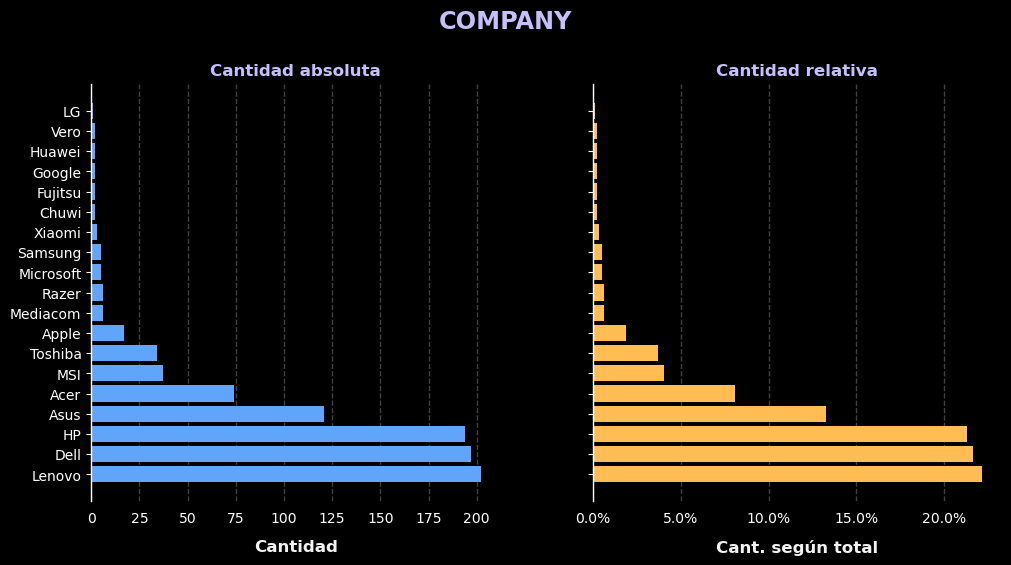

In [146]:
serie = df["Company"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`TypeName`**

In [147]:
notebook_types = df["TypeName"].unique()
print(f"Contamos con {len(notebook_types)} tipos de notebooks")

Contamos con 6 tipos de notebooks


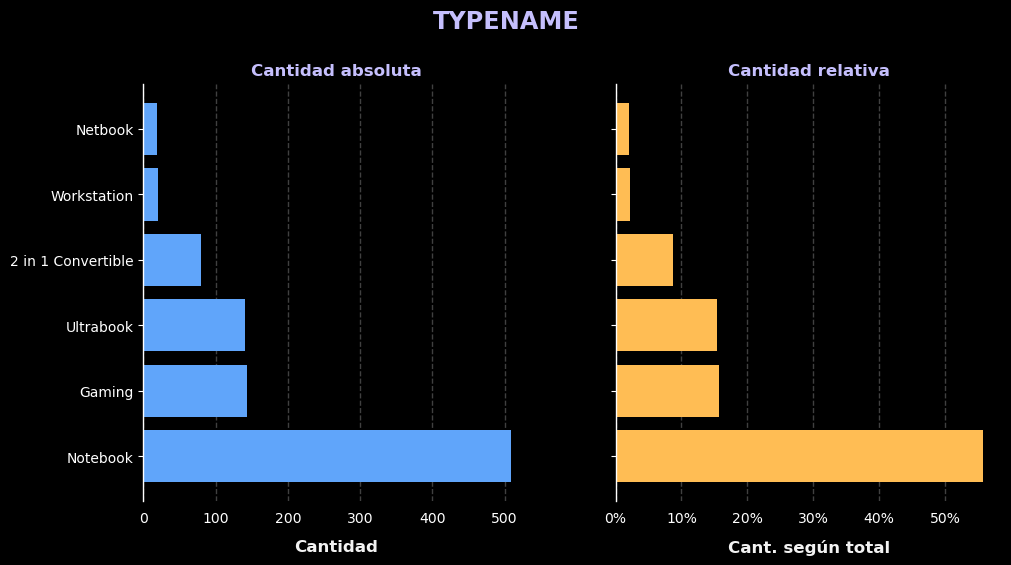

In [148]:
serie = df["TypeName"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`Inches`**

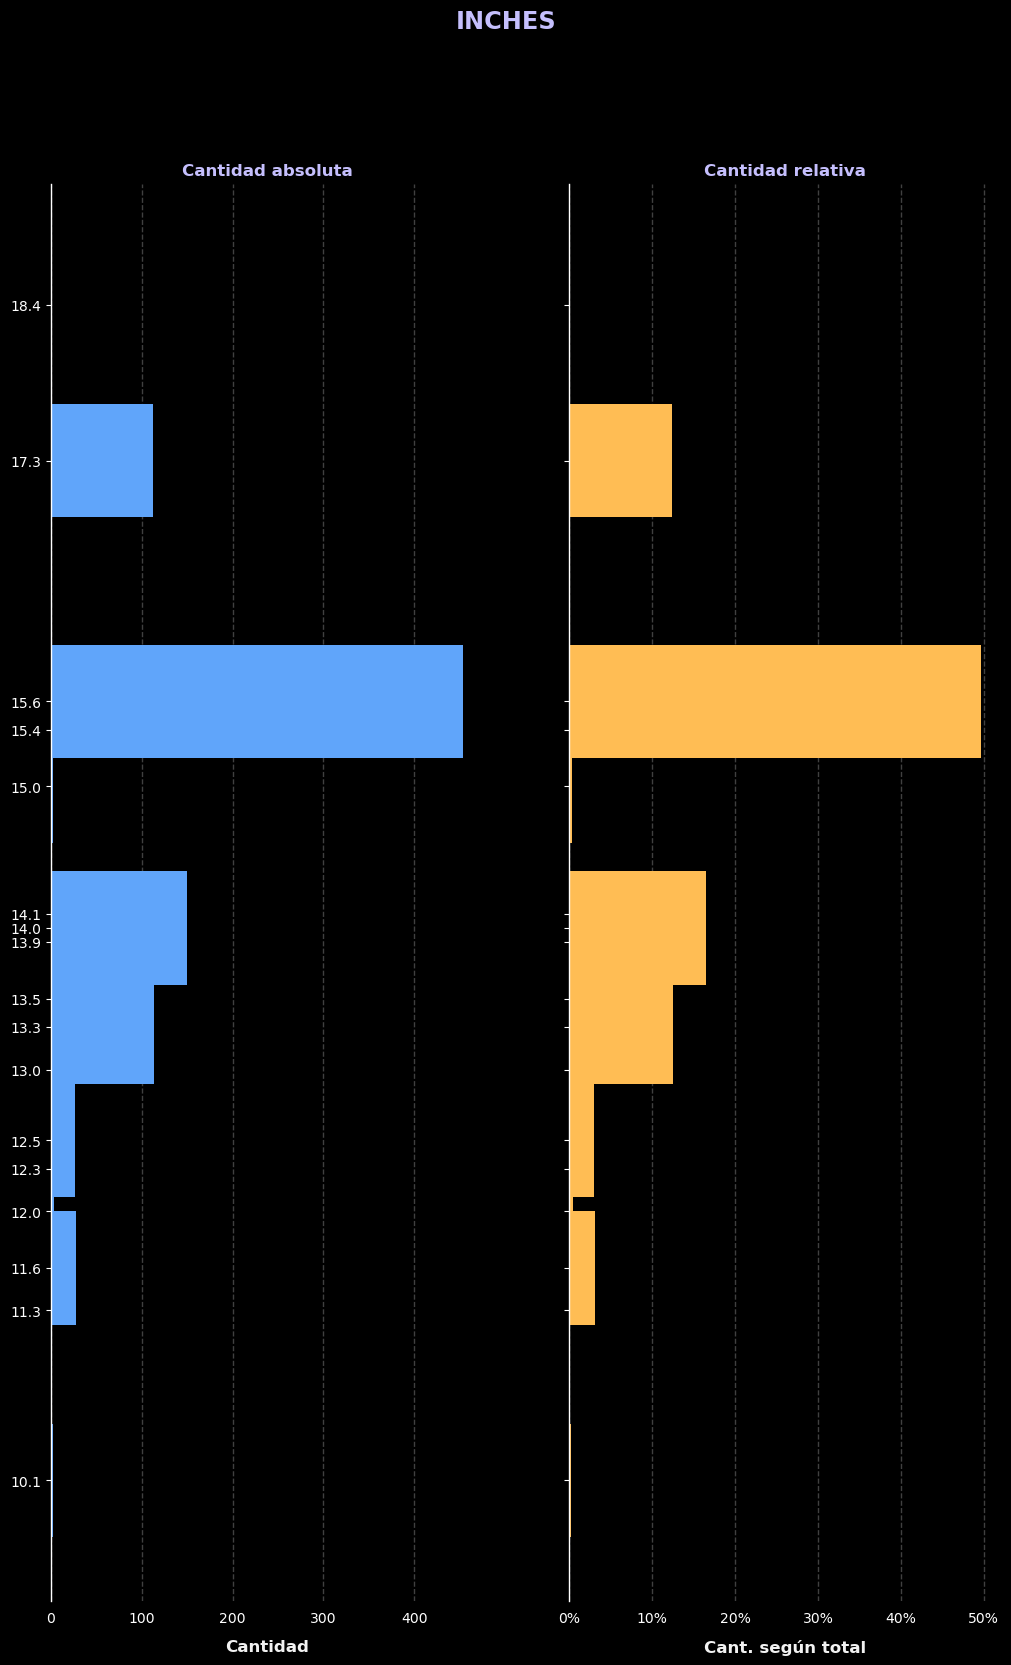

In [149]:
serie = df["Inches"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 15),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`OpSys`**

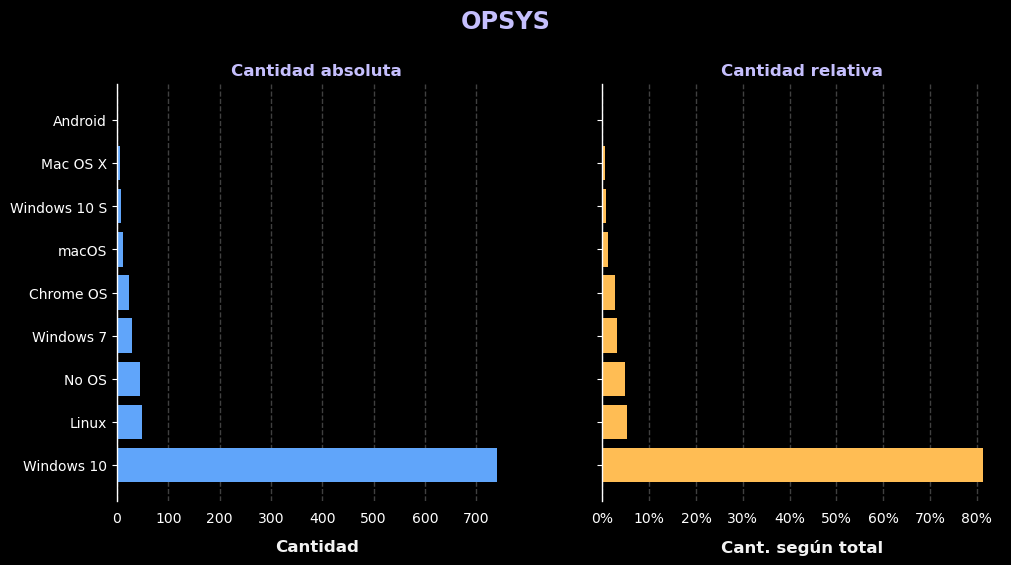

In [150]:
serie = df["OpSys"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

Tenemos distintas versiones de sistemas operativos. Tal vez, sería mejor agruparlos por proveedor y no por versión del mismo.

##### **`Weight`**

In [151]:
def filter_outliers(serie: pd.Series,
					whisker: float | None=1.75,
					below_zero=False):
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	filtered = serie[mask]
	return filtered

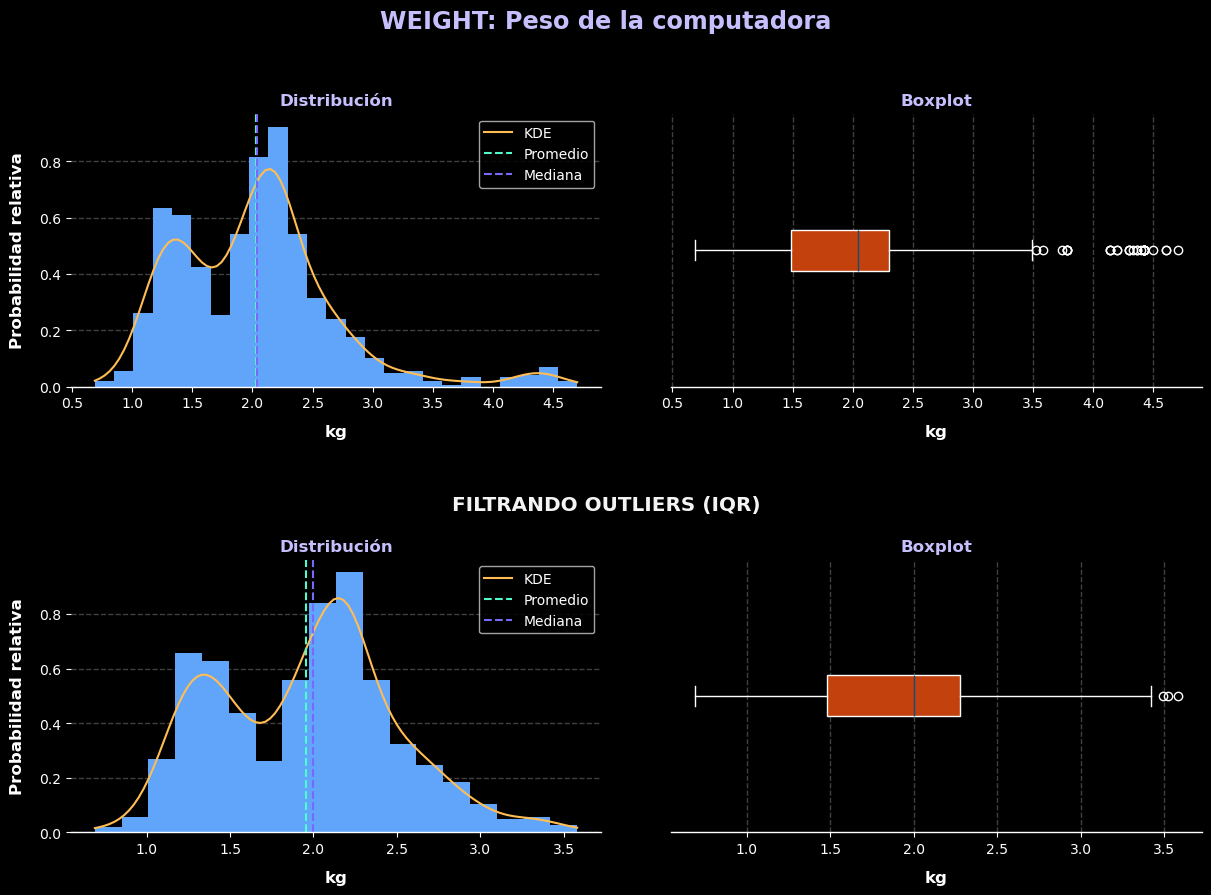

In [152]:
serie = df["Weight"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Peso de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`Price`**

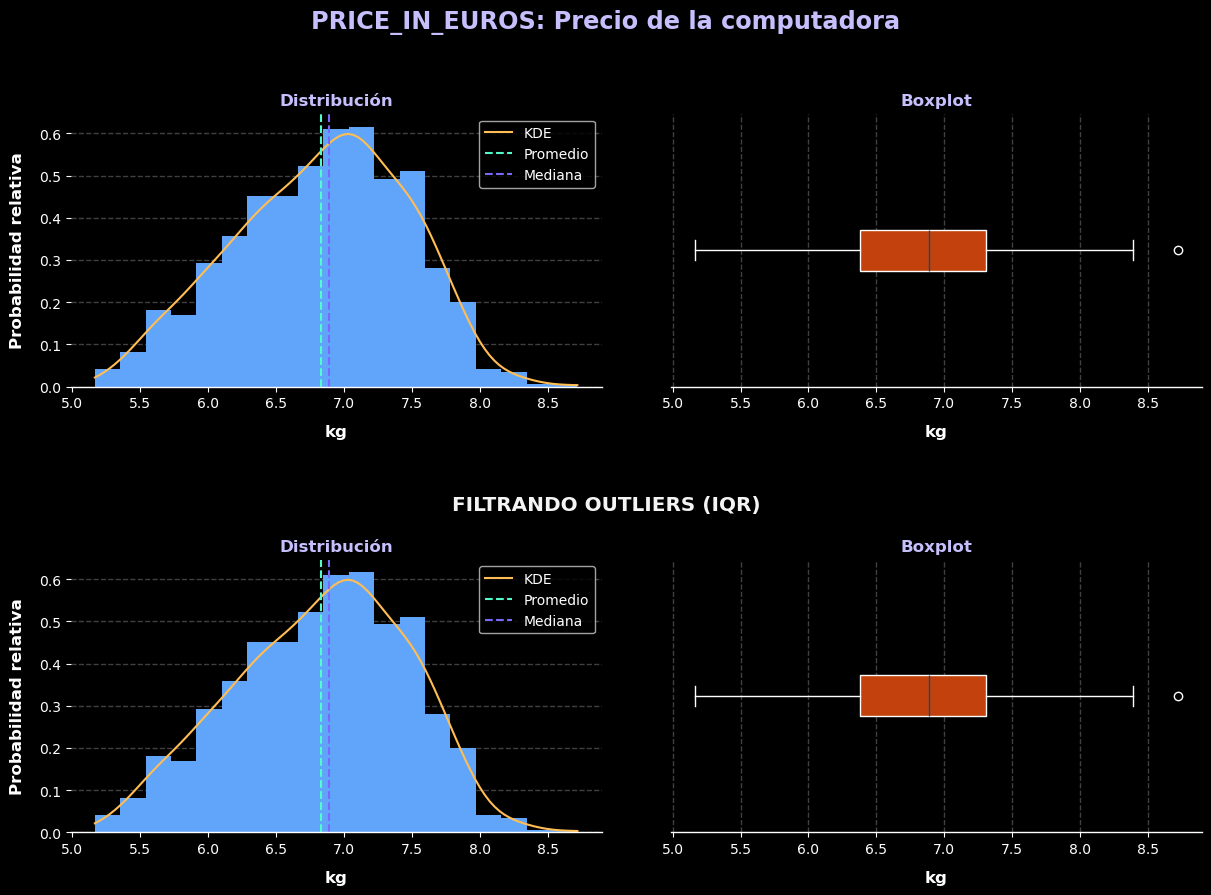

In [153]:
serie = np.log1p(df["Price_in_euros"])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Precio de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

La distribución tiene una larga cola hacía la derecha

##### **`Screen`**

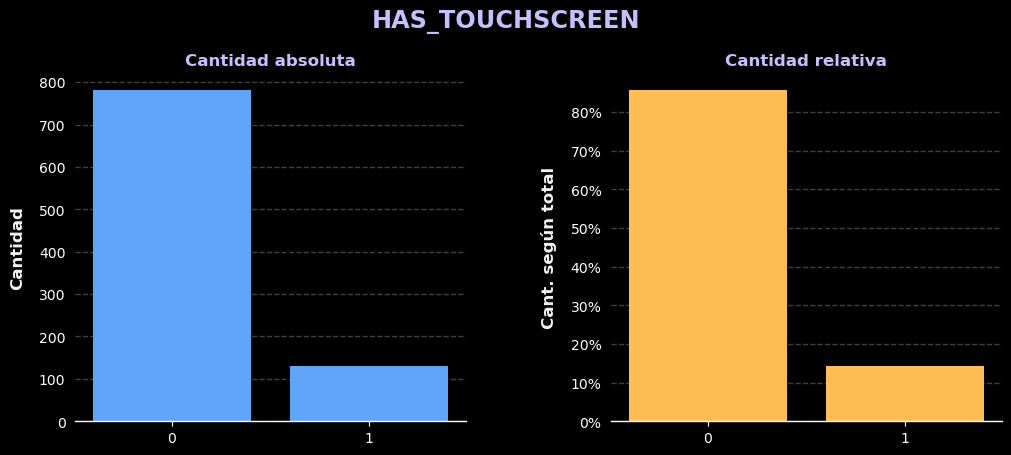

In [154]:
plot_category(df["has_touchscreen"])

In [155]:
screen_types = df["screen_type"].unique()
print(f"Contamos con {len(screen_types)} TIERs según la resolución de pantallas")

Contamos con 7 TIERs según la resolución de pantallas


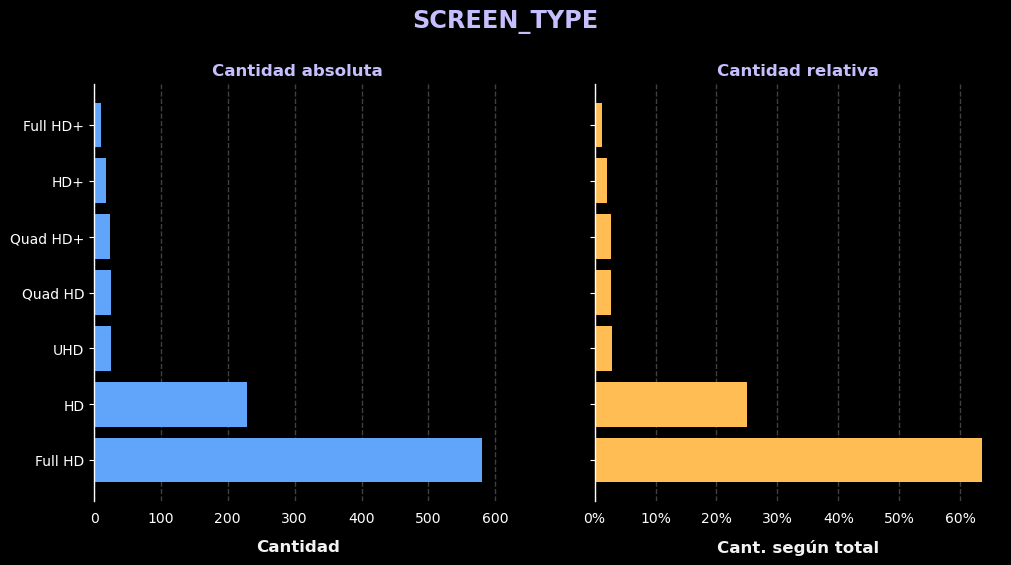

In [156]:
serie = df["screen_type"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

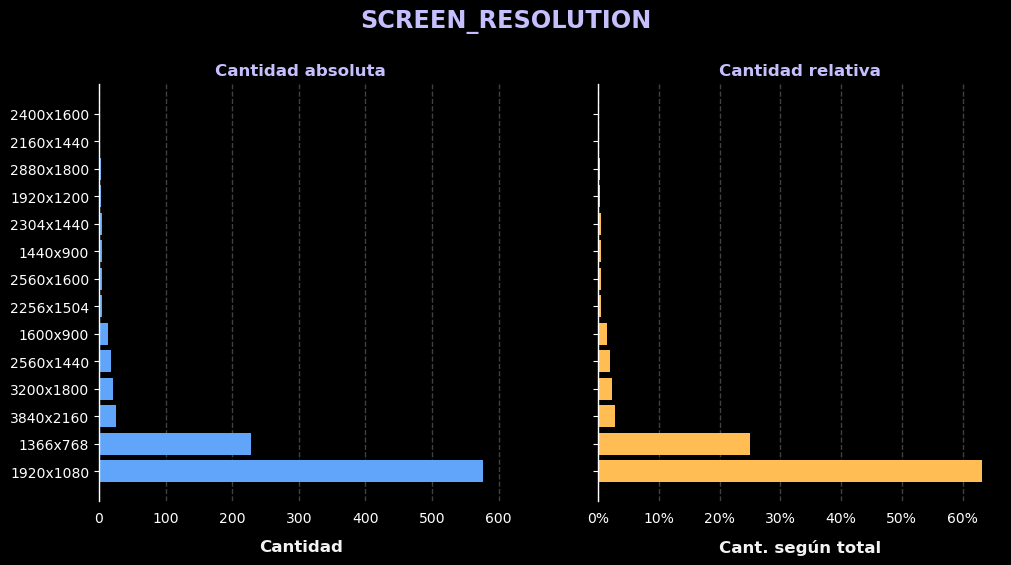

In [157]:
serie = df["screen_resolution"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`CPU`**

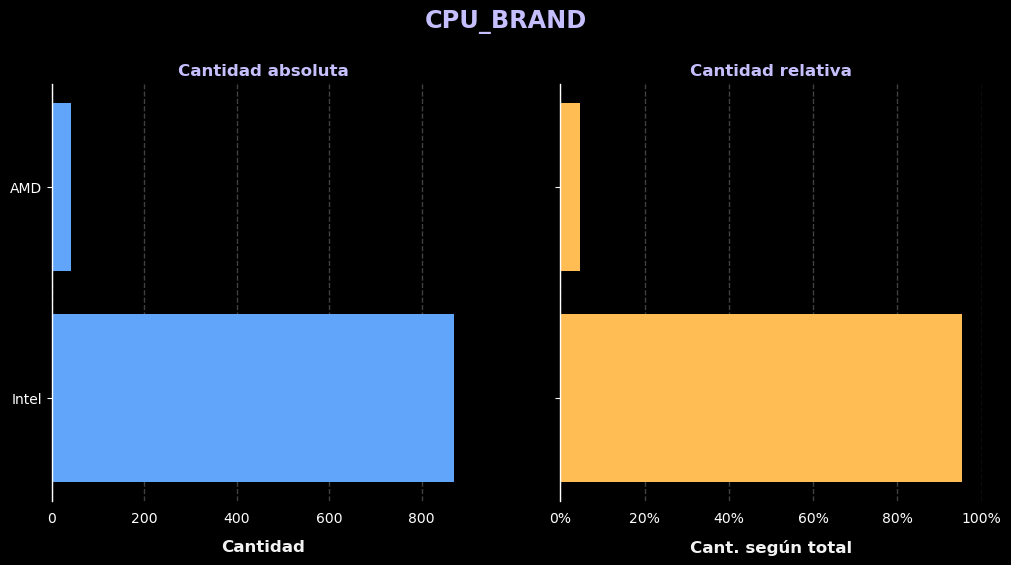

In [158]:
serie = df["cpu_brand"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

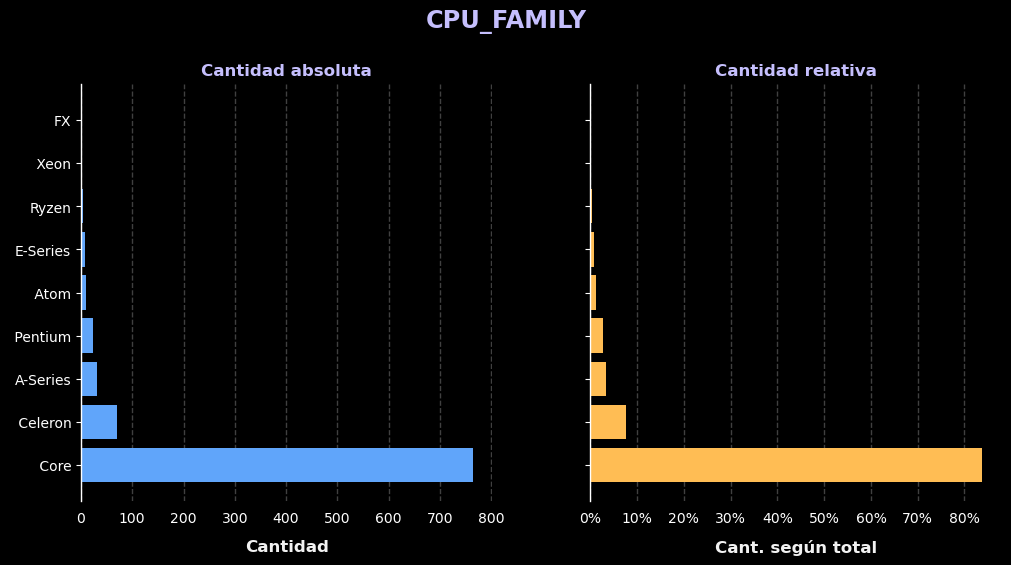

In [159]:
serie = df["cpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

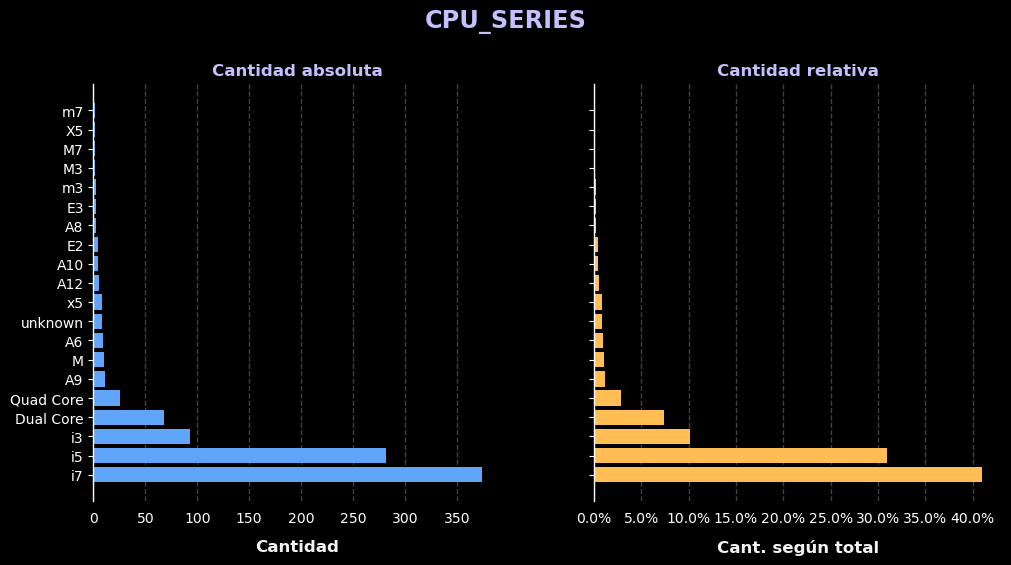

In [160]:
serie = df["cpu_series"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

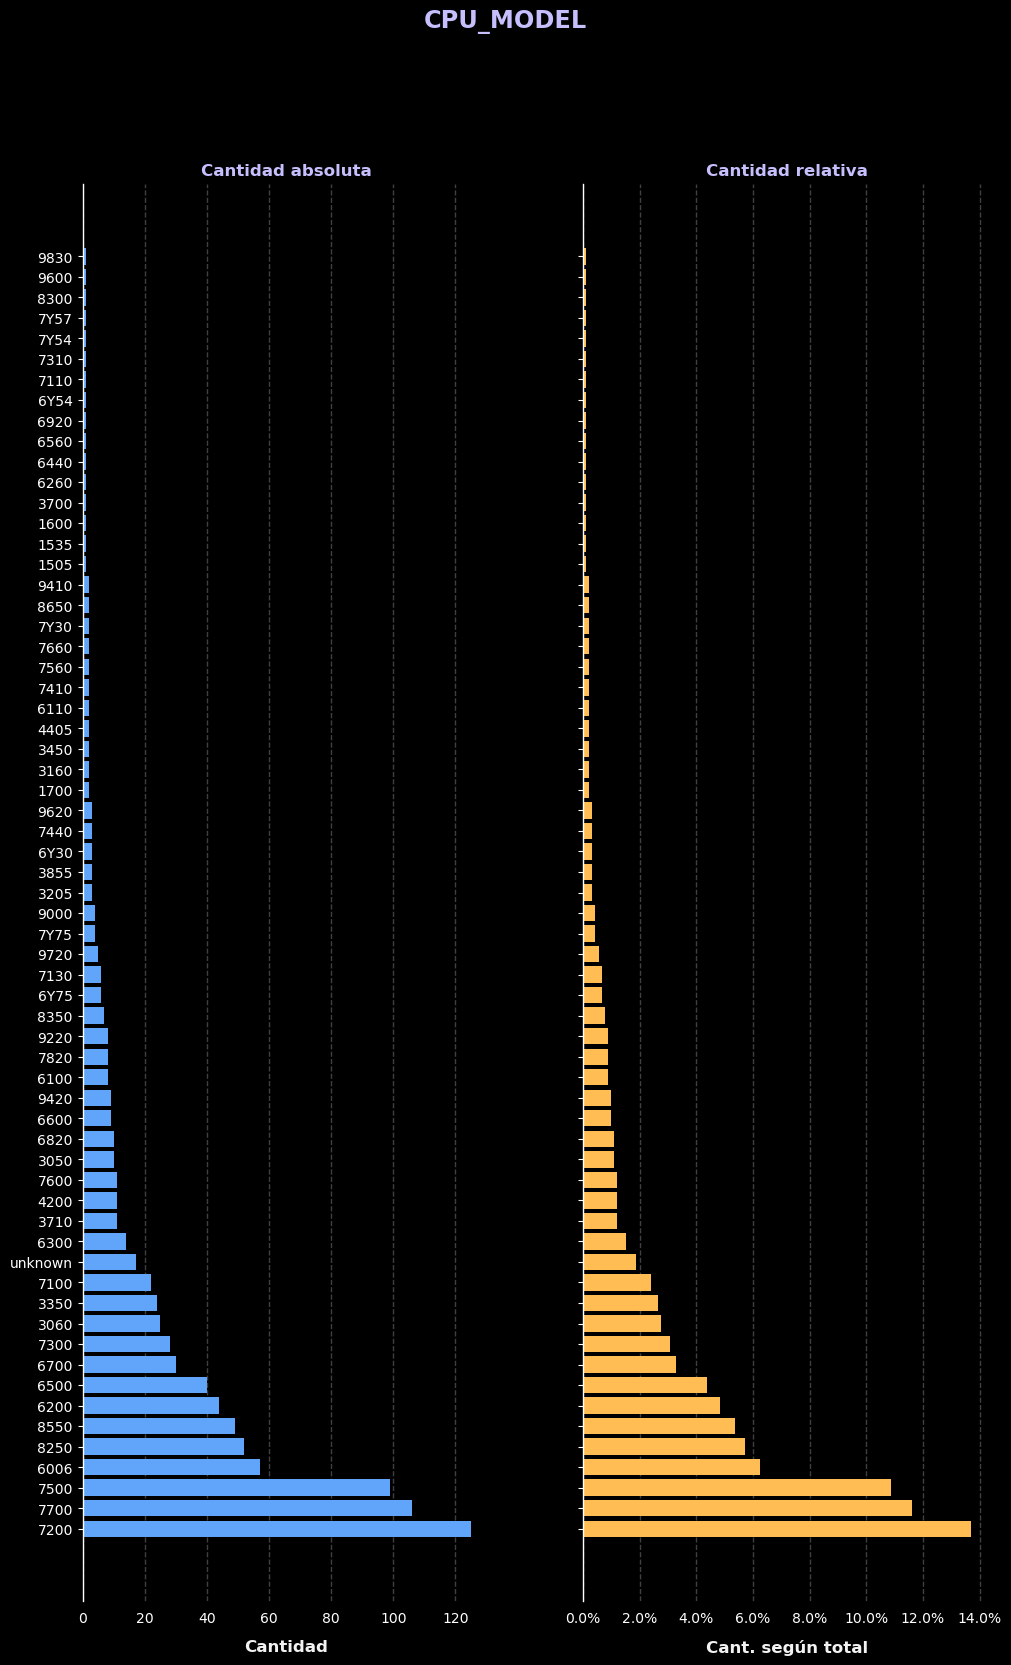

In [166]:
serie = df["cpu_model"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 15),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

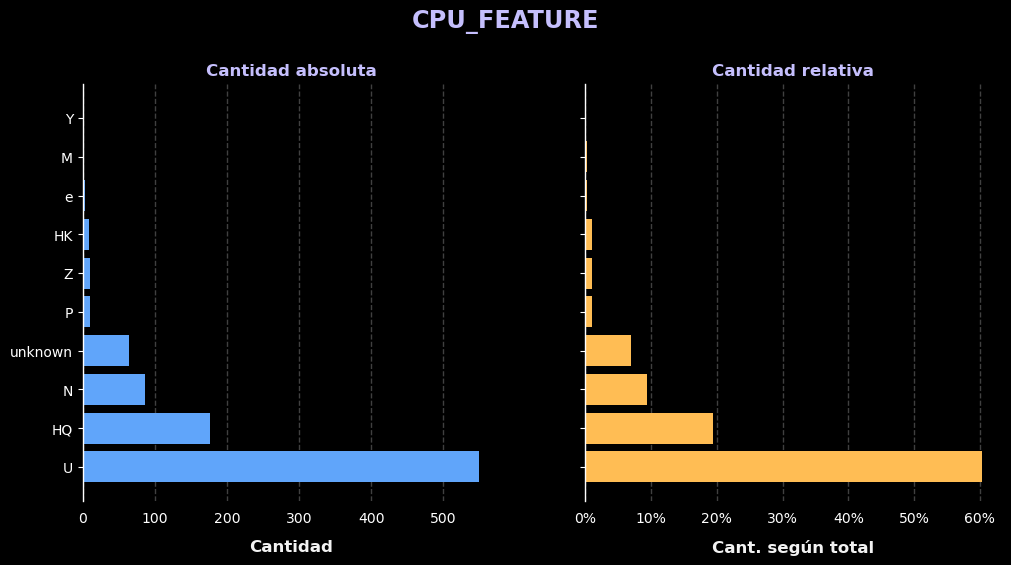

In [163]:
serie = df["cpu_feature"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

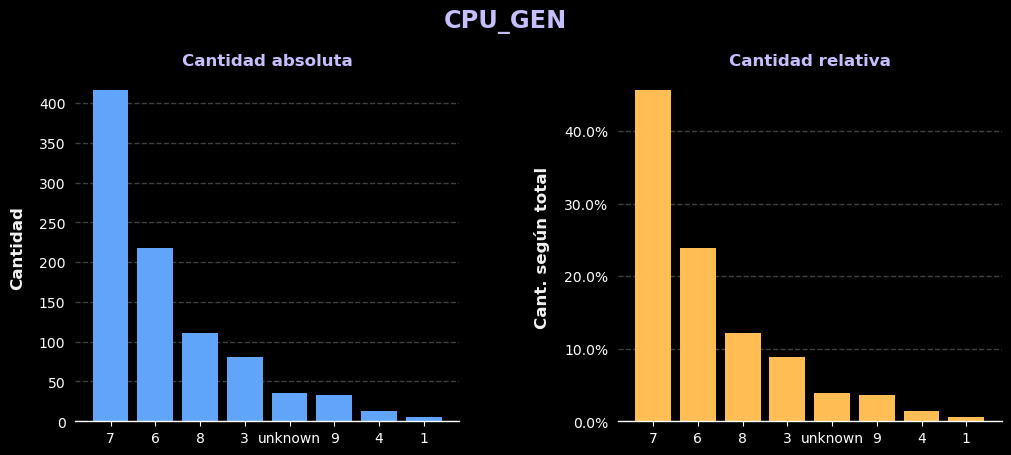

In [161]:
plot_category(df["cpu_gen"])

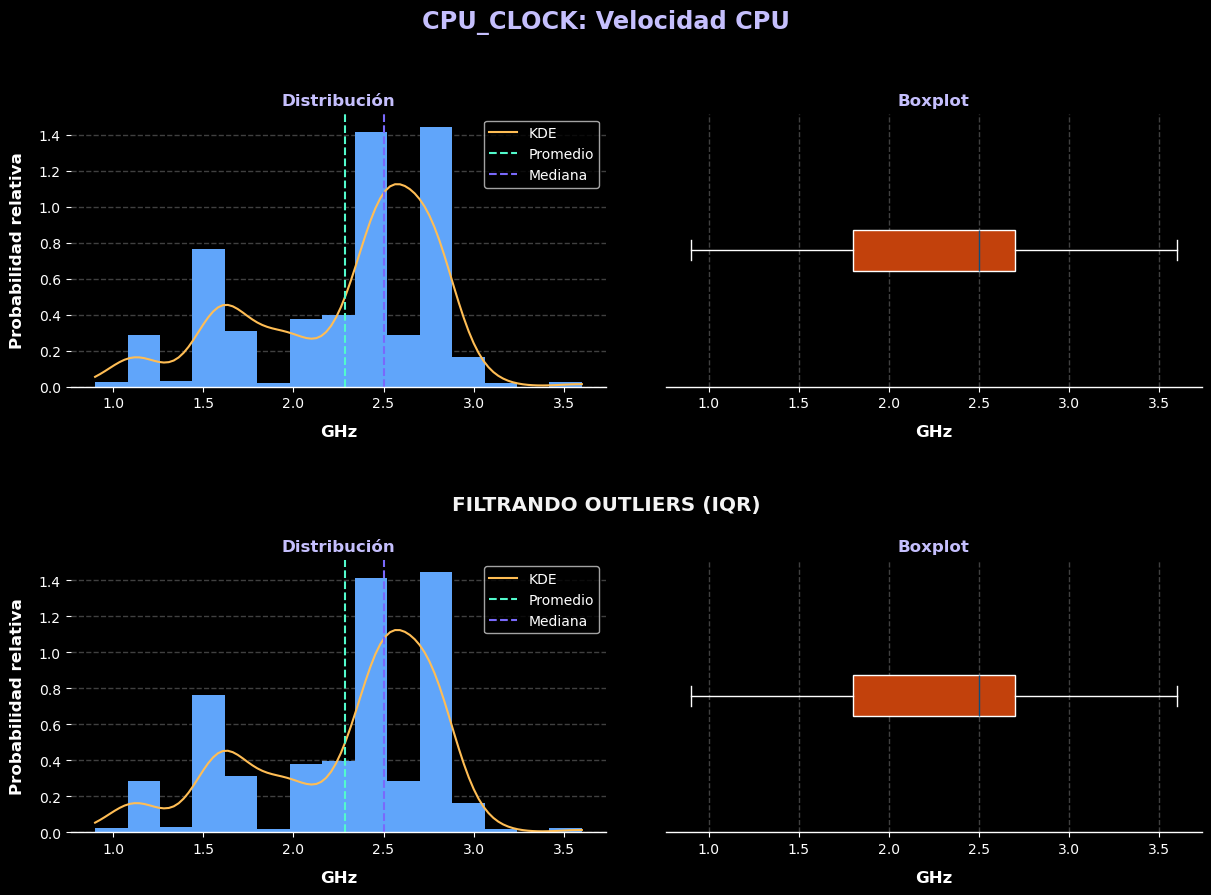

In [167]:
serie = df["cpu_clock"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Velocidad CPU",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`RAM`**

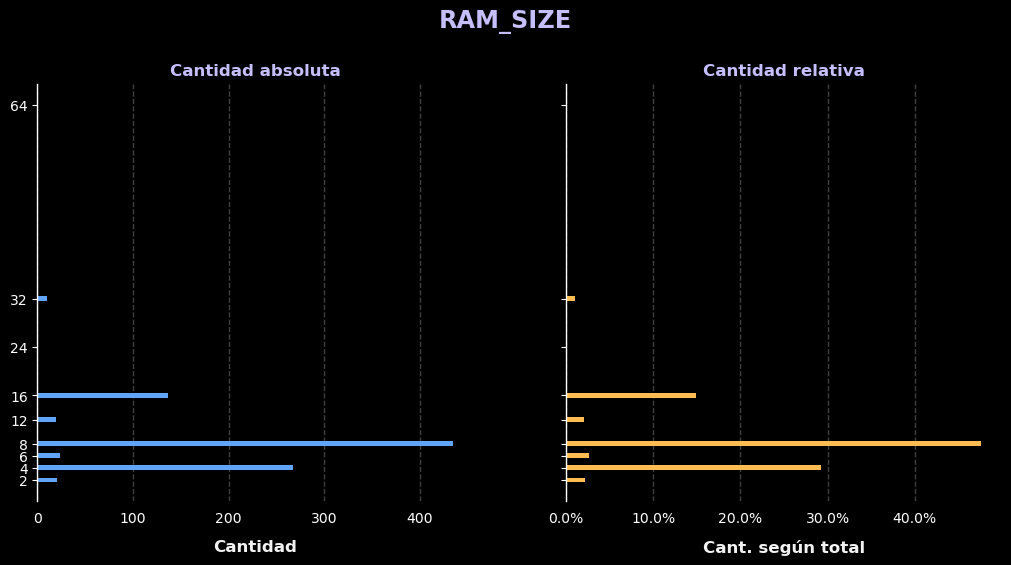

In [168]:
#plot_category(df["ram_size"])
serie = df["ram_size"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`HDD`**

Una transformación que debemos hacer con la información de `hard drive disc` es homogeneizar las unidades de medida de los datos.

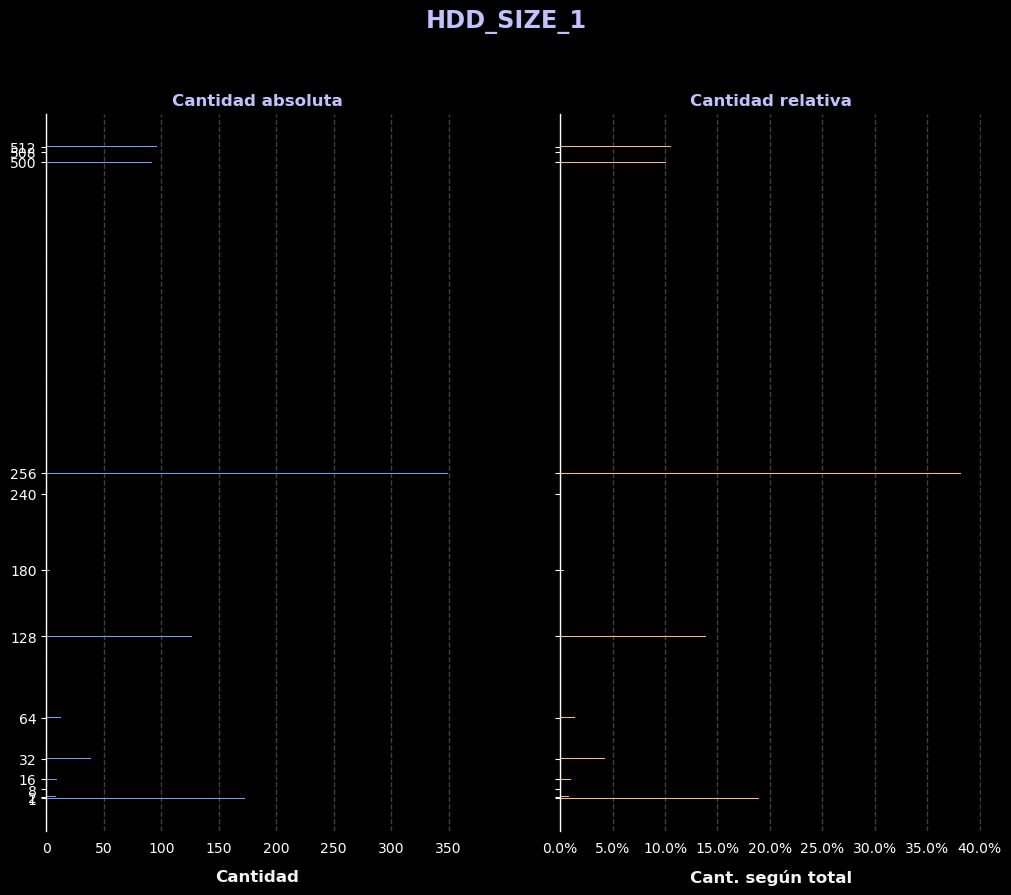

In [169]:
#plot_category(df["hdd_size_1"])
serie = df["hdd_size_1"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

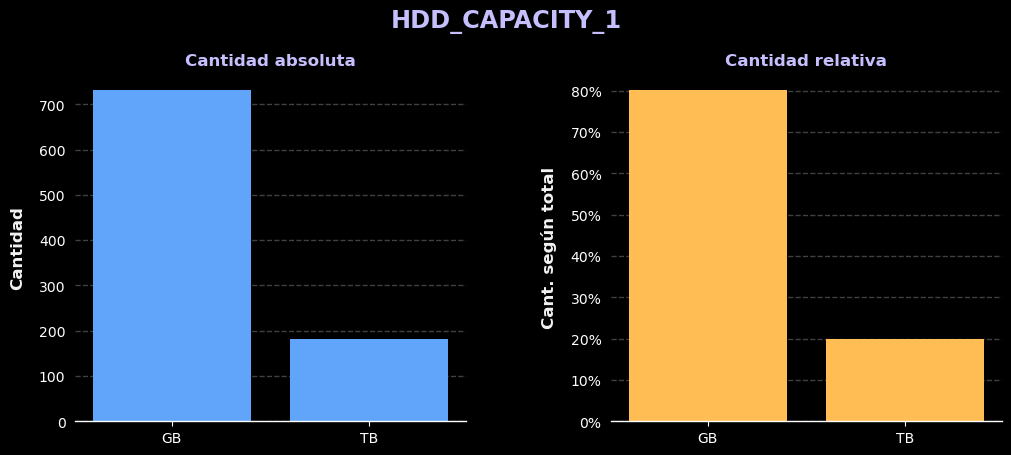

In [170]:
plot_category(df["hdd_capacity_1"])

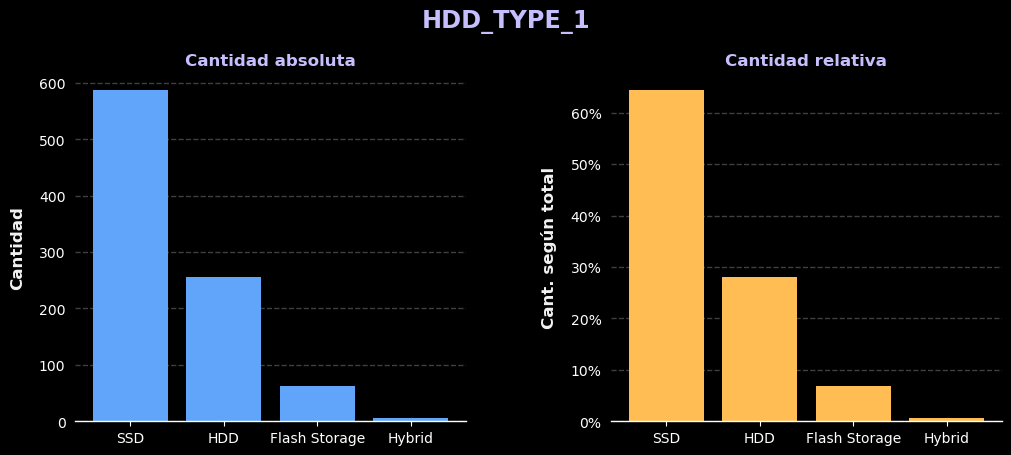

In [171]:
plot_category(df["hdd_type_1"])

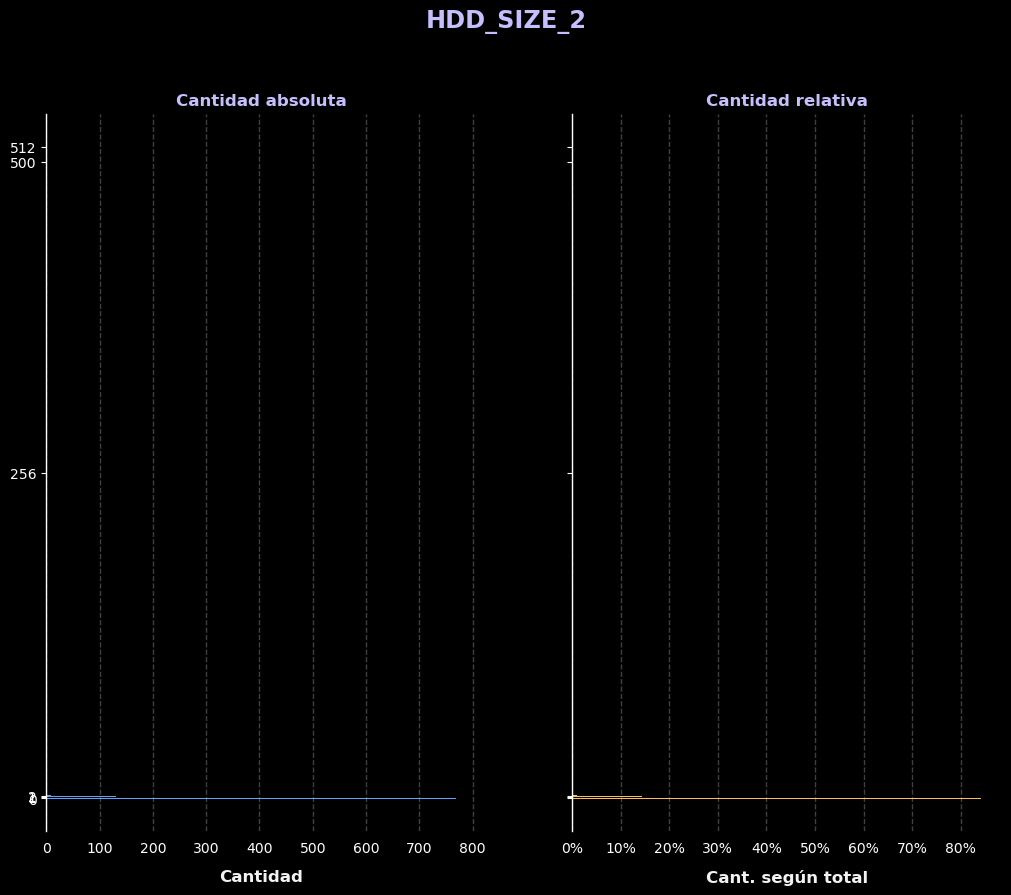

In [172]:
#plot_category(df["hdd_size_2"])
serie = df["hdd_size_2"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

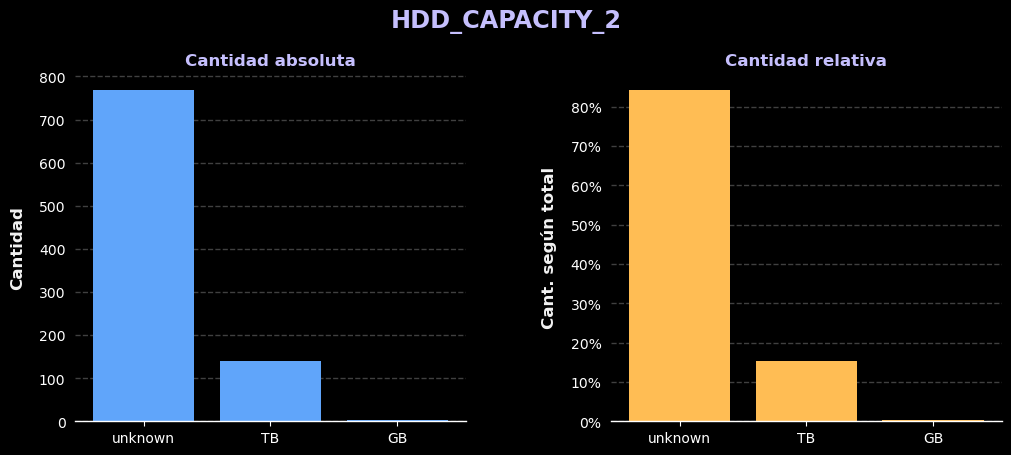

In [173]:
plot_category(df["hdd_capacity_2"])

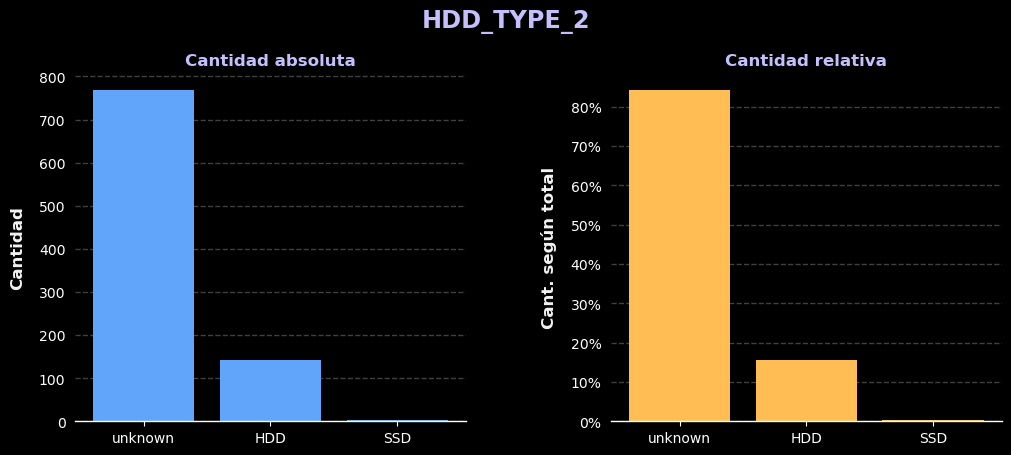

In [174]:
plot_category(df["hdd_type_2"])

##### **`GPU`**

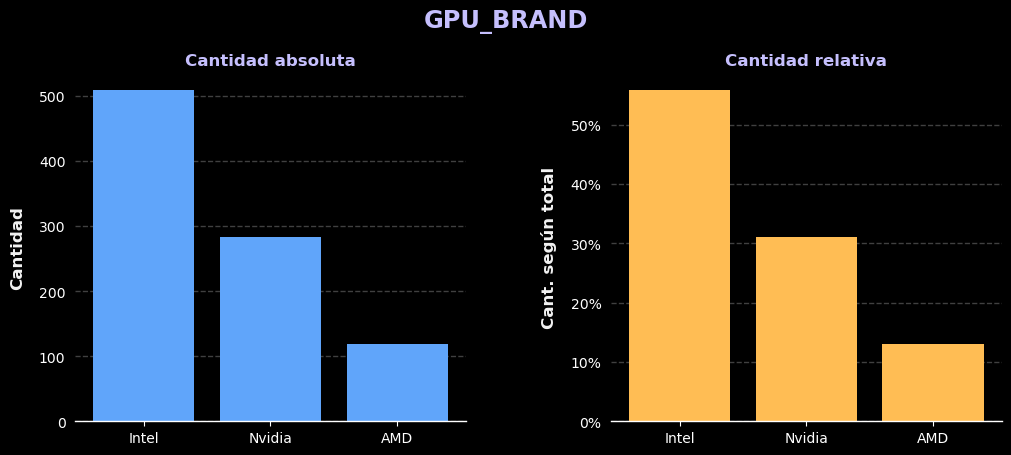

In [175]:
plot_category(df["gpu_brand"])

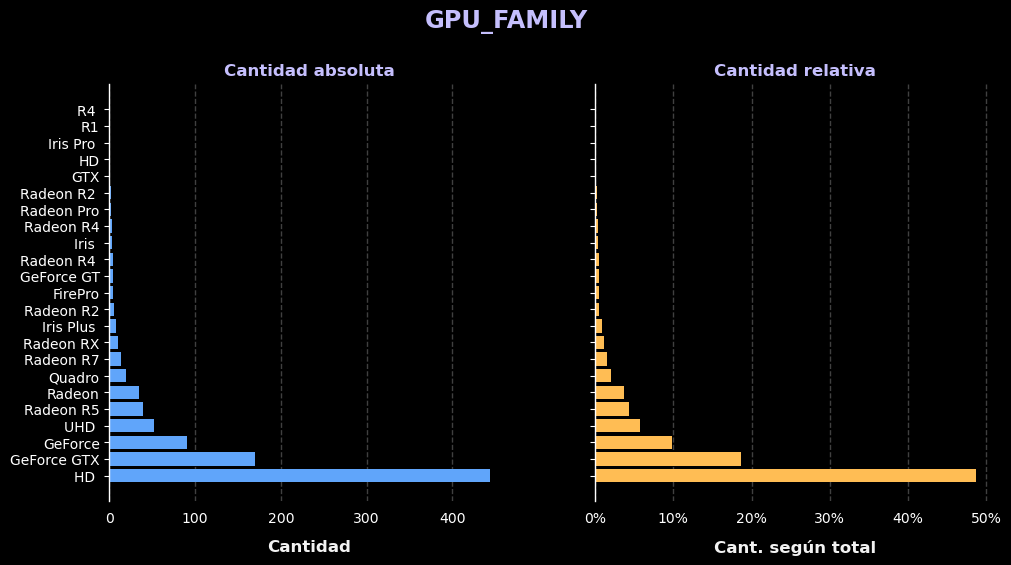

In [176]:
serie = df["gpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

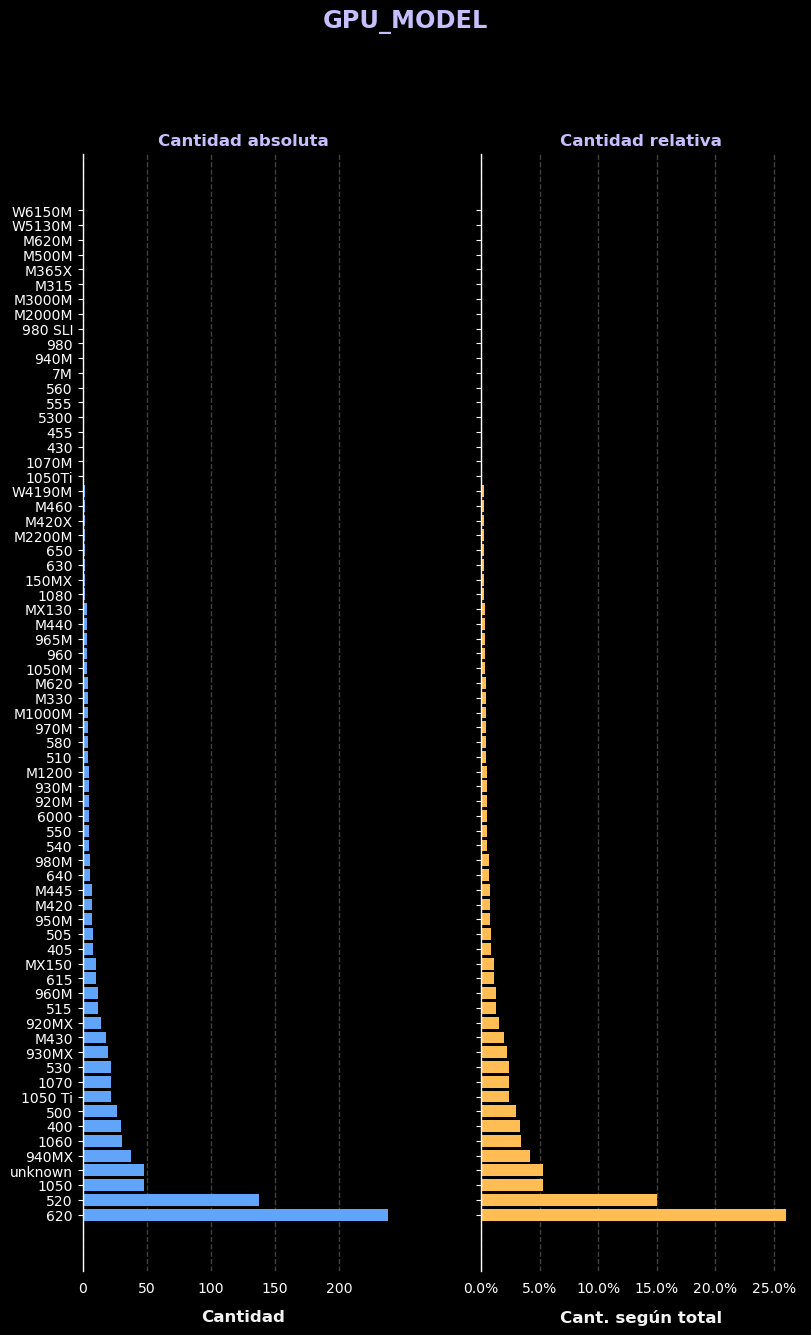

In [177]:
serie = df["gpu_model"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(8, 12),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",

			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### Final tweaks

Normalizamos los nombres de los sistemas operativos.

In [178]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

df.replace(maps, inplace=True)

laptop_id Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

       OpSys  Weight  Price_in_euros  has_touchscreen screen_panel  ...  \
0    Windows    1.86          539.00            False      unknown  ...   
1    Windows    2.59          879.01            False      unknown  ...   
2    Windows    2.04          900.00            False      unknown  ...   
3      macOS    1.34          898.94            False      unknown  ...   
4      Linux    2.25          428.00            False      unknown  ...   
..       ...     ...             ...              ...          ...  ...   
907  Windows    2.20          800.00            False      unknown  ...   
908  Windows    1.48         1629.00             True      unknown  ...   
909    No OS    2.20          519.00            False      unknown  ...   
910    No OS    1.86          258.00            False      unknown  ...   
911  Windows    4.42         2456.34            False    IPS Panel  ...   

    ram_capacity hdd_size_1  hdd_capacity_1     hdd_type_1  hdd_size_2  \
0             GB        256              GB            SSD           0   
1             GB          1              TB            HDD           0   
2             GB          1              TB            HDD           0   
3             GB        128              GB  Flash Storage           0   
4             GB          1              TB            HDD           0   
..           ...        ...             ...            ...         ...   
907           GB        256              GB            SSD           0   
908           GB        256              GB            SSD           0   
909           GB          2              TB            HDD           0   
910           GB        500              GB            HDD           0   
911           GB        256              GB            SSD           1   

    hdd_capacity_2 hdd_type_2 gpu_brand   gpu_family gpu_model  
0          unknown    unknown     Intel          HD        520  
1          unknown    unknown    Nvidia  GeForce GTX       960  
2          unknown    unknown    Nvidia      GeForce     930MX  
3          unknown    unknown     Intel          HD       6000  
4          unknown    unknown       AMD    Radeon R5      M430  
..             ...        ...       ...          ...       ...  
907        unknown    unknown       AMD       Radeon       530  
908        unknown    unknown     Intel          HD        520  
909        unknown    unknown     Intel          HD        620  
910        unknown    unknown       AMD    Radeon R2   unknown  
911             TB        HDD    Nvidia  GeForce GTX      1060  

[912 rows x 33 columns]

Normalizamos las unidades de medida en los `hard-drive disc`.

In [179]:
factor = {"GB": 1, "TB": 1024}
df["hdd_size_1"] = df["hdd_size_1"] * df["hdd_capacity_1"].map(factor).astype(int)

In [180]:
df["hdd_size_2"] = df["hdd_size_2"].astype(float)

conditions = [
	df["hdd_capacity_2"].str.lower() == "gb",
	df["hdd_capacity_2"].str.lower() == "tb",
	df["hdd_capacity_2"].isna()
]

choices = [
	df["hdd_size_2"] * 1,
	df["hdd_size_2"] * 1024,
	np.nan
]

df["hdd_size_2"] = np.select(conditions,
							 choices,
							 default=df["hdd_size_2"])

In [181]:
df["hdd_capacity_1"] = df["hdd_capacity_1"].str.replace("TB", "GB")
df["hdd_capacity_2"] = df["hdd_capacity_2"].str.replace("TB", "GB")

Eliminamos las columnas innecesarias de nuestro dataset.

In [182]:
df.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)

In [188]:
df.head().iloc[:, 8:]

has_touchscreen screen_panel screen_type screen_resolution  screen_width  \
0            False      unknown     Full HD         1920x1080          1920   
1            False      unknown     Full HD         1920x1080          1920   
2            False      unknown     Full HD         1920x1080          1920   
3            False      unknown         HD+          1440x900          1440   
4            False      unknown     Full HD         1920x1080          1920   

   screen_height  screen_ppi cpu_brand cpu_family cpu_series  ...  cpu_gen  \
0           1080      141.21     Intel       Core         i3  ...        6   
1           1080      141.21     Intel       Core         i7  ...        6   
2           1080      141.21     Intel       Core         i7  ...        7   
3            900      127.68     Intel       Core         i5  ...  unknown   
4           1080      141.21     Intel       Core         i3  ...        6   

  cpu_clock ram_size  hdd_size_1     hdd_type_1  hdd_size_2 hdd_type_2  \
0       2.0        8         256            SSD         0.0    unknown   
1       2.6       16        1024            HDD         0.0    unknown   
2       2.7        8        1024            HDD         0.0    unknown   
3       1.8        8         128  Flash Storage         0.0    unknown   
4       2.0        4        1024            HDD         0.0    unknown   

   gpu_brand   gpu_family gpu_model  
0      Intel          HD        520  
1     Nvidia  GeForce GTX       960  
2     Nvidia      GeForce     930MX  
3      Intel          HD       6000  
4        AMD    Radeon R5      M430  

[5 rows x 22 columns]

#### Guardado de datos

Creamos una nueva columna de targetas gráficas integradas y las que no. Normalmente, todas las gráficas de Intel son integradas.

In [189]:
df["gpu_integrated"] = df["gpu_brand"].str.contains("intel", case=False)
df["has_hdd2"] = df["hdd_size_2"] != 0

In [190]:
df["OpSys"] = df["OpSys"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")

In [192]:
df.set_index("laptop_id", inplace=True)
df.to_csv(path_or_buf=f"{path}/checkpoint.csv", index=True)

### Definir X e y

In [194]:
path = "./data"
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
df = pd.read_csv(filepath_or_buffer=f"{path}/checkpoint.csv",
				 index_col="laptop_id")

In [195]:
df.info()

<class 'pandas.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            912 non-null    str    
 1   Product            912 non-null    str    
 2   TypeName           912 non-null    str    
 3   Inches             912 non-null    float64
 4   OpSys              912 non-null    str    
 5   Weight             912 non-null    float64
 6   Price_in_euros     912 non-null    float64
 7   has_touchscreen    912 non-null    bool   
 8   screen_panel       912 non-null    str    
 9   screen_type        912 non-null    str    
 10  screen_resolution  912 non-null    str    
 11  screen_width       912 non-null    int64  
 12  screen_height      912 non-null    int64  
 13  screen_ppi         912 non-null    float64
 14  cpu_brand          912 non-null    str    
 15  cpu_family         912 non-null    str    
 16  cpu_series         912 non-null    str  

### Dividir X_train, X_test, y_train, y_test

In [196]:
df.rename(str.lower, axis="columns", inplace=True)
df.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [197]:
df_train, df_test = train_test_split(
	df,
	test_size=.2,
	random_state=42,
	shuffle=True)
df_train

company                         product     typename  inches  \
laptop_id                                                                
1118           HP                        ZBook 17  Workstation    17.3   
153          Dell                   Inspiron 5577       Gaming    15.6   
275         Apple                     MacBook Pro    Ultrabook    13.3   
1100           HP                   EliteBook 840     Notebook    14.0   
131          Dell                   Inspiron 5770     Notebook    17.3   
...           ...                             ...          ...     ...   
578            HP  14-am079na (N3710/8GB/2TB/W10)     Notebook    14.0   
996        Lenovo               IdeaPad 320-15ABR     Notebook    15.6   
770          Dell                   Latitude 7280    Ultrabook    12.5   
407        Lenovo               IdeaPad 320-15IAP     Notebook    15.6   
418        Lenovo                  Thinkpad T470p    Ultrabook    14.0   

                os  weight    price  has_touchscreen screen_panel screen_type  \
laptop_id                                                                       
1118       Windows    3.00  2899.00            False    IPS Panel     Full HD   
153        Windows    2.56  1249.26            False      unknown     Full HD   
275          macOS    1.37  1958.90            False    IPS Panel     Quad HD   
1100       Windows    1.54  1030.99            False      unknown     Full HD   
131        Windows    2.80  1396.00            False      unknown     Full HD   
...            ...     ...      ...              ...          ...         ...   
578        Windows    1.94   389.00            False      unknown          HD   
996        Windows    2.20   549.00            False      unknown     Full HD   
770        Windows    1.18  1859.00            False      unknown     Full HD   
407        Windows    2.20   306.00            False      unknown          HD   
418        Windows    1.70  1943.00            False    IPS Panel     Quad HD   

           ... ram_size  hdd_size_1  hdd_type_1  hdd_size_2 hdd_type_2  \
laptop_id  ...                                                           
1118       ...        8        1024         HDD         0.0    unknown   
153        ...       16         512         SSD         0.0    unknown   
275        ...        8         512         SSD         0.0    unknown   
1100       ...        4         500         HDD         0.0    unknown   
131        ...       16         256         SSD      2048.0        HDD   
...        ...      ...         ...         ...         ...        ...   
578        ...        8        2048         HDD         0.0    unknown   
996        ...        6         256         SSD         0.0    unknown   
770        ...       16         256         SSD         0.0    unknown   
407        ...        4        1024         HDD         0.0    unknown   
418        ...        8         512         SSD         0.0    unknown   

          gpu_brand   gpu_family gpu_model gpu_integrated has_hdd2  
laptop_id                                                           
1118            AMD      FirePro    W6150M          False    False  
153          Nvidia  GeForce GTX      1050          False    False  
275           Intel        Iris        550           True    False  
1100          Intel          HD        520           True    False  
131             AMD       Radeon       530          False     True  
...             ...          ...       ...            ...      ...  
578           Intel          HD        405           True    False  
996             AMD       Radeon       530          False    False  
770           Intel          HD        620           True    False  
407           Intel          HD        500           True    False  
418          Nvidia   GeForce GT     940MX          False    False  

[729 rows x 31 columns]

In [198]:
df_train["log_price"] = np.log1p(df_train["price"])
df_test["log_price"] = np.log1p(df_test["price"])

### Análisis Multivariante
#### Distribución de `Price` según `Company`

In [ ]:
sns.color_palette("Set3")
sns.set_style("whitegrid")

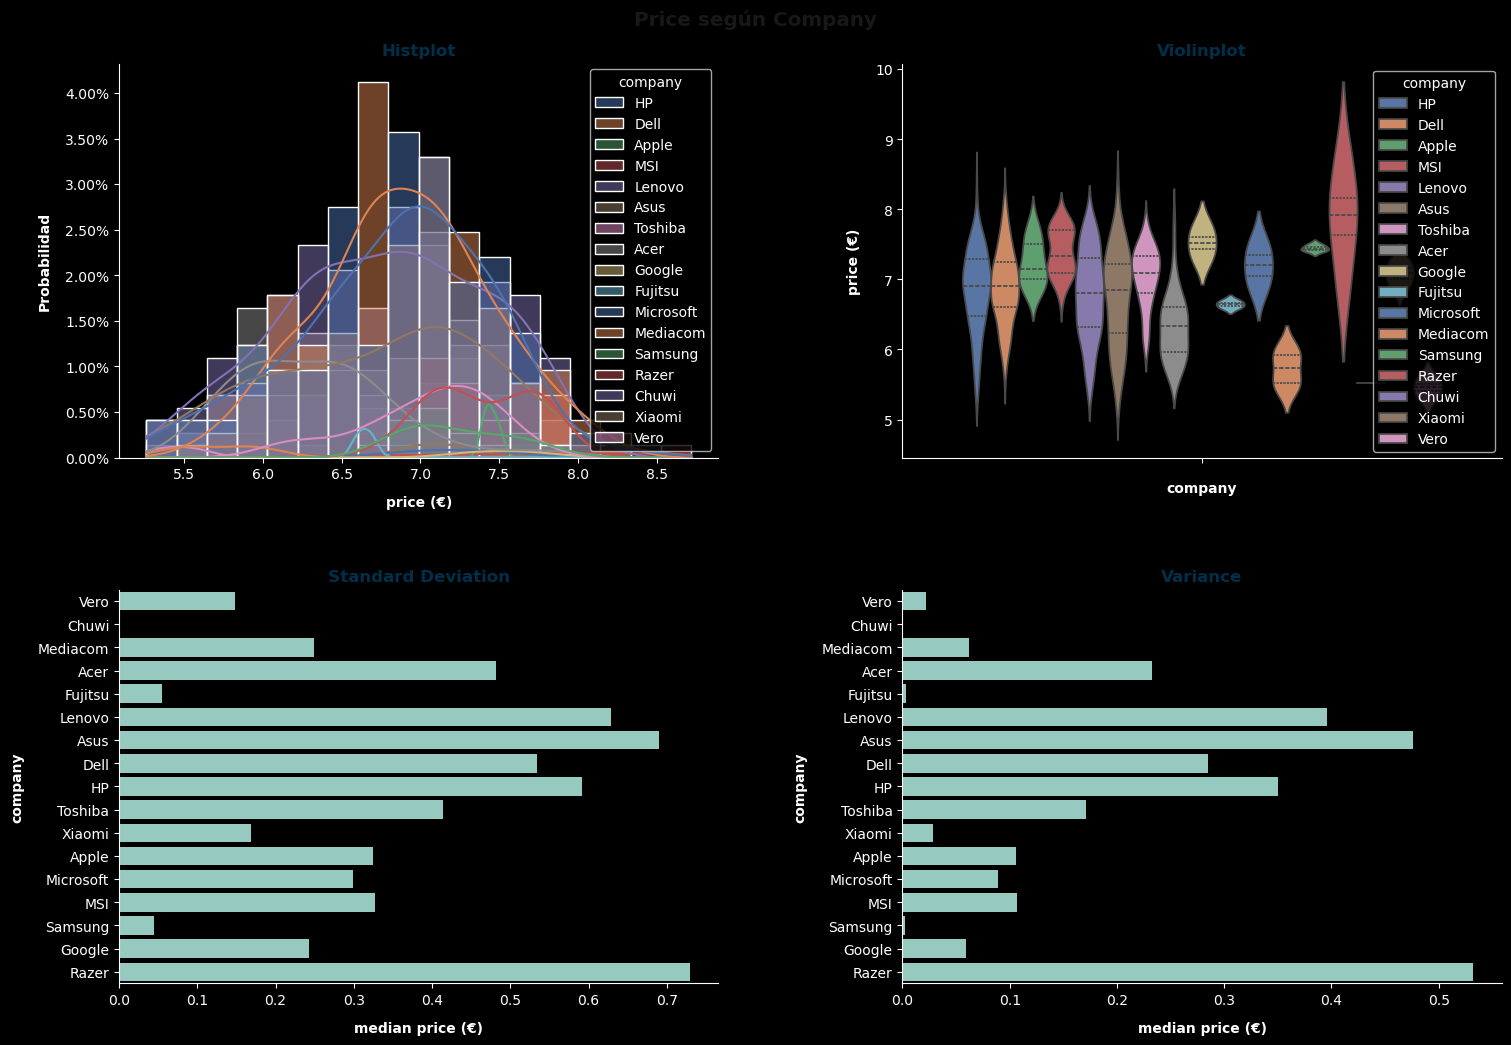

In [199]:
fig, axs = plt.subplots(nrows=2,
						ncols=2,
						figsize=(15, 10),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Company",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="company",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Violinplot", color="#003049", fontdict=font_config)
sns.violinplot(data=df_train,
			   y="log_price",
			   inner="quart",
			   hue="company",
			   palette="deep",
			   ax=axs[0][1])
sns.despine(ax=axs[0][1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("company", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Standard Deviation",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std"]
).sort_values(by="median")
sns.barplot(data=data,
			x="std",
			y=data.index,
			ax=axs[1][0])
sns.despine(ax=axs[1][0])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("company", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Variance",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std", "var"]
).sort_values(by="median")
sns.barplot(data=data,
			x="var",
			y=data.index,
			ax=axs[1][1])
sns.despine(ax=axs[1][1])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("company", labelpad=10, fontdict=font_config)
fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `company`

In [200]:
df_train.groupby(by="company")["price"].agg(
	["count", "mean", "median", "min", "max", "std", "var"]
).sort_values(by="median")

count         mean    median      min      max          std  \
company                                                                  
Vero           2   235.400000   235.400   210.80   260.00    34.789654   
Chuwi          1   248.900000   248.900   248.90   248.90          NaN   
Mediacom       4   313.000000   312.000   239.00   389.00    76.924205   
Acer          55   634.229091   559.000   269.00  2599.00   404.367320   
Fujitsu        2   769.000000   769.000   739.00   799.00    42.426407   
Lenovo       162  1056.385309   899.000   229.00  2663.00   631.018068   
Asus         101  1063.480693   945.000   191.90  3975.00   718.489103   
Dell         158  1140.946835   992.000   274.90  3659.40   635.673232   
HP           155  1097.500323  1000.000   209.00  4389.00   623.559206   
Toshiba       31  1231.516129  1195.000   447.00  2226.00   445.147981   
Xiaomi         3  1199.616667  1199.000   999.90  1399.95   200.025713   
Apple         13  1455.894615  1279.000   898.94  2439.97   493.007571   
Microsoft      3  1376.000000  1340.000   989.00  1799.00   406.198227   
MSI           30  1699.350333  1528.415   839.00  2729.00   542.454325   
Samsung        3  1715.666667  1699.000  1649.00  1799.00    76.376262   
Google         2  1879.000000  1879.000  1559.00  2199.00   452.548340   
Razer          4  3156.500000  2749.000  1029.00  6099.00  2126.160467   

                    var  
company                  
Vero       1.210320e+03  
Chuwi               NaN  
Mediacom   5.917333e+03  
Acer       1.635129e+05  
Fujitsu    1.800000e+03  
Lenovo     3.981838e+05  
Asus       5.162266e+05  
Dell       4.040805e+05  
HP         3.888261e+05  
Toshiba    1.981567e+05  
Xiaomi     4.001029e+04  
Apple      2.430565e+05  
Microsoft  1.649970e+05  
MSI        2.942567e+05  
Samsung    5.833333e+03  
Google     2.048000e+05  
Razer      4.520558e+06

La notebook más cara sale €6.099 y corresponde a la marca `Razer`. La más económica corresponde a la marca `Asus` y cuesta €191.90.

La mediana de `price` del fabricante `Razer` es la más alta entre los 19 fabricantes de pc que tenemos. De todas maneras, también hay que destacar que solo contamos con 4 registros de dicha marca.

#### Distribución de `Price` según `TypeName`

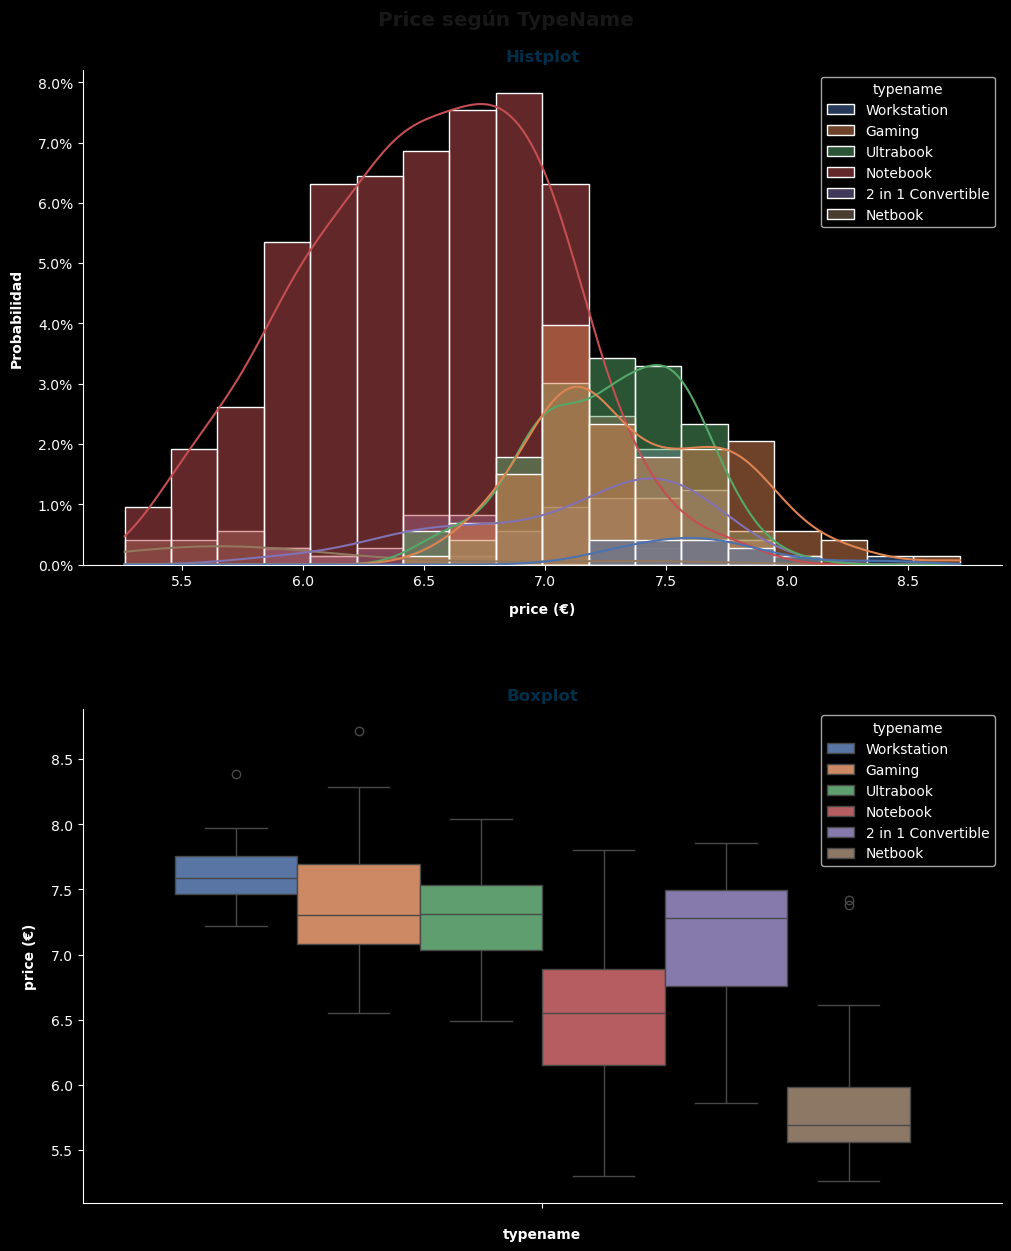

In [201]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según TypeName",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="typename",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="typename",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `typename`.

In [202]:
df_train.groupby(by=["typename"])["price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

count         mean     min     max   median         std  \
typename                                                                      
Netbook                16   487.237500   191.9  1669.0   296.00  466.296466   
Notebook              412   763.803932   199.0  2449.0   698.50  388.203195   
2 in 1 Convertible     62  1379.410968   349.0  2590.0  1449.00  573.410452   
Gaming                113  1731.491593   699.0  6099.0  1486.77  808.943919   
Ultrabook             113  1526.832743   659.0  3100.0  1495.00  473.828464   
Workstation            13  2189.635385  1369.0  4389.0  1975.00  781.652784   

                              var  
typename                           
Netbook             217432.394500  
Notebook            150701.720245  
2 in 1 Convertible  328799.545953  
Gaming              654390.263583  
Ultrabook           224513.412829  
Workstation         610981.075394

Siguiendo lo mencionado anteriormente, la computadora más cara corresponde al segmento `Gaming` y la más económica al segmento `Netbook`.

La mediana es consitente entre `ultrabook`, `gaming` y las `2 in 1 convertible`. A su vez, podemos ver que la desviación estandar al igual que la varianza en las notebooks de `Workstation` y `Gaming` es muy alta.

#### Distribución de `Price` según `Inches`

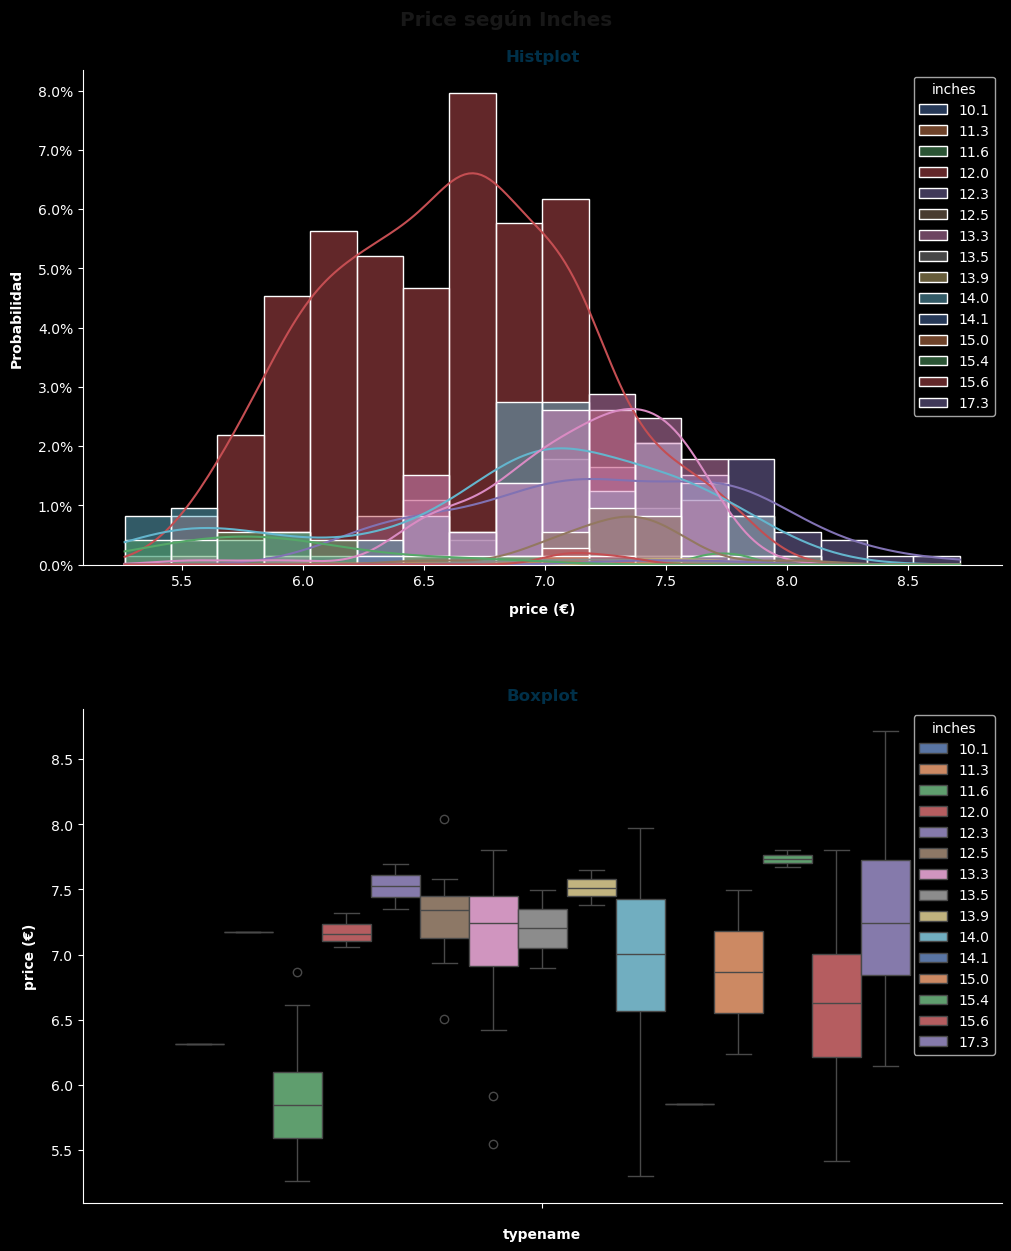

In [203]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Inches",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="inches",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="inches",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Al parecer, la distribución del precio de las laptops con pantallas de 17.3" tiene una cola hacía la derecha, dejando entrever que pueden alcanzar precios elevados.

In [204]:
df_train.groupby("inches")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
])

count         mean      min      max   median         std  \
inches                                                              
10.1        1   549.000000   549.00   549.00   549.00         NaN   
11.3        1  1299.000000  1299.00  1299.00  1299.00         NaN   
11.6       20   389.490000   191.90   959.00   344.50  193.101939   
12.0        3  1317.333333  1163.00  1510.00  1279.00  176.647483   
12.3        2  1879.000000  1559.00  2199.00  1879.00  452.548340   
12.5       21  1531.537143   669.00  3100.00  1539.00  472.931775   
13.3       99  1362.704040   255.00  2449.00  1399.00  464.014558   
13.5        3  1376.000000   989.00  1799.00  1340.00  406.198227   
13.9        2  1849.000000  1599.00  2099.00  1849.00  353.553391   
14.0      115  1193.592000   199.00  2899.00  1099.00  664.313713   
14.1        1   348.000000   348.00   348.00   348.00         NaN   
15.0        2  1154.000000   509.00  1799.00  1154.00  912.167748   
15.4        2  2289.970000  2139.97  2439.97  2289.97  212.132034   
15.6      362   855.116077   224.00  2449.00   757.00  467.690547   
17.3       95  1667.027263   466.00  6099.00  1396.00  988.331293   

                  var  
inches                 
10.1              NaN  
11.3              NaN  
11.6     37288.358842  
12.0     31204.333333  
12.3    204800.000000  
12.5    223664.463571  
13.3    215309.509996  
13.5    164997.000000  
13.9    125000.000000  
14.0    441312.709618  
14.1              NaN  
15.0    832050.000000  
15.4     45000.000000  
15.6    218734.448207  
17.3    976798.744256

#### Distribución de `Price` según `OS`

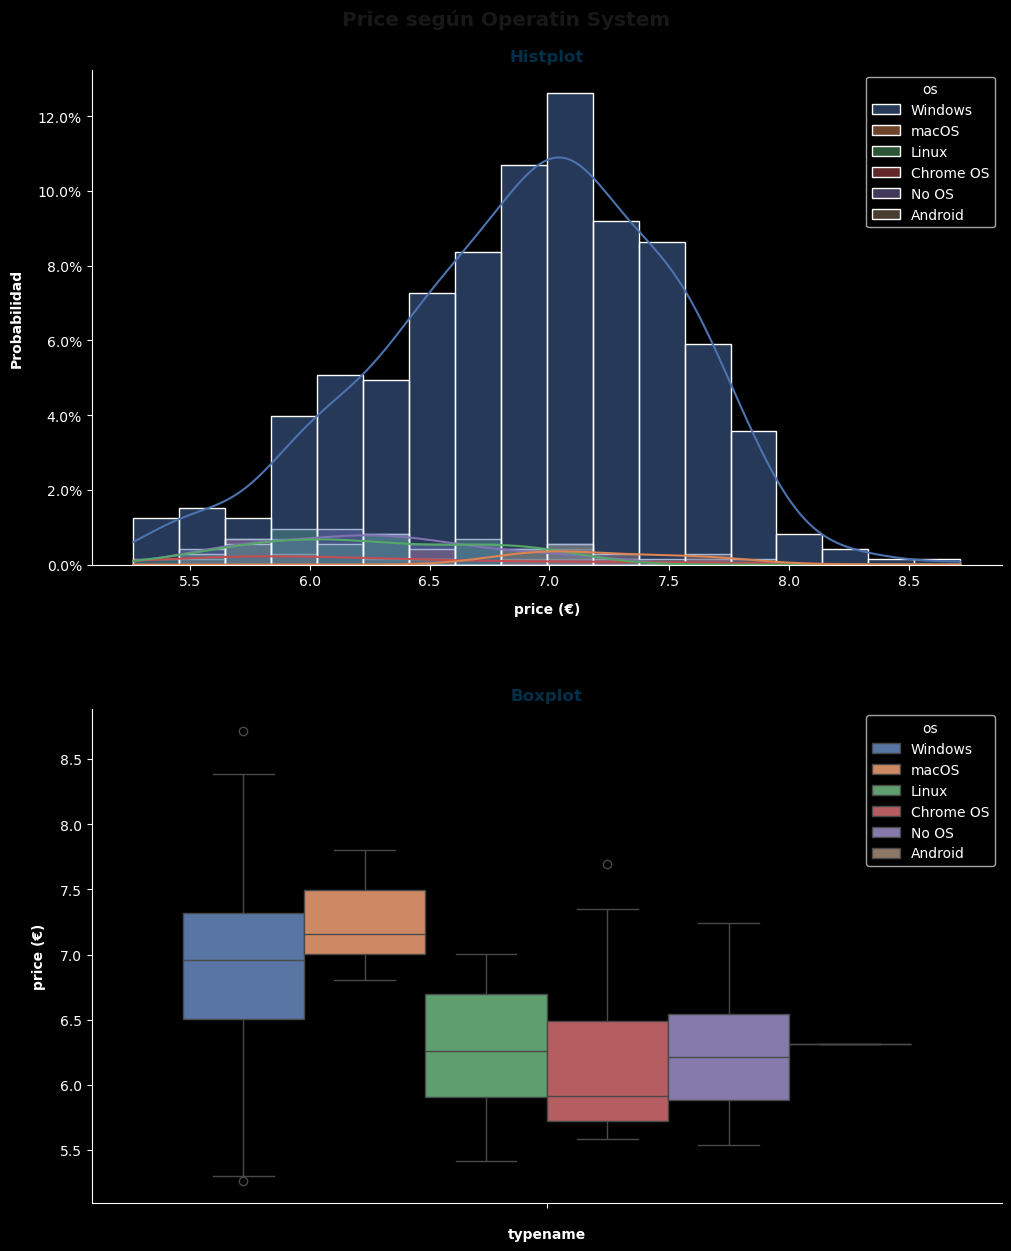

In [205]:
fig, axs = plt.subplots(nrows=2,
						ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Operatin System",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="os",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="os",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [206]:
df_train.groupby("os")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="median")

count         mean     min      max   median         std  \
os                                                                    
Chrome OS     14   668.278571  265.00  2199.00   370.00  580.327953   
No OS         39   583.784359  252.36  1399.95   499.00  288.226338   
Linux         37   590.808378  224.00  1099.00   522.99  277.387573   
Android        1   549.000000  549.00   549.00   549.00         NaN   
Windows      625  1169.925408  191.90  6099.00  1049.00  680.194166   
macOS         13  1455.894615  898.94  2439.97  1279.00  493.007571   

                     var  
os                        
Chrome OS  336780.532582  
No OS       83074.421815  
Linux       76943.865520  
Android              NaN  
Windows    462664.103107  
macOS      243056.465294

Resulta interesante, aunque no es revelador, como el precio de dispositivos del ecosistema `Apple` tienen una mediana y media de precio más elevado, aunque la desviación estandar al igual que la varianza sea menor.

Esto nos indica claramente que son equipos más caro en relación a otros ecosistemas.


Otra cosa que podemos observar es que aquellos equipos que no poseen sistema operativo tienen unos estadísticos similares al ecosistema `Linux`. Son equipos bastante más económicos. Deberíamos analizar sí en prestaciones las pc poseen gran diferencia respecto a los otros ecosistemas, en caso de no ser así, tal vez, el hecho de tener un so instalado, libre y gratuito, o no pueda influir en el precio.

#### Distribución de `Price` según `Weight`

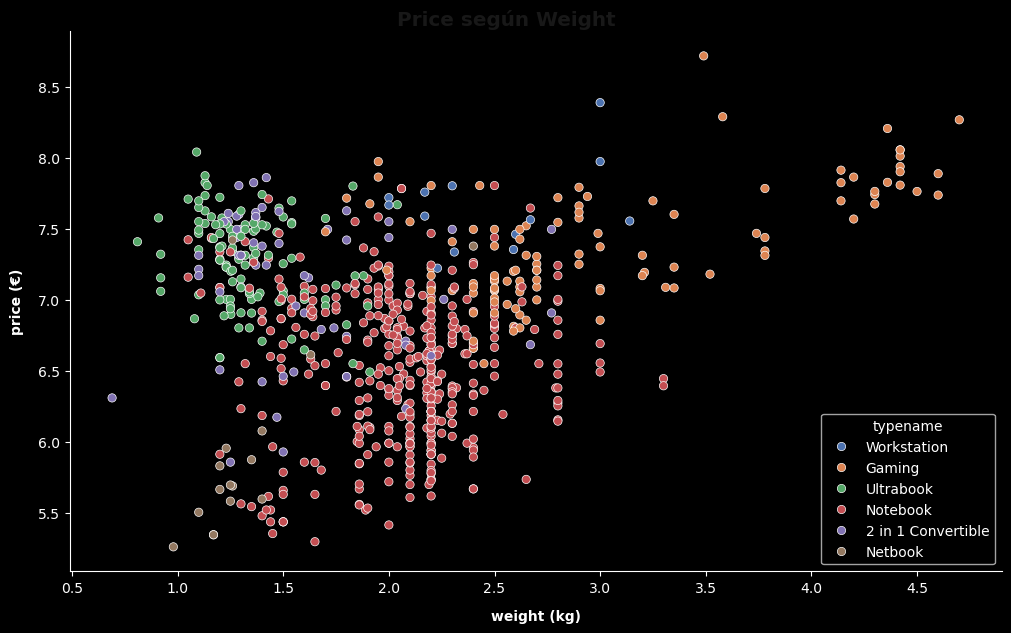

In [207]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Weight",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x="weight",
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)
ax.grid(axis="both", visible=False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("weight (kg)", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
plt.show()

Las notebooks del segmento `Gaminig` tienden a pesar más que las pertenecientes a otros segmentos. Lo mismo sucede con las `Ultrabook`, que son más ligeras en general. Las `netbooks` son las que menos pesan y las que menos cuestan.

#### Distribución de `Price` según `Screen`

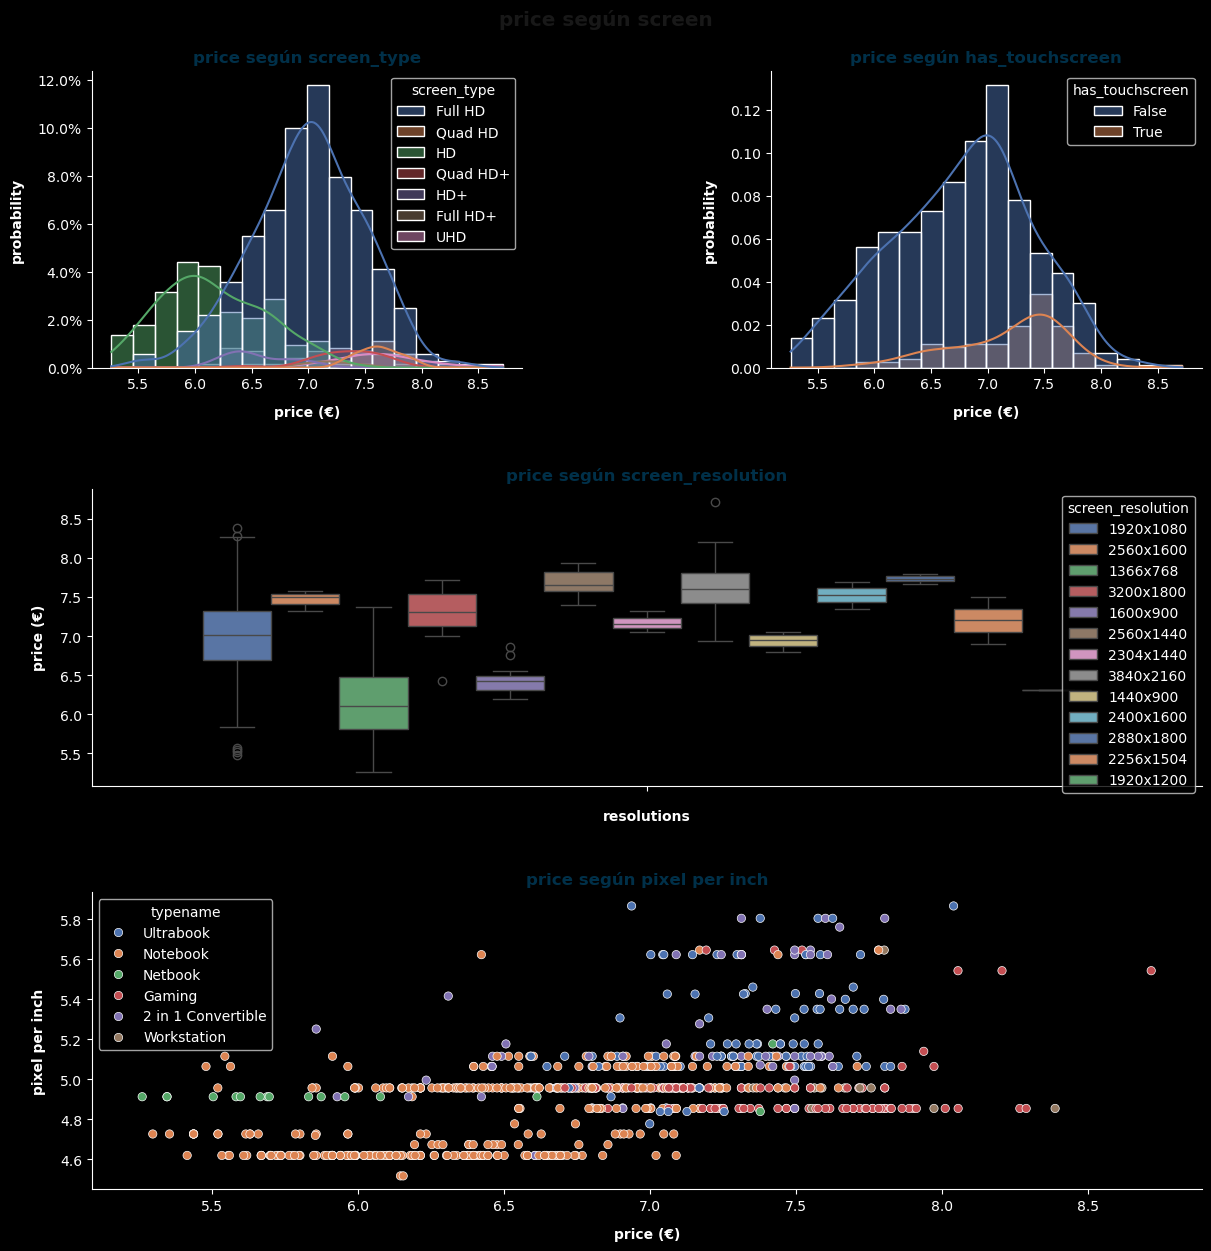

In [208]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["type", "has_touchscreen"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según screen",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["type"].set_title("price según screen_type",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="screen_type",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["type"])
sns.despine(ax=axs["type"])
axs["type"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["type"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["type"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["type"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_touchscreen"].set_title("price según has_touchscreen",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_touchscreen",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_touchscreen"])
sns.despine(ax=axs["has_touchscreen"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_touchscreen"].set_xlabel("price (€)",
								  labelpad=10,
								  fontdict=font_config)
axs["has_touchscreen"].set_ylabel("probability",
								  labelpad=10,
								  fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según screen_resolution",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="screen_resolution",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("resolutions",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según pixel per inch",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y=np.log1p(df["screen_ppi"]),
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("pixel per inch", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [209]:
df_train.groupby("screen_ppi")["log_price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="screen_ppi")

count      mean       min       max    median       std       var
screen_ppi                                                                   
90.58           2  6.150954  6.146329  6.155580  6.150954  0.006541  0.000043
100.45        121  6.175765  5.416100  7.090077  6.131226  0.358134  0.128260
106.11         14  6.443637  6.194405  6.856462  6.420491  0.184779  0.034143
111.14          1  5.855072  5.855072  5.855072  5.855072       NaN       NaN
111.94         28  6.062256  5.298317  7.081709  5.830026  0.622908  0.388015
117.83          3  6.760450  6.536692  6.999422  6.745236  0.231740  0.053704
125.37          5  7.171464  7.035401  7.377759  7.126891  0.142890  0.020418
127.34         75  7.387235  6.551080  8.387085  7.343840  0.432355  0.186931
127.68          4  6.942016  6.802328  7.055917  6.954910  0.111738  0.012485
135.09         19  5.875295  5.262172  6.866933  5.831882  0.435169  0.189372
141.21        232  6.810056  5.521061  7.803843  6.802950  0.433025  0.187510
146.86          2  6.864976  6.234411  7.495542  6.864976  0.891754  0.795226
157.35         76  7.078614  5.480639  7.972466  7.060393  0.471239  0.222066
158.48          1  7.377759  7.377759  7.377759  7.377759       NaN       NaN
165.63         62  7.071510  5.545177  7.708411  7.156954  0.419227  0.175751
169.78          1  7.937375  7.937375  7.937375  7.937375       NaN       NaN
176.23         14  7.308157  6.507278  7.576097  7.366760  0.267387  0.071496
189.91          1  5.857933  5.857933  5.857933  5.857933       NaN       NaN
194.95          1  7.170120  7.170120  7.170120  7.170120       NaN       NaN
200.84          3  7.198139  6.897705  7.495542  7.201171  0.298930  0.089359
209.80         11  7.650108  7.401231  7.873217  7.649693  0.163841  0.026844
220.53          2  7.734583  7.669014  7.800151  7.734583  0.092728  0.008598
220.84          1  7.621685  7.621685  7.621685  7.621685       NaN       NaN
224.17          1  6.309918  6.309918  6.309918  6.309918       NaN       NaN
226.42          3  7.178253  7.059618  7.320527  7.154615  0.132051  0.017437
226.98          3  7.468304  7.326170  7.580649  7.498094  0.129829  0.016856
234.51          2  7.524327  7.352441  7.696213  7.524327  0.243083  0.059089
254.67          3  8.325337  8.054640  8.716044  8.205328  0.346649  0.120166
276.05         20  7.296480  6.423247  7.720905  7.313220  0.294122  0.086508
282.42          9  7.524817  7.170120  7.802209  7.520776  0.239052  0.057146
316.97          1  7.649693  7.649693  7.649693  7.649693       NaN       NaN
331.26          6  7.549484  7.313220  7.803843  7.588244  0.178397  0.031825
352.47          2  7.488397  6.937314  8.039480  7.488397  0.779349  0.607385

Podemos ver que existe correlación entre los `pixel per inch` y el `price` del dispositivo. También se puede observar como aquellos equipos que tiene pantalla táctil tienen un precio más eleveda por lo general.

#### Distribución de `Price` según `CPU`

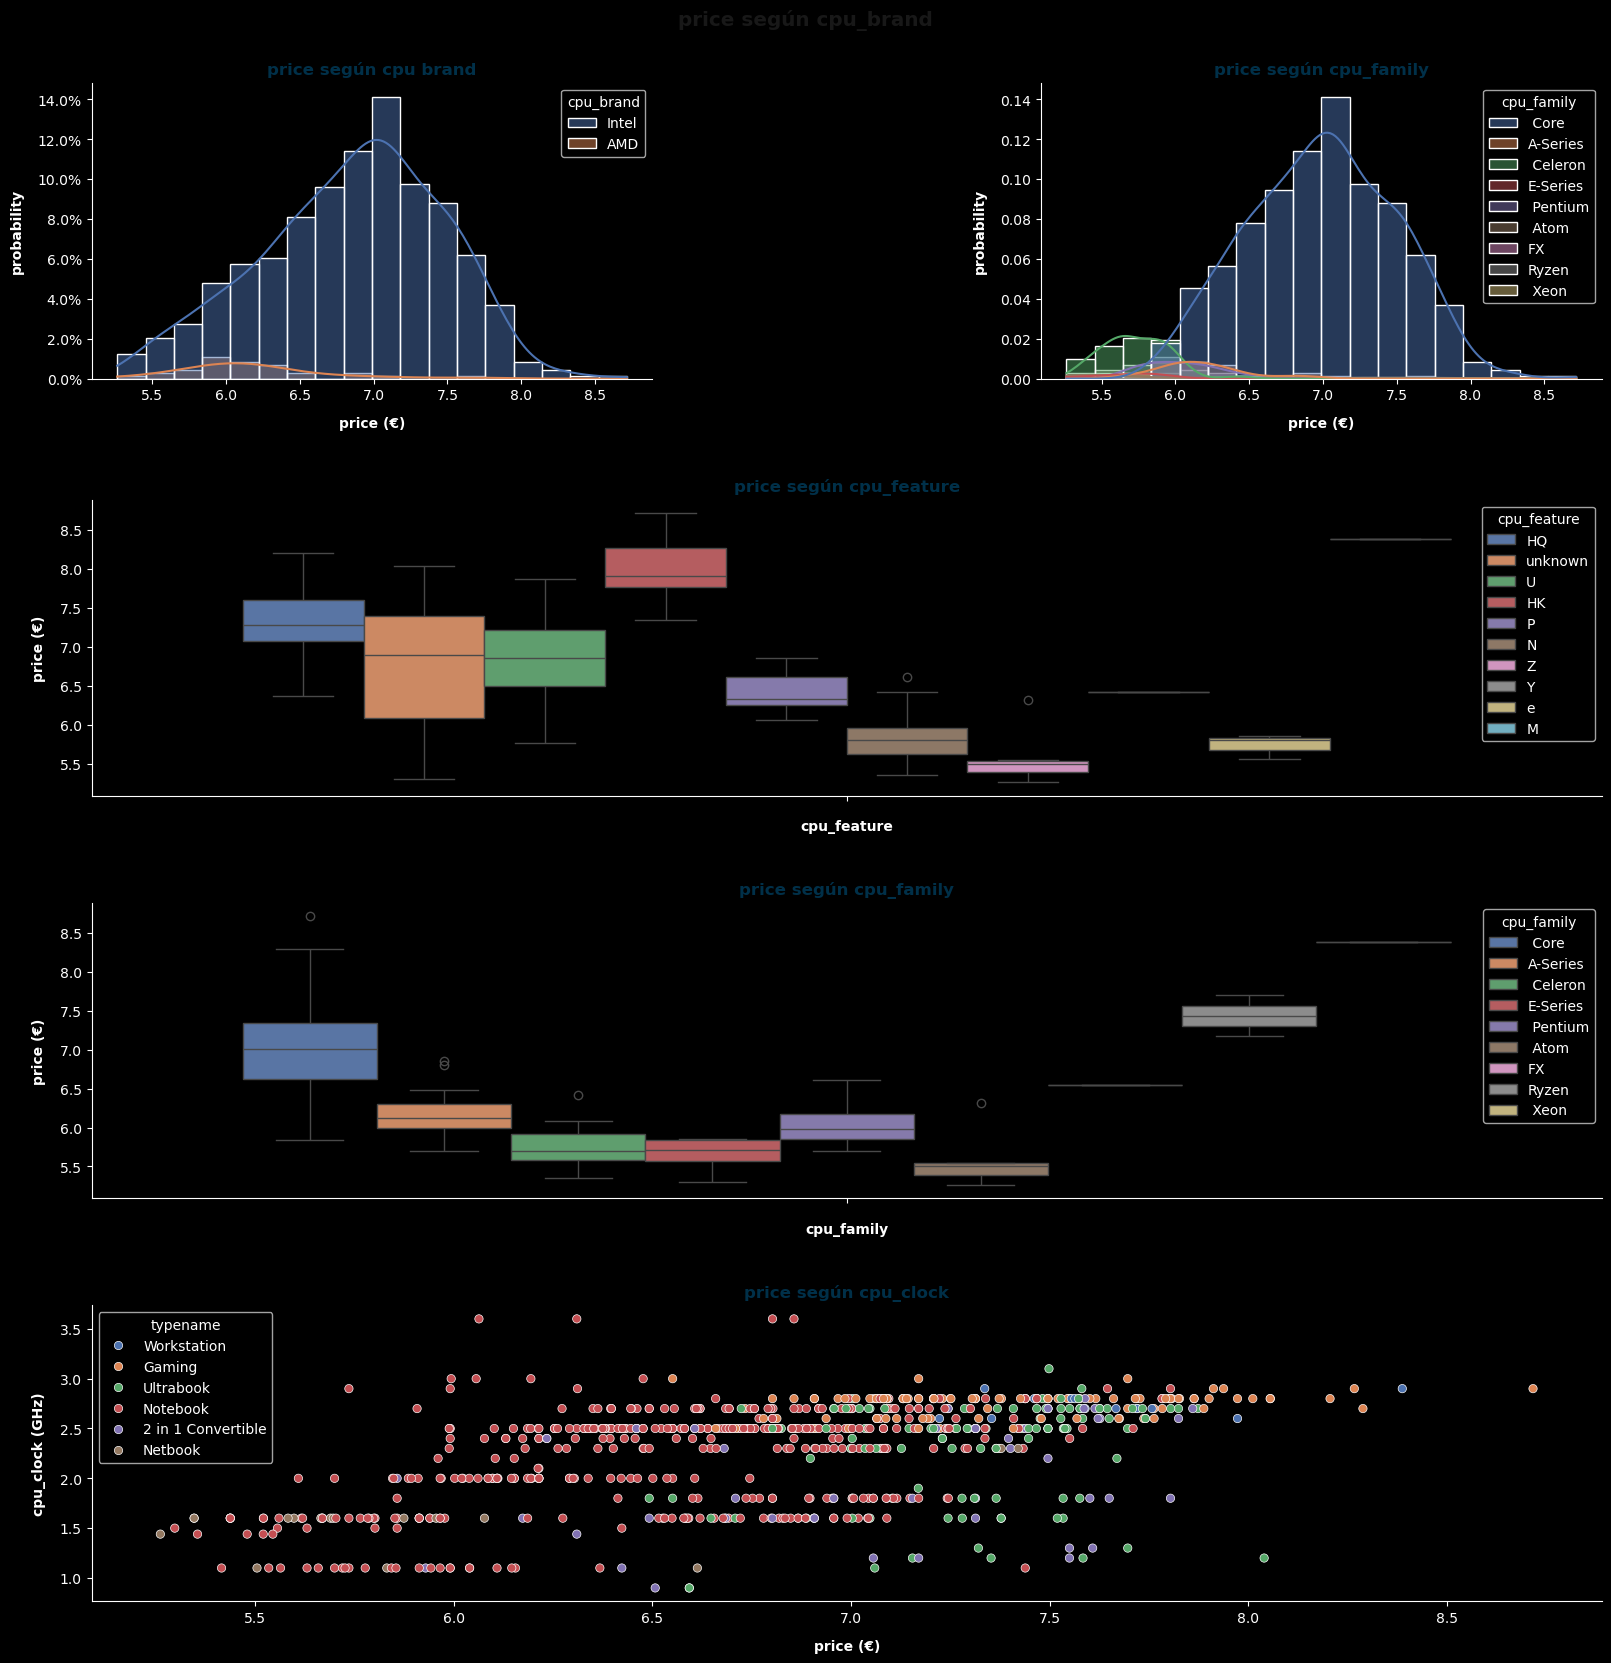

In [210]:
fig = plt.figure(figsize=(16, 16), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "family"],
	["feature", "feature"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_brand",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según cpu brand",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según cpu_family",
								 color="#003049",
								 fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_family",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["family"])
sns.despine(ax=axs["family"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["feature"].set_title("price según cpu_feature",
						 color="#003049",
						 fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_feature",
			palette="deep",
			ax=axs["feature"])
sns.despine(ax=axs["feature"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["feature"].set_xlabel("cpu_feature", labelpad=10, fontdict=font_config)
axs["feature"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según cpu_family",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_family",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("cpu_family",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según cpu_clock",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y="cpu_clock",
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("cpu_clock (GHz)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Aquí podemos observar que existe una correlación entre el `price` del dispositivo y la velocidad del procesador `cpu_clock`. También podemos notar como el fabricante del cpu al igual que la familia del mismo tiene una influencia en el precio.

In [ ]:
df_train.groupby(by=["cpu_model"])["log_price"].agg(
	["count", "mean", "median", "std", "var"]
).sort_values(by="median", ascending=False)

count      mean    median       std       var
cpu_model                                               
1535           1  8.387085  8.387085       NaN       NaN
7820           7  7.945346  7.912057  0.443318  0.196531
6820          10  7.749275  7.738082  0.238389  0.056830
6600           8  7.631098  7.623977  0.111347  0.012398
7Y75           3  7.617917  7.607928  0.073810  0.005448
7Y54           1  7.549609  7.549609       NaN       NaN
7660           1  7.495542  7.495542       NaN       NaN
6560           1  7.495542  7.495542       NaN       NaN
7600           8  7.429123  7.474745  0.242375  0.058745
6Y54           1  7.438384  7.438384       NaN       NaN
1700           2  7.433166  7.433166  0.372004  0.138387
7700          82  7.397271  7.402466  0.336274  0.113080
6Y75           4  7.462383  7.376938  0.446540  0.199398
7Y57           1  7.352441  7.352441       NaN       NaN
7560           2  7.229839  7.229839  0.000000  0.000000
6440           1  7.222566  7.222566       NaN       NaN
6500          35  7.076841  7.207860  0.397797  0.158242
6700          22  7.287486  7.196680  0.364836  0.133105
8650           1  7.169350  7.169350       NaN       NaN
unknown       13  7.234141  7.154615  0.324754  0.105465
6260           1  7.090077  7.090077       NaN       NaN
7440           3  7.054089  7.073270  0.053224  0.002833
7500          78  7.098146  7.045775  0.403995  0.163212
6300          10  7.098905  7.043227  0.350221  0.122655
8550          41  7.031653  7.031149  0.338364  0.114491
6200          40  6.958946  7.002150  0.350560  0.122893
7300          18  6.984599  6.950294  0.242375  0.058745
7Y30           1  6.897705  6.897705       NaN       NaN
8250          46  6.860658  6.823818  0.276849  0.076645
7200         101  6.734868  6.722630  0.357464  0.127781
6Y30           3  6.564456  6.593045  0.049517  0.002452
6100           6  6.608393  6.579676  0.387642  0.150266
9830           1  6.551080  6.551080       NaN       NaN
7130           6  6.342582  6.396930  0.224056  0.050201
9620           1  6.356108  6.356108       NaN       NaN
4405           2  6.318928  6.318928  0.147530  0.021765
9410           1  6.311717  6.311717       NaN       NaN
9720           5  6.461087  6.309918  0.349620  0.122234
7100          17  6.342167  6.306275  0.230250  0.053015
9600           1  6.214608  6.214608       NaN       NaN
6006          45  6.188030  6.152733  0.209612  0.043937
7410           2  6.056869  6.056869  0.135572  0.018380
9420           5  6.142718  6.056784  0.204199  0.041697
4200          11  6.029788  5.991440  0.287166  0.082464
9220           6  6.010558  5.990827  0.169657  0.028784
3700           1  5.977594  5.977594       NaN       NaN
3710          10  5.965798  5.939825  0.187118  0.035013
3450           2  5.939825  5.939825  0.037225  0.001386
3050           9  5.725946  5.913503  0.240360  0.057773
7110           1  5.857933  5.857933       NaN       NaN
9000           3  5.738960  5.802118  0.160181  0.025658
3160           1  5.786897  5.786897       NaN       NaN
3350          17  5.787947  5.777621  0.251575  0.063290
3855           1  5.765191  5.765191       NaN       NaN
7310           1  5.700444  5.700444       NaN       NaN
3060          21  5.661217  5.669536  0.183359  0.033620
8350           5  5.432938  5.480639  0.120181  0.014444
6110           2  5.464747  5.464747  0.235367  0.055397

In [252]:
df_train.groupby(
	by=["cpu_brand", "cpu_feature"]
)["log_price"].agg(["count", "mean", "median", "var", "std"])

count      mean    median       var       std
cpu_brand cpu_feature                                               
AMD       P                8  6.428404  6.333013  0.080037  0.282909
          e                3  5.738960  5.802118  0.025658  0.160181
          unknown         20  6.127830  5.992713  0.273318  0.522798
Intel     HK               9  7.978860  7.912057  0.158291  0.397858
          HQ             132  7.325606  7.278189  0.134092  0.366186
          M                1  8.387085  8.387085       NaN       NaN
          N               72  5.811721  5.800606  0.065652  0.256227
          U              450  6.853280  6.854352  0.213344  0.461892
          Y                1  6.423247  6.423247       NaN       NaN
          Z                6  5.579102  5.500850  0.139737  0.373814
          unknown         27  7.247356  7.320527  0.159190  0.398986

La varianza y la desvición estandar en los distintos modelos normalmente es constinte.

> No le hemos podido sacar demasiado partido a la generación del `cpu`. Como una posible línea de trabajo futura, es algo a lo que se le debería hacer foco para conseguir un mejor rendimiento del modelo.

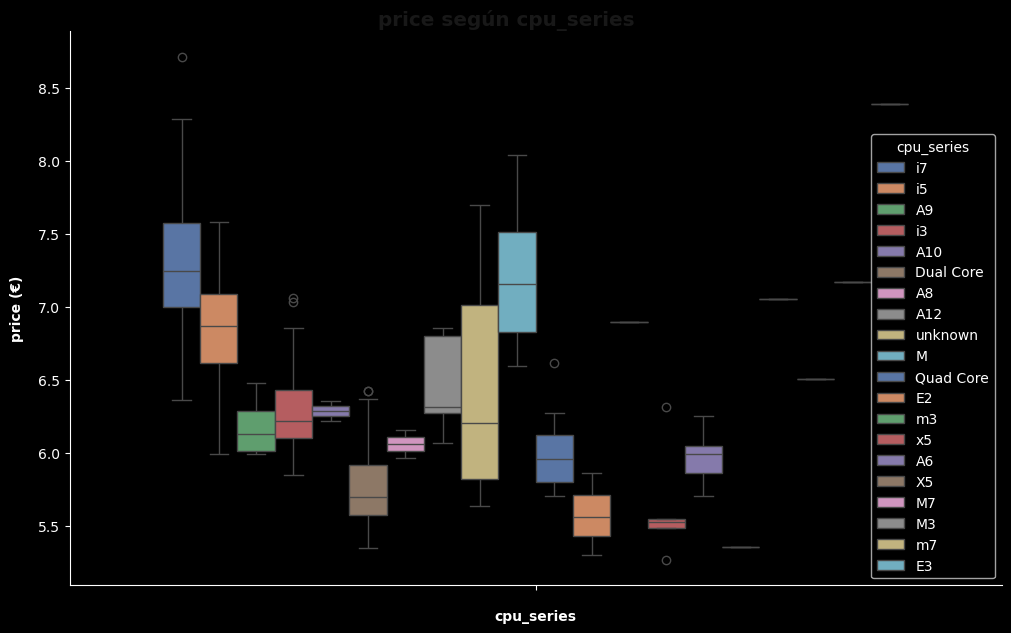

In [230]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_series",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_series",
			palette="deep",
			ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("cpu_series", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

#### Distribución de `Price` según `RAM`

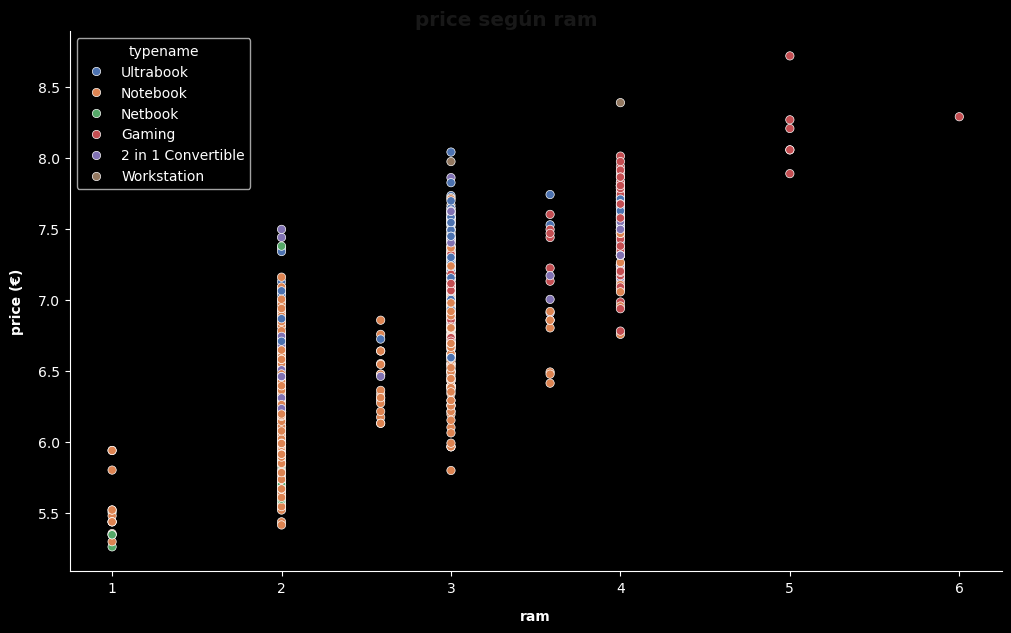

In [231]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según ram",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x=np.log2(df["ram_size"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("ram", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

Podemos observar que hay una correlación muy fuerte entre la cantidad de memoria del dispositivo y su precio.

#### Distribución de `Price` según `HDD`

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


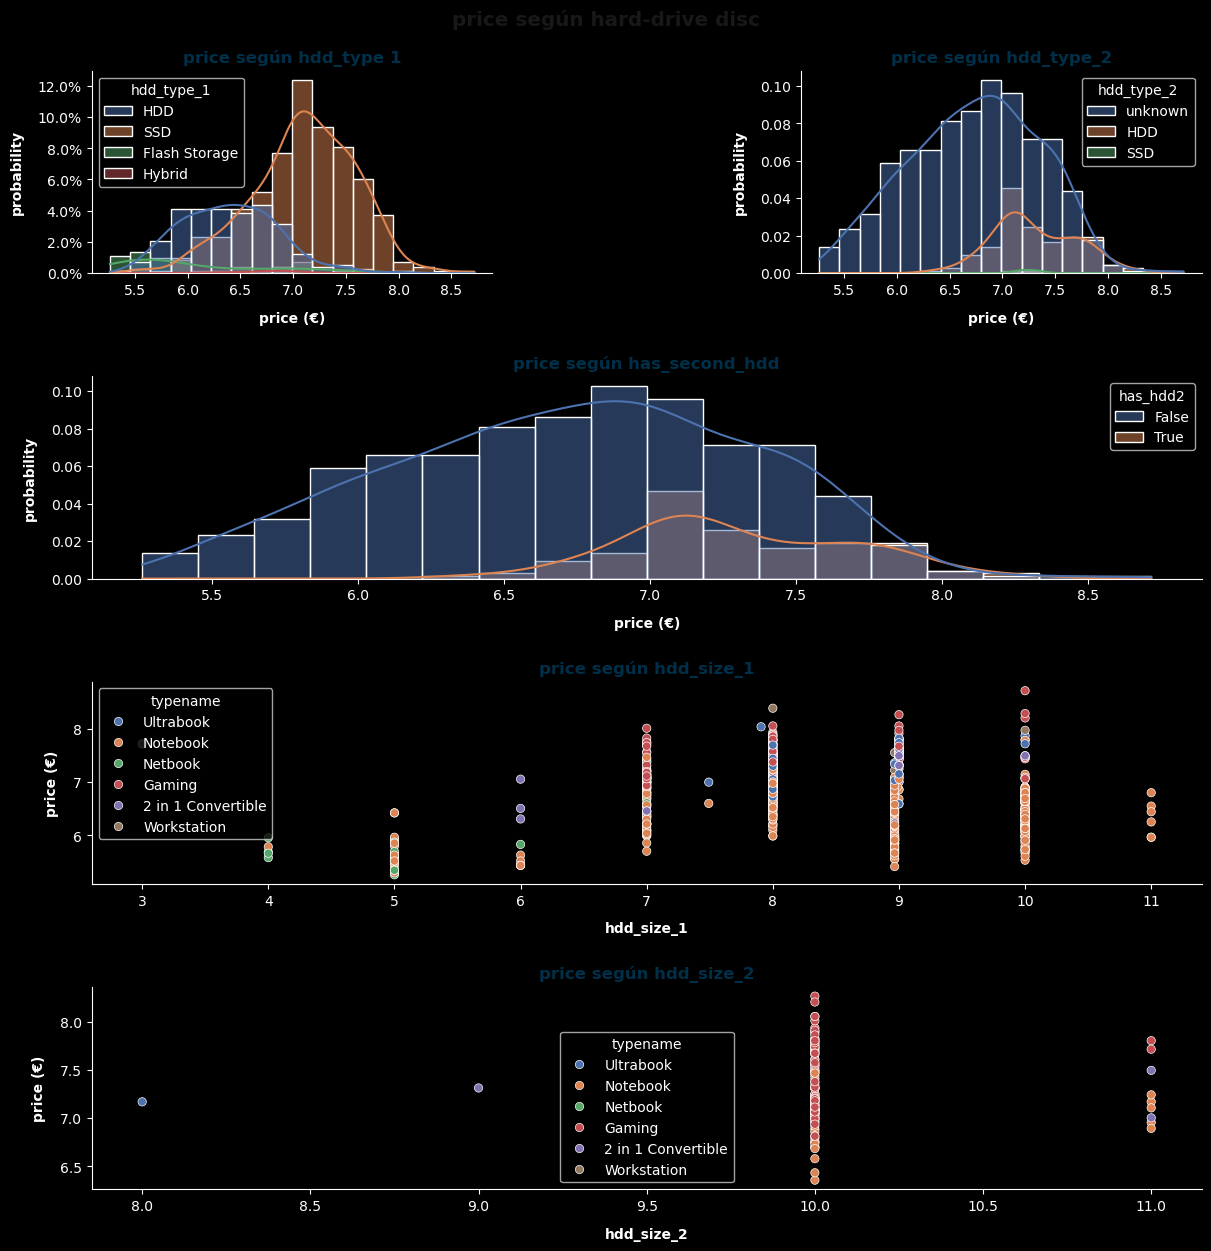

In [232]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["hdd_type_1", "hdd_type_2"],
	["has_second_hdd", "has_second_hdd"],
	["hdd_capacity_1", "hdd_capacity_1"],
	["hdd_capacity_2", "hdd_capacity_2"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según hard-drive disc",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_1"].set_title("price según hdd_type 1",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_1",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_1"])
sns.despine(ax=axs["hdd_type_1"])
axs["hdd_type_1"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_1"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_2"].set_title("price según hdd_type_2",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_2"])
sns.despine(ax=axs["hdd_type_2"])
axs["hdd_type_2"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_2"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_2"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_second_hdd"].set_title("price según has_second_hdd",
								color="#003049",
								fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_hdd2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_second_hdd"])
sns.despine(ax=axs["has_second_hdd"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_second_hdd"].set_xlabel("price (€)",
								 labelpad=10,
								 fontdict=font_config)
axs["has_second_hdd"].set_ylabel("probability",
								 labelpad=10,
								 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_1"].set_title("price según hdd_size_1",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_1"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_1"])
sns.despine(ax=axs["hdd_capacity_1"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_1"].set_xlabel("hdd_size_1",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_1"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_2"].set_title("price según hdd_size_2",
								color="#003049",
								fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_2"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_2"])
sns.despine(ax=axs["hdd_capacity_2"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_2"].set_xlabel("hdd_size_2",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_2"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

Luego de haber realizado el análisis de la información en el `hard-drive disc` podemos ver que el tipo de hdd puede influir en el precio. Lo mismo sucede en caso de que contemos con notebooks con dos `hdd`.

Diferente es lo que pasa al tamaño del hdd. Antes, habiamos visto una fuerte correlación entre el tamaño de la memoria `RAM` y el precio del dispositivo, en este caso, la capacidad del disco no tiene tanta relevancia.

In [237]:
np.corrcoef(df_train["log_price"], np.log2(df_train["hdd_size_1"]))

array([[1.        , 0.07800824],
       [0.07800824, 1.        ]])

#### Distribución de `Price` según `GPU`

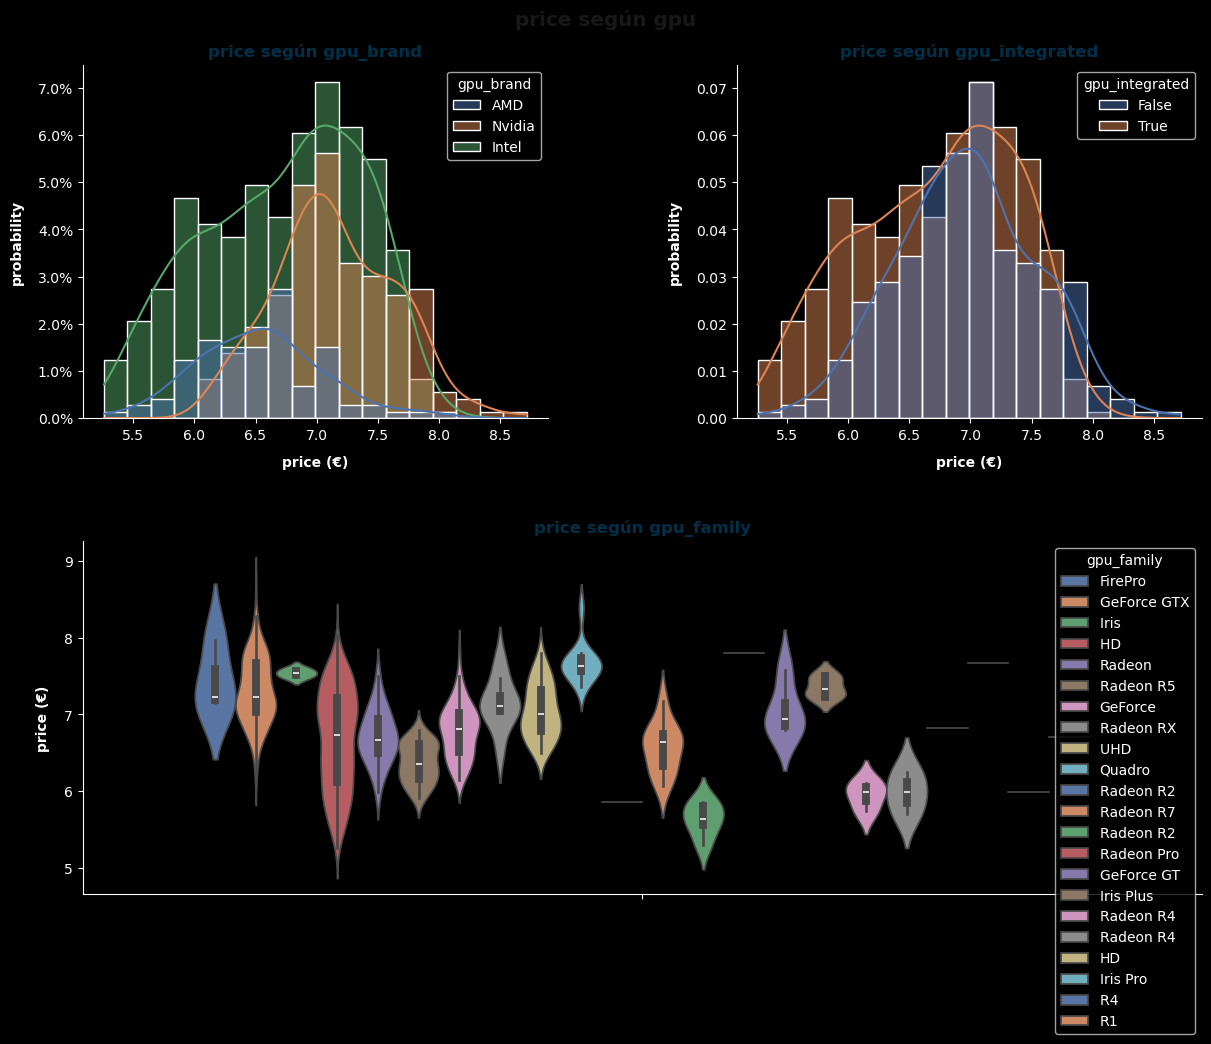

In [238]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "integrated"],
	["family", "family"],
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según gpu",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según gpu_brand",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["integrated"].set_title("price según gpu_integrated",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_integrated",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["integrated"])
sns.despine(ax=axs["integrated"])
axs["integrated"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["integrated"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["integrated"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según gpu_family",
						color="#003049",
						fontdict=font_config)
sns.violinplot(data=df_train,
			y="log_price",
			hue="gpu_family",
			palette="deep",
			ax=axs["family"])
sns.despine(ax=axs["family"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_ylabel("gpu_family", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

In [239]:
df_train.groupby(by=["gpu_brand", "gpu_family"])["log_price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

count      mean       min       max    median  \
gpu_brand gpu_family                                                   
AMD       Radeon R2        5  5.629275  5.298317  5.857933  5.631176   
          Radeon R2        1  5.857933  5.857933  5.857933  5.857933   
          Radeon R4        3  5.981078  5.700444  6.253829  5.988961   
          Radeon R4        3  5.943032  5.736572  6.102335  5.990189   
          R4               1  5.991465  5.991465  5.991465  5.991465   
          Radeon R5       30  6.367992  5.910797  6.797940  6.350872   
          Radeon R7       10  6.565822  6.063785  7.168572  6.642878   
          Radeon          26  6.706586  5.991465  7.495542  6.669031   
          R1               1  6.701960  6.701960  6.701960  6.701960   
Intel     HD             365  6.667424  5.262172  8.039480  6.733402   
Nvidia    GeForce         73  6.783609  6.146329  7.802209  6.803505   
Intel     HD               1  6.824374  6.824374  6.824374  6.824374   
Nvidia    GeForce GT       4  7.060634  6.797952  7.572503  6.936040   
Intel     UHD             43  7.045411  6.492240  7.803843  7.003065   
AMD       Radeon RX        8  7.145707  6.551080  7.696213  7.109430   
          FirePro          3  7.447268  7.146772  7.972466  7.222566   
Nvidia    GeForce GTX    131  7.305671  6.152733  8.716044  7.223223   
Intel     Iris Plus        5  7.355897  7.229839  7.498094  7.326170   
          Iris             2  7.538095  7.495542  7.580649  7.538095   
Nvidia    Quadro          12  7.677229  7.353722  8.387085  7.635833   
Intel     Iris Pro         1  7.669014  7.669014  7.669014  7.669014   
AMD       Radeon Pro       1  7.800151  7.800151  7.800151  7.800151   

                            std       var  
gpu_brand gpu_family                       
AMD       Radeon R2    0.221892  0.049236  
          Radeon R2         NaN       NaN  
          Radeon R4    0.276777  0.076605  
          Radeon R4    0.187386  0.035113  
          R4                NaN       NaN  
          Radeon R5    0.254068  0.064551  
          Radeon R7    0.325198  0.105754  
          Radeon       0.345955  0.119685  
          R1                NaN       NaN  
Intel     HD           0.652445  0.425685  
Nvidia    GeForce      0.353023  0.124625  
Intel     HD                NaN       NaN  
Nvidia    GeForce GT   0.351684  0.123681  
Intel     UHD          0.351838  0.123790  
AMD       Radeon RX    0.335948  0.112861  
          FirePro      0.456411  0.208311  
Nvidia    GeForce GTX  0.444382  0.197475  
Intel     Iris Plus    0.134523  0.018096  
          Iris         0.060180  0.003622  
Nvidia    Quadro       0.255671  0.065368  
Intel     Iris Pro          NaN       NaN  
AMD       Radeon Pro        NaN       NaN

#### Correlaciones

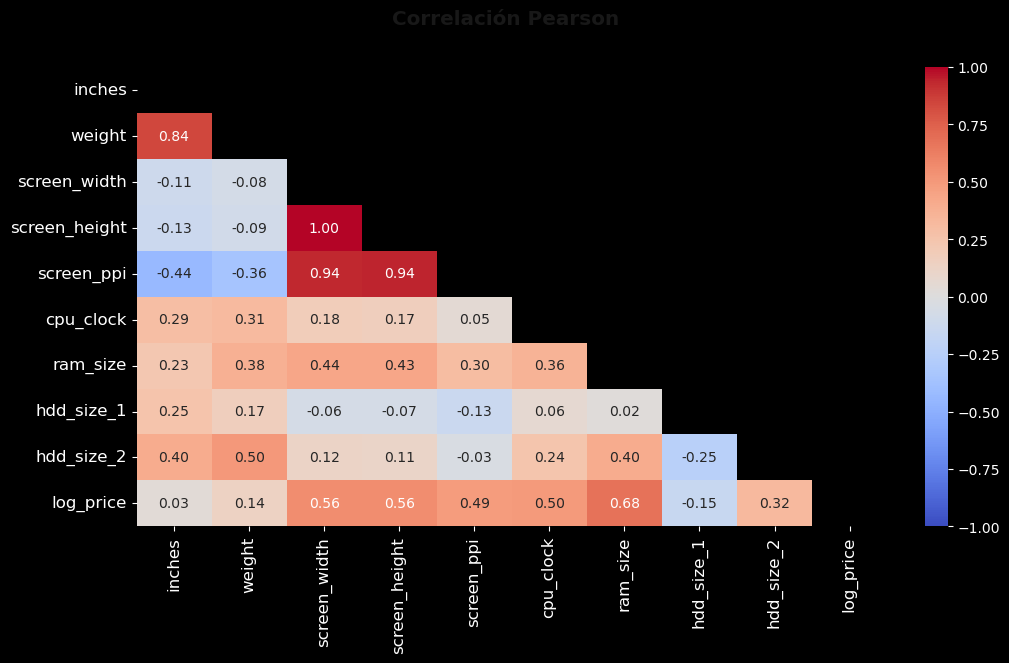

In [243]:
columns = df_train.select_dtypes("number").columns
correlations = df_train[columns.drop(["price"])].corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Correlación Pearson",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.heatmap(data=correlations,
			mask=mask,
			annot=True,
			cmap="coolwarm",
			fmt=".2f",
			center=0,
			linewidths=0,
			vmax=1,
			vmin=-1,
			ax=ax)
ax.set_xticks(ax.get_xticks(),
			  labels=correlations.columns,
			  fontsize=12,
			  rotation=90)
ax.set_yticks(ax.get_yticks(), labels=correlations.columns, fontsize=12)
ax.grid(False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
sns.despine(left=True, bottom=True, ax=ax)
plt.show()

Tomando en cuenta las correlaciones, hay algunas variables que debemos eliminar. Estas son:
- `inches`: tiene poca o nula correlación con `price` y una correlación de 0.84 con `weight`.
- `screen_width`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_hegiht`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_ppi`: tiene mucha colinealidad con `screen_height` y `screen_width`. Dependiendo el rendimiento del modelo eligiremos una u otras.

---

## Procesado de datos

In [244]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
								  OrdinalEncoder, FunctionTransformer

from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, \
									RandomizedSearchCV, RepeatedKFold

In [245]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## **Machine Learning**

### **Baseline de modelos**

In [246]:
def plot_feature_importance(serie: pd.Series):
	fig, ax = plt.subplots(figsize=(16, 14), layout="constrained")

	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}
	fig.suptitle(f"{serie.name}".upper(),
				 color="#002147",
				 fontproperties=font_config,
				 y=1.02)


	rect = ax.barh(y=serie.index,
				   width=serie.values,
				   data=serie,
				   color="#60A5FA",
				   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "small",
		"weight": "medium",
	}
	ax.bar_label(rect, fmt="%.4f", padding=2, fontproperties=font_config)

	font_config = {
		"color": "#002147",
		"family": "sans-serif",
		"horizontalalignment": "center",
		"verticalalignment": "center",
		"size": "large",
		"weight": "bold",
	}
	ax.set_ylabel("features", labelpad=10, fontdict=font_config)
	ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
	ax.grid(axis="y", visible=False)
	ax.grid(axis="x",
			alpha=1,
			color="#D4D4D4",
			linestyle="dashed",
			linewidth=1)
	ax.spines[["left", "bottom", "top", "right"]].set_visible(False)
	ax.spines["left"].set_linewidth(1)
	plt.show()

#### `LinearRegression`, `Ridge` y `Lasso`

In [483]:
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]
columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_model",
	"cpu_feature",
	"hdd_type_1",
	"hdd_type_2",
	"has_hdd2",
#	"gpu_brand",
	"gpu_model"
]

In [420]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

columns_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				min_frequency=11,
				drop="first",
				handle_unknown="ignore"
			),
			columns_to_ohe
		)
	],
	n_jobs=-1
)

In [421]:
linear_regression = LinearRegression(n_jobs=-1)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", linear_regression)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=11),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_model',
                                                                                        'cpu_feature',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'has_hdd2',
                                                                                        'gpu_model'])])),
                                                     ('regressor',
                                                      LinearRegression(n_jobs=-1))]))

#### Features Importances

Ordenada al origen: 6.121261181649457


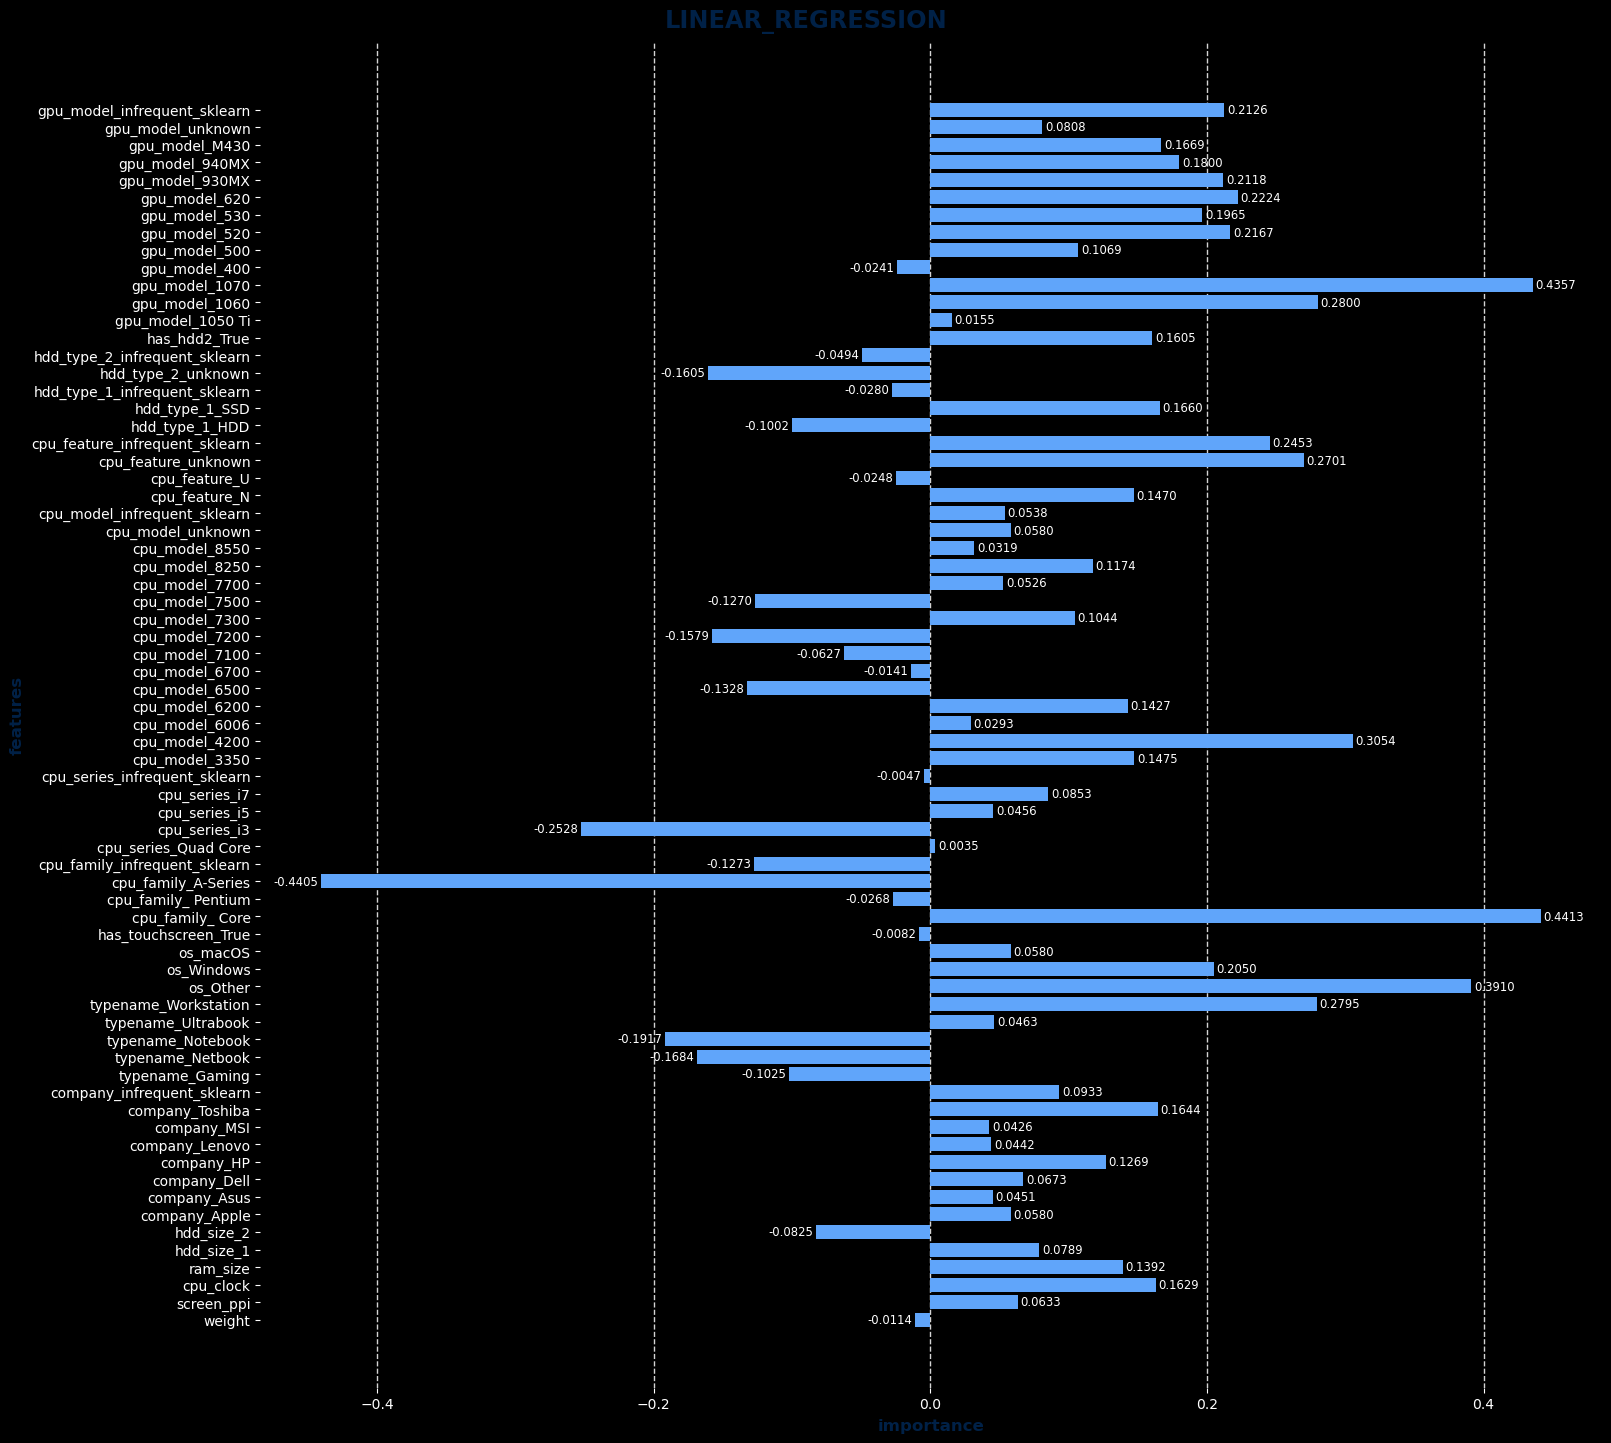

In [422]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded = preprocess["to_encode_ohe"].get_feature_names_out()

index = np.hstack([columns_to_logn, columns_to_log2, columns_encoded])
data = model.regressor_.named_steps["regressor"].coef_.ravel()

data = pd.Series(data, index=index, name="linear_regression")
plot_feature_importance(data)

In [423]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
Train RMSE: 298.444
Train R2: 80.244
--------------------
Test RMSE: 348.142
Test R2: 72.026
--------------------
--------------------
RMSE: 389.83
R2: 0.73
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in colu

##### `ElasticNet`

In [424]:
elastic_net = ElasticNet(
	max_iter=8000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [425]:
params = {
	"regressor__regressor__alpha": [.001, .005, .01, .05, .5, 1, 5, 10],
	"regressor__regressor__l1_ratio": np.logspace(-3, 0, 12)
}

grid_search = GridSearchCV(
	estimator=model,
	param_grid=params,
	cv=kfold,
	refit=True,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2,
)
grid_search.fit(df_train, df_train["price"])

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(n_jobs=-1,
                                                                                               transformers=[('to_logn',
                                                                                                              Pipeline(steps=[('logn',
                                                                                                                               FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                              ('scale',
                                                                                                                               StandardScaler())]),
                                                                                                              ['weight',
                                                                                                               '...
                                                                            ('regressor',
                                                                             ElasticNet(max_iter=8000,
                                                                                        random_state=42))])),
             n_jobs=-1,
             param_grid={'regressor__regressor__alpha': [0.001, 0.005, 0.01,
                                                         0.05, 0.5, 1, 5, 10],
                         'regressor__regressor__l1_ratio': array([0.001     , 0.00187382, 0.00351119, 0.00657933, 0.01232847,
       0.0231013 , 0.04328761, 0.08111308, 0.15199111, 0.28480359,
       0.53366992, 1.        ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [426]:
grid_search.best_params_

{'regressor__regressor__alpha': 0.01,
 'regressor__regressor__l1_ratio': np.float64(0.001)}

In [427]:
elastic_net = ElasticNet(
	alpha=.01,
	l1_ratio=.001,
	max_iter=8000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=11),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_model',
                                                                                        'cpu_feature',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'has_hdd2',
                                                                                        'gpu_model'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.01,
                                                                 l1_ratio=0.001,
                                                                 max_iter=8000,
                                                                 random_state=42))]))

In [428]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
Train RMSE: 309.689
Train R2: 78.739
--------------------
Test RMSE: 334.055
Test R2: 74.355
--------------------
--------------------
RMSE: 384.12
R2: 0.73
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5

### **Trees**

#### `RandomForestRegressor`

In [308]:
from sklearn.ensemble import RandomForestRegressor

In [484]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				min_frequency=11,
				drop="first",
				handle_unknown="ignore"
			),
			columns_to_ohe
		)
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

In [430]:
random_forest = RandomForestRegressor(n_estimators=200,
									  max_depth=10,
									  min_samples_leaf=5,
									  min_samples_split=12,
									  criterion="squared_error",
									  n_jobs=-1,
									  random_state=42)
pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=11),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_model',
                                                                                        'cpu_feature',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'has_hdd2',
                                                                                        'gpu_model'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=10,
                                                                            min_samples_leaf=5,
                                                                            min_samples_split=12,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            random_state=42))]))

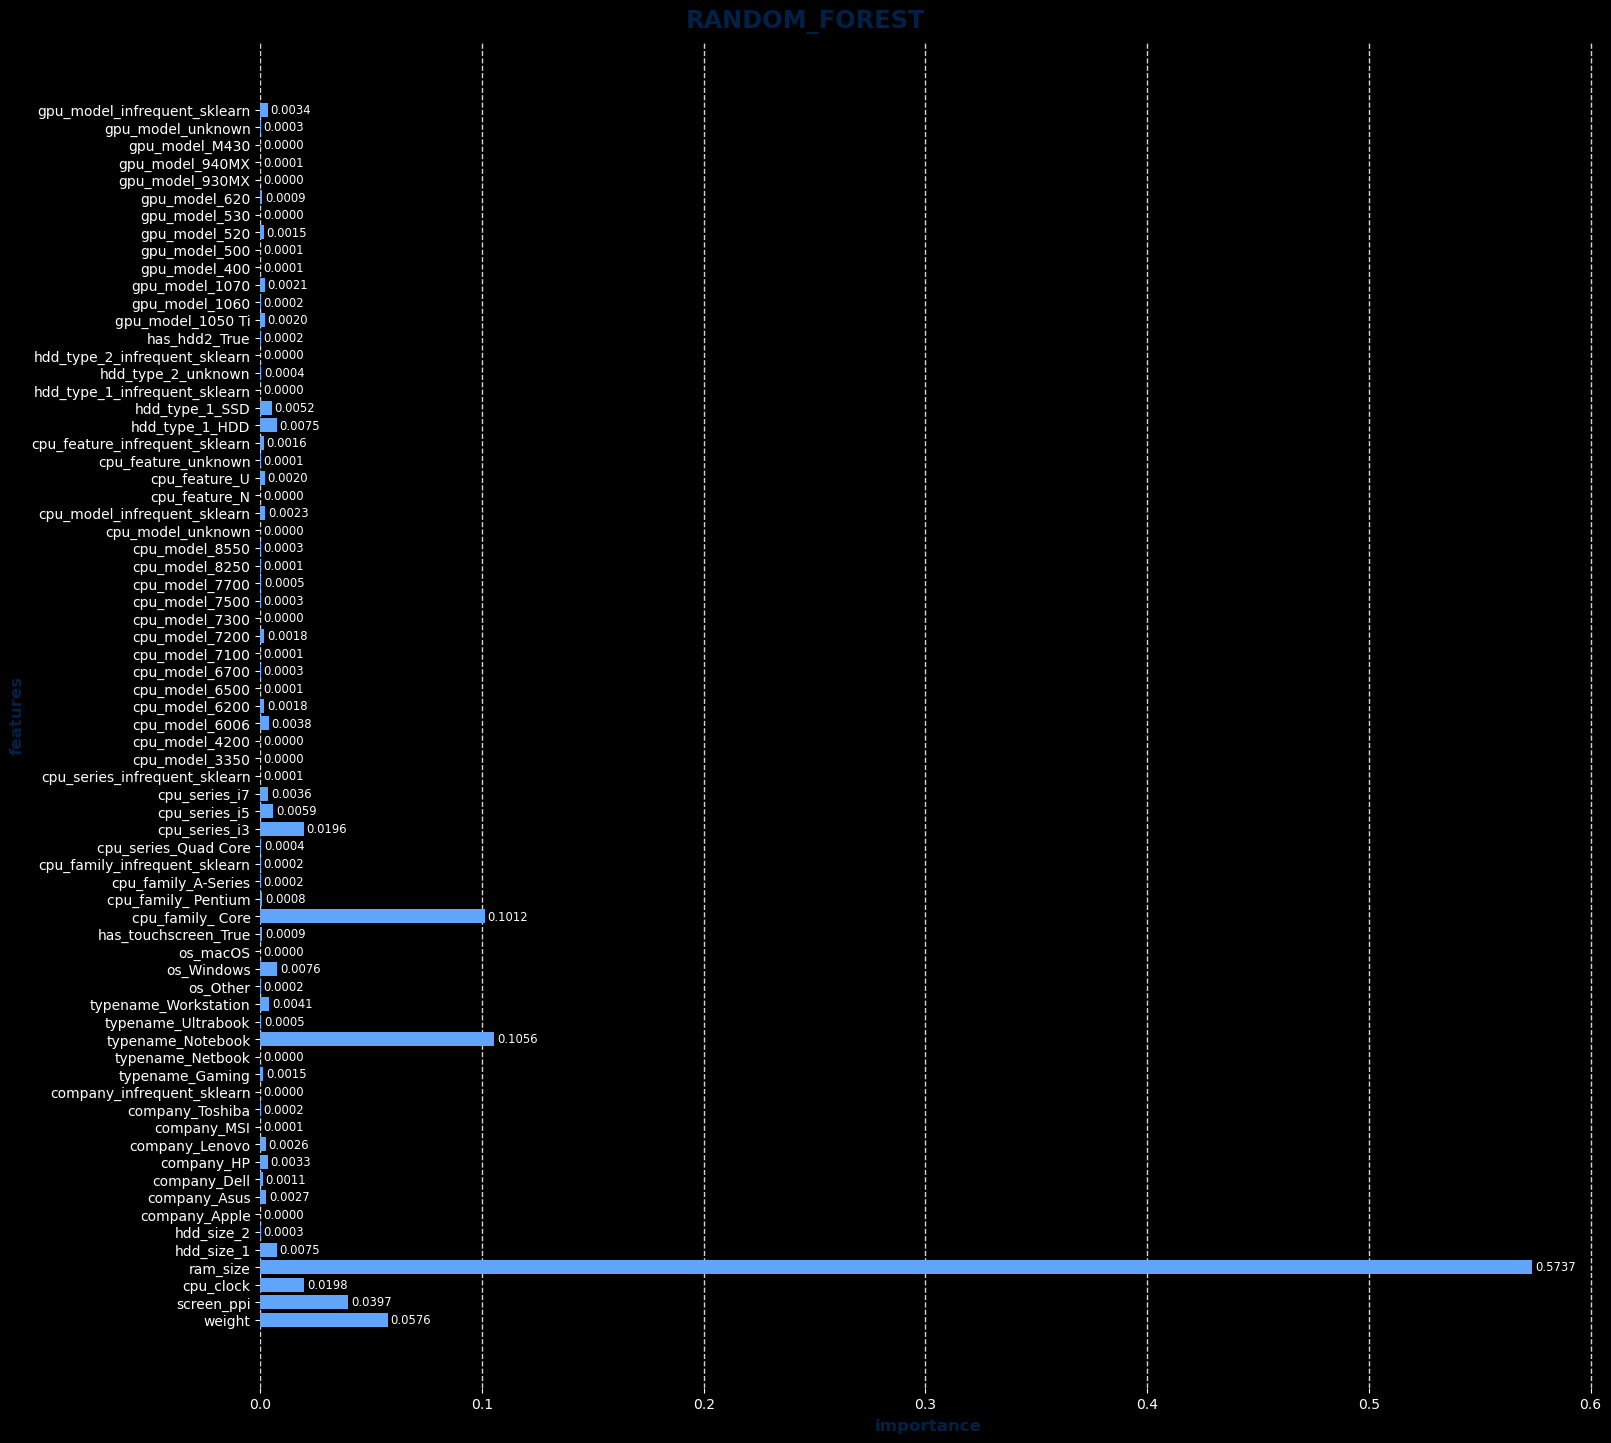

In [431]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="random_forest")
plot_feature_importance(data)

In [432]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)

print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns

--------------------
Train RMSE: 260.574
Train R2: 84.942
--------------------
Test RMSE: 329.259
Test R2: 75.267
--------------------
--------------------
RMSE: 381.98
R2: 0.74
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


El modelo se encuentra sobreajustado a los datos de entrenamiento. La diferencia de error es muy grande, por lo que podemos concluire que el modelo no logra generalizar correctamente.

##### Optuna

Buscamos ajustar los hiperparámetros del **RandomForest** para mejorar el rendimiento.

In [314]:
import optuna

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [433]:
random_forest = RandomForestRegressor(
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	oob_score=True,
	random_state=42
)


pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [434]:
def objective(trial):
	random_forest = RandomForestRegressor(
		n_estimators=trial.suggest_int("n_estimators", 200, 1200, log=True),
		max_depth=trial.suggest_categorical(
			"max_depth", [None] + list(range(4, 40))
		),
		max_features=trial.suggest_categorical(
			"max_features",
			["sqrt", "log2", None, .5, .7]
		),
		min_impurity_decrease=trial.suggest_float(
			"min_impurity_decrease", 0.0, 0.01
		),
		min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
		min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
		bootstrap=trial.suggest_categorical("boostrap", [True, False]),
		criterion="squared_error",
		n_jobs=1,
		random_state=42
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", random_forest)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)

	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)

	return results["test_score"].mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2026-02-21 19:45:38,505] A new study created in memory with name: no-name-aeca80ff-0832-4253-b5b3-cabcb2c1040c
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataSc

{'n_estimators': 1002, 'max_depth': 22, 'max_features': 0.7, 'min_impurity_decrease': 2.2505741104220085e-05, 'min_samples_split': 4, 'min_samples_leaf': 1, 'boostrap': True}


In [435]:
study.best_params

{'n_estimators': 1002,
 'max_depth': 22,
 'max_features': 0.7,
 'min_impurity_decrease': 2.2505741104220085e-05,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'boostrap': True}

In [436]:
random_forest = RandomForestRegressor(
	n_estimators=1002,
	max_depth=22,
	max_features=.7,
	min_impurity_decrease=2.2505741104220085e-05,
	min_samples_split=4,
	min_samples_leaf=1,
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	oob_score=True,
	random_state=42
)


pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                                     min_frequency=11),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_model',
                                                                                        'cpu_feature',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'has_hdd2',
                                                                                        'gpu_model'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=22,
                                                                            max_features=0.7,
                                                                            min_impurity_decrease=2.2505741104220085e-05,
                                                                            min_samples_split=4,
                                                                            n_estimators=1002,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
                                                                            random_state=42))]))

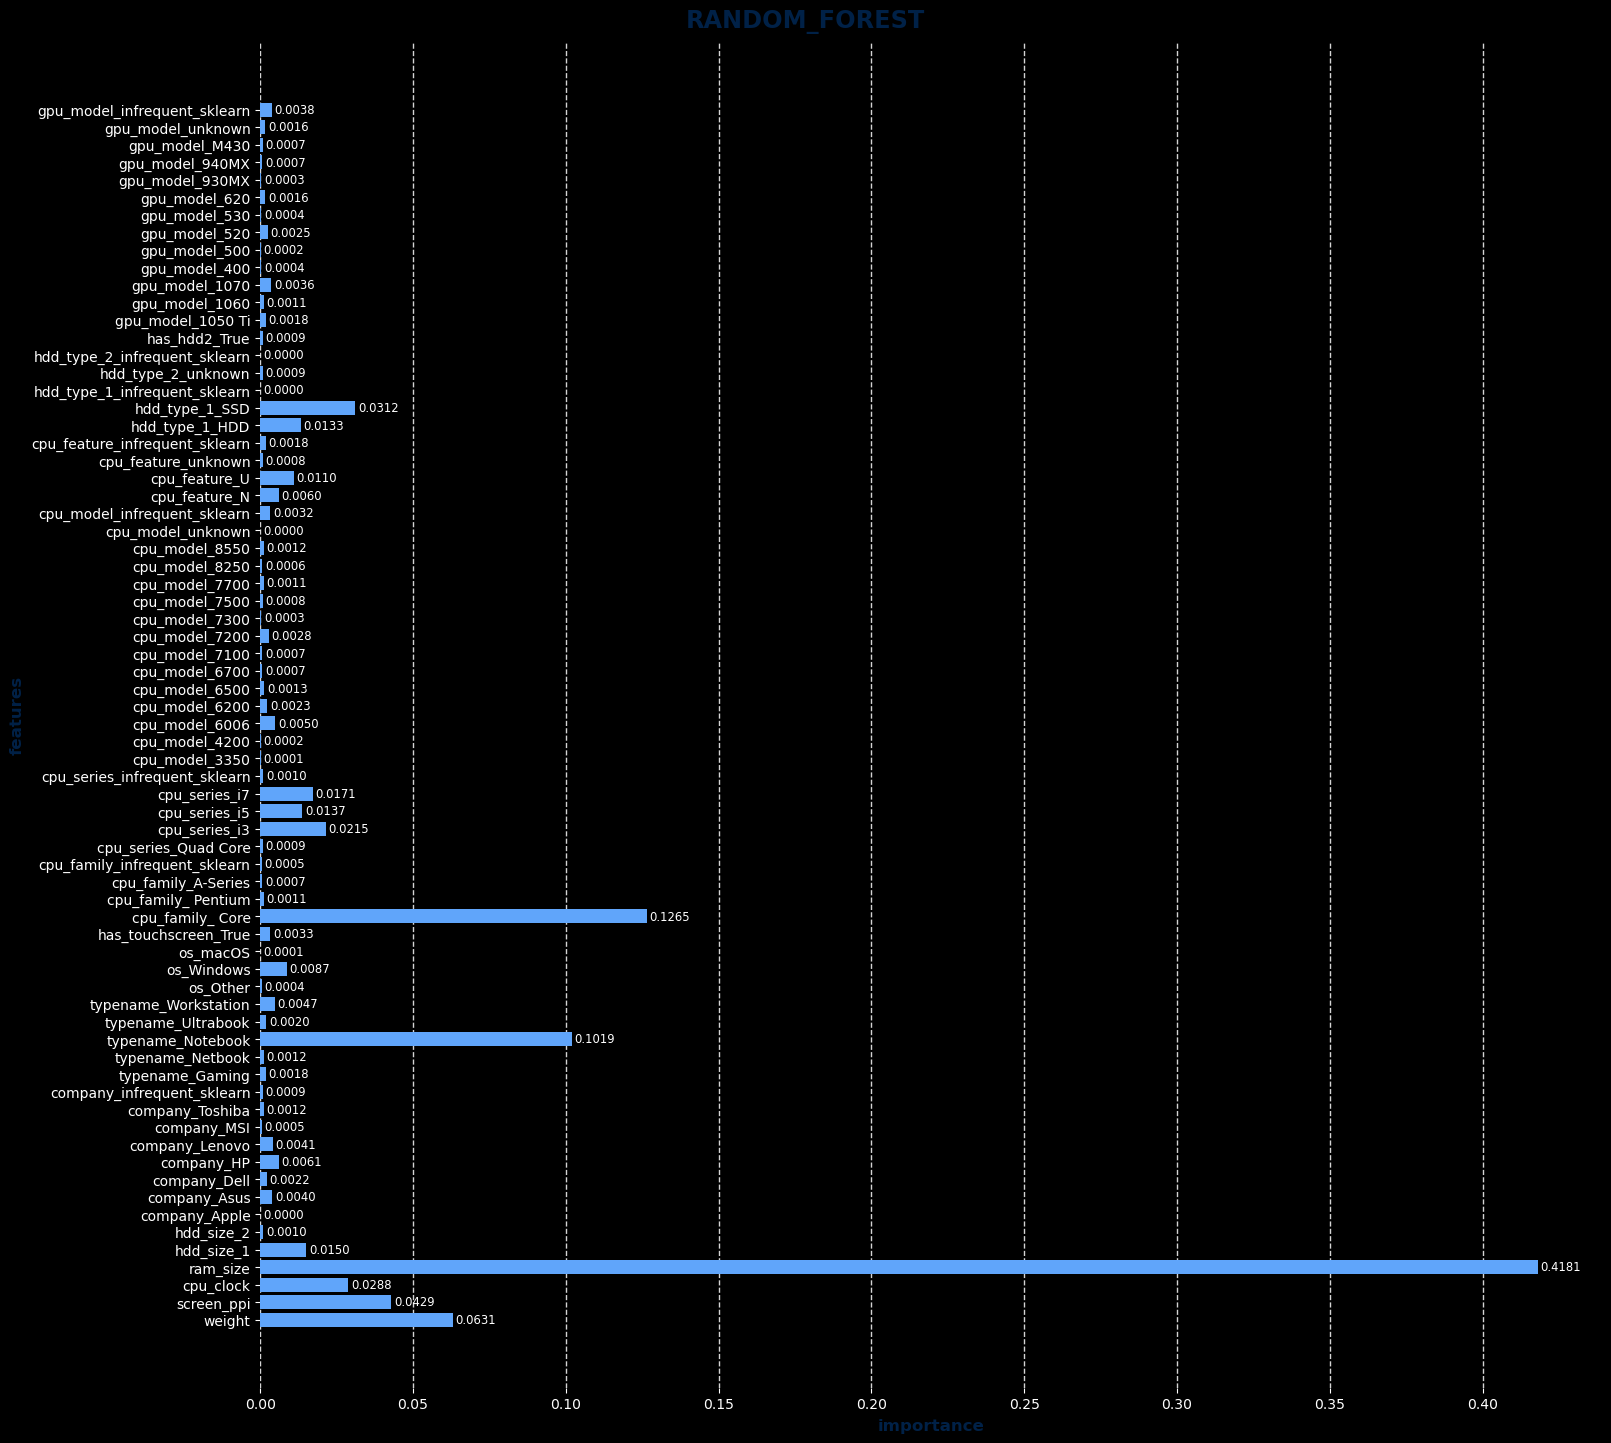

In [437]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="random_forest")
plot_feature_importance(data)

In [438]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns

--------------------
Train RMSE: 152.656
Train R2: 94.818
--------------------
Test RMSE: 295.701
Test R2: 79.812
--------------------
--------------------
RMSE: 344.08
R2: 0.79
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


#### `XGBoost`

In [322]:
from xgboost import XGBRegressor

In [439]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				drop="first",
				handle_unknown="ignore",
				min_frequency=11
			),
			columns_to_ohe
		),
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

##### Optuna

In [442]:
def objective(trial):
	xgboost_regressor = XGBRegressor(
		n_estimators=trial.suggest_int("n_estimators", 200, 2000),
		learning_rate=trial.suggest_float("learning_rate", 0.01, 1, log=True),
		max_depth=trial.suggest_int("max_depth", 2, 8),
		min_child_weight=trial.suggest_int("min_child_weight", 5, 25),
		gamma=trial.suggest_float("gamma", 0.0, 6.0),
		subsample=trial.suggest_float("subsample", 0.6, 1.0),
		colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
		reg_alpha=trial.suggest_float("reg_alpha", 0.0, 3.0),
		reg_lambda=trial.suggest_float("reg_lambda", 0.1, 6.0),
		max_delta_step=trial.suggest_int("max_delta_step", 0, 15),
		eval_metric="rmse",
		objective="reg:squarederror",
		tree_method="hist",
		random_state=42,
		n_jobs=-1
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", xgboost_regressor)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)


	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

print(study.best_params)

[I 2026-02-21 19:51:59,781] A new study created in memory with name: no-name-5576e11e-b093-42d9-85c6-f7163763cea0
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/

{'n_estimators': 1850, 'learning_rate': 0.02809264638304446, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.0005559206902613755, 'subsample': 0.7582604803170268, 'colsample_bytree': 0.6167149734811457, 'reg_alpha': 0.1408021305834669, 'reg_lambda': 2.7837404686024554, 'max_delta_step': 2}


In [443]:
study.best_params

{'n_estimators': 1850,
 'learning_rate': 0.02809264638304446,
 'max_depth': 8,
 'min_child_weight': 6,
 'gamma': 0.0005559206902613755,
 'subsample': 0.7582604803170268,
 'colsample_bytree': 0.6167149734811457,
 'reg_alpha': 0.1408021305834669,
 'reg_lambda': 2.7837404686024554,
 'max_delta_step': 2}

In [445]:
xgboost_regressor = XGBRegressor(
	n_estimators=1050,
	learning_rate=.028,
	max_depth=8,
	min_child_weight=6,
	gamma=.00055,
	subsample=.75,
	colsample_bytree=.616,
	reg_alpha=.14,
	reg_lambda=2.783,
	max_delta_step=2,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                   feature_weights=None,
                                                                   gamma=0.00055,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.028,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=2,
                                                                   max_depth=8,
                                                                   max_leaves=None,
                                                                   min_child_weight=6,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1050,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

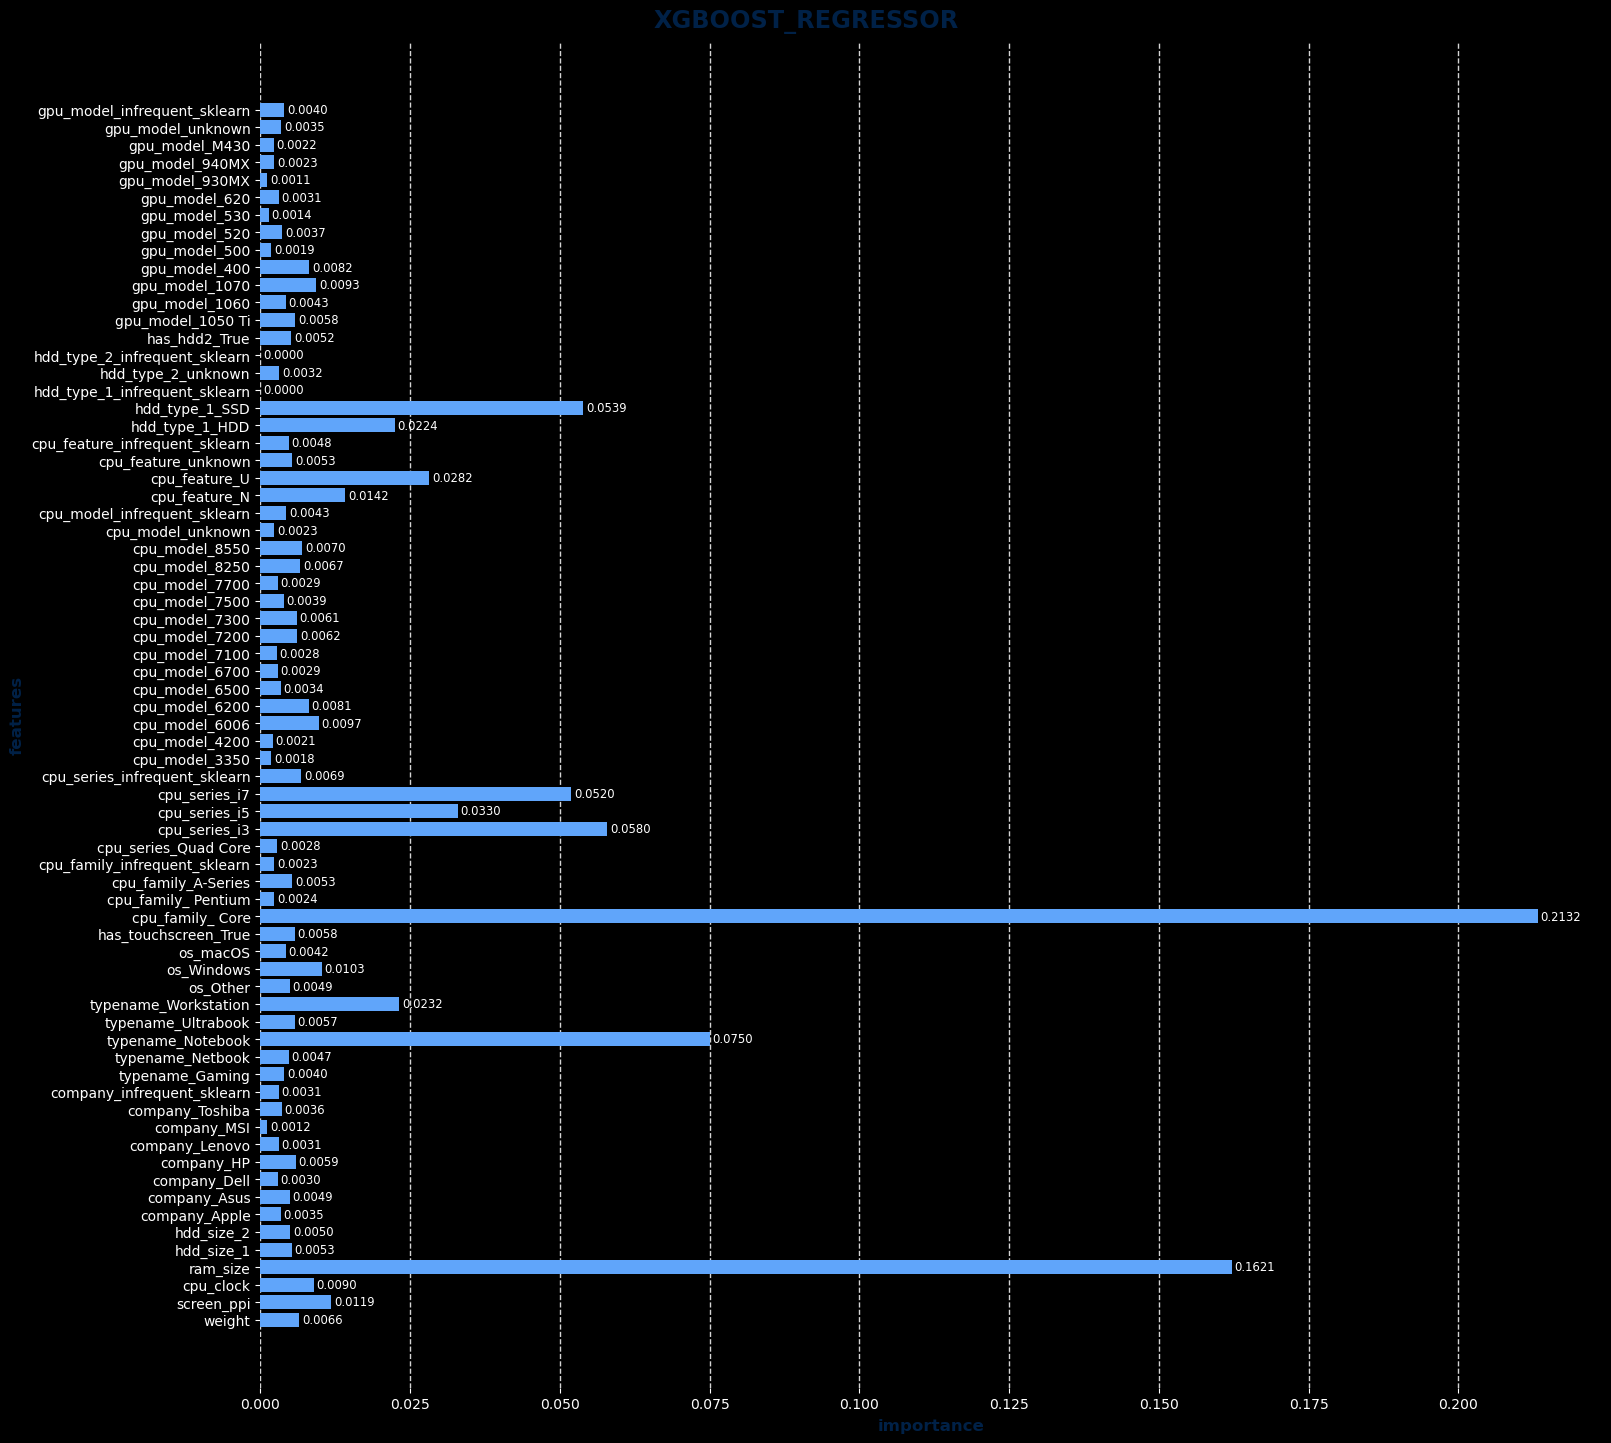

In [446]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="xgboost_regressor")
plot_feature_importance(data)

In [447]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


model.fit(df_train, df_train["price"])
predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5

--------------------
Train RMSE: 74.633
Train R2: 98.755
--------------------
Test RMSE: 281.188
Test R2: 81.878
--------------------
--------------------
RMSE: 299.35
R2: 0.84
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


##### Retunning Best MODEL

Realizamos una búsqueda de hiperparámetros utilizando como base los conseguidos anteriormente.

In [ ]:
best_params = study.best_params
best_params

{'n_estimators': 1850,
 'learning_rate': 0.02809264638304446,
 'max_depth': 8,
 'min_child_weight': 6,
 'gamma': 0.0005559206902613755,
 'subsample': 0.7582604803170268,
 'colsample_bytree': 0.6167149734811457,
 'reg_alpha': 0.1408021305834669,
 'reg_lambda': 2.7837404686024554,
 'max_delta_step': 2}

In [454]:
def objective(trial):
	xgboost_regressor = XGBRegressor(
		n_estimators=trial.suggest_int(
			"n_estimators",
			int(0.8 * 1850),
			int(1.2 * 1850)
		),
		learning_rate=trial.suggest_float(
			"learning_rate",
			0.015,
			0.05,
			log=True
		),
		max_depth=trial.suggest_int("max_depth", 6, 9),
		min_child_weight=trial.suggest_int("min_child_weight", 4, 8),
		gamma=trial.suggest_float(
			"gamma",
			1e-5,
			1e-2,
			log=True
		),
		subsample=trial.suggest_float("subsample", 0.65, 0.85),
		colsample_bytree=trial.suggest_float(
			"colsample_bytree",
			0.55,
			0.75
		),
		reg_alpha=trial.suggest_float("reg_alpha", 0.01, 1.0, log=True),
		reg_lambda=trial.suggest_float("reg_lambda", 1.0, 5.0, log=True),
		max_delta_step=trial.suggest_int("max_delta_step", 0, 5),
		objective="reg:squarederror",
		random_state=42,
		n_jobs=-1
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", xgboost_regressor)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)


	results = cross_validate(
		model,
		df_data,
		df_data["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()

study = optuna.create_study(
	direction="maximize",
	sampler=optuna.samplers.TPESampler(seed=42, multivariate=True)
)
study.enqueue_trial(best_params)
study.optimize(objective, n_trials=100)

print(study.best_params)

/tmp/ipykernel_306629/2403890947.py:64: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  sampler=optuna.samplers.TPESampler(seed=42, multivariate=True)
[I 2026-02-21 20:31:55,091] A new study created in memory with name: no-name-e06a50df-cf3c-43bf-bd20-05bc737c8ca5
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:

{'n_estimators': 2027, 'learning_rate': 0.018560659936019092, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 1.5256045684565366e-05, 'subsample': 0.8359002297488692, 'colsample_bytree': 0.5735945083049485, 'reg_alpha': 0.1325554198201716, 'reg_lambda': 1.0183401419326603, 'max_delta_step': 4}


In [455]:
study.best_params

{'n_estimators': 2027,
 'learning_rate': 0.018560659936019092,
 'max_depth': 9,
 'min_child_weight': 4,
 'gamma': 1.5256045684565366e-05,
 'subsample': 0.8359002297488692,
 'colsample_bytree': 0.5735945083049485,
 'reg_alpha': 0.1325554198201716,
 'reg_lambda': 1.0183401419326603,
 'max_delta_step': 4}

In [485]:
xgboost_regressor = XGBRegressor(
	**study.best_params,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   gamma=1.5256045684565366e-05,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.018560659936019092,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=4,
                                                                   max_depth=9,
                                                                   max_leaves=None,
                                                                   min_child_weight=4,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=2027,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

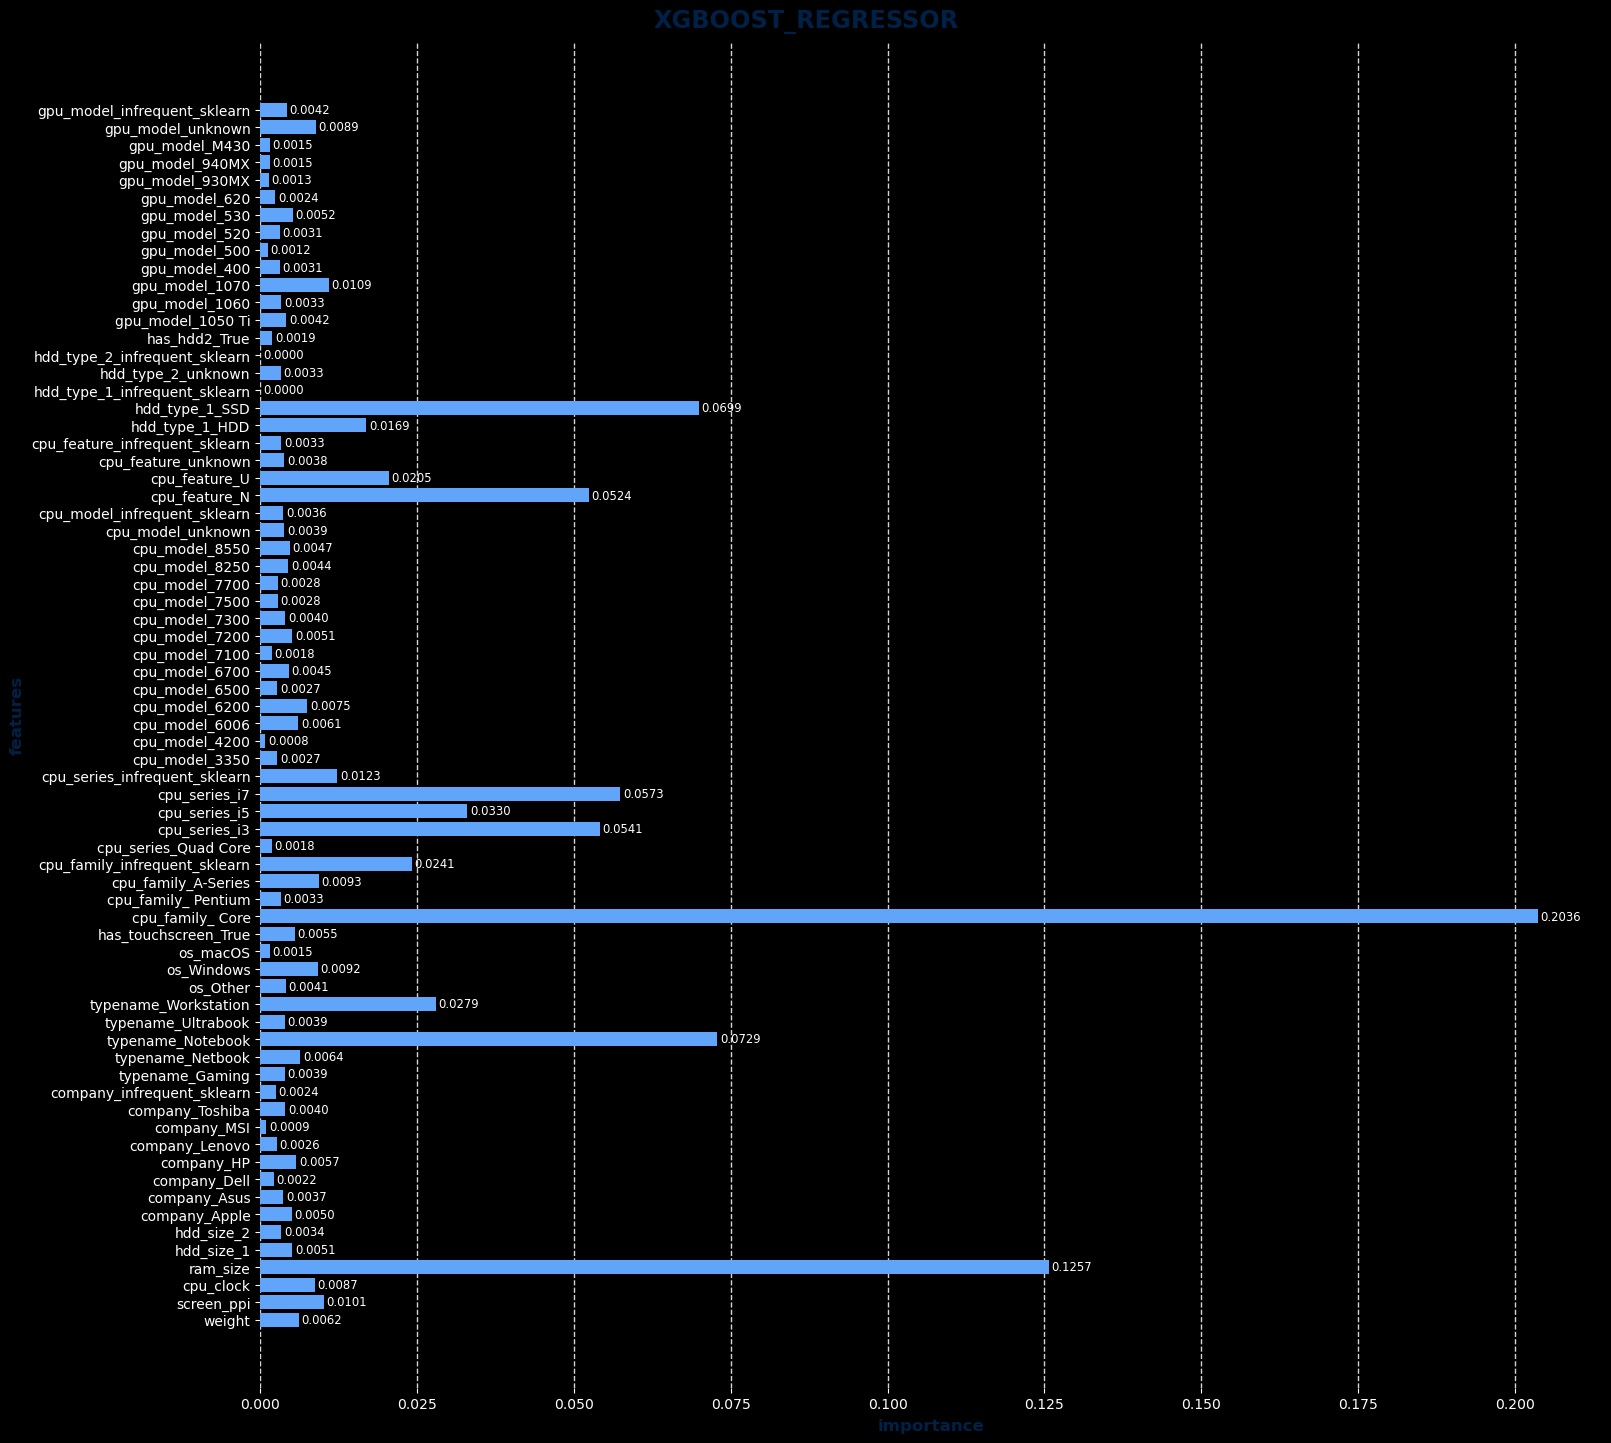

In [486]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="xgboost_regressor")
plot_feature_importance(data)

In [487]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

print()
model.fit(df_train, df_train["price"])
predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in colu

TRAIN
--------------------
RMSE: 274.324
R2: 82.639
--------------------

TEST
--------------------
RMSE: 298.52
R2: 0.84
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


```python
====================
Train RMSE: 48.224
Train R2: 99.481
====================
Test RMSE: 278.613
Test R2: 82.152
====================
RMSE: 292.64
R2: 0.85
====================

### Conclusión

Luego de entrenar varios modelos, me he percatado que es necesario una optimización y un mejor manejo del dataset. De todas maneras, nos encontramos con un modelo muy potente para un dataset muy pequeño, por lo que es común el sobreentrenamiento que se genera en los modelos.



## Miscellaneous
### Mejoras en preprocesamiento

Agrupamos toda la memoria del `hard-disc drive` en una única variable.

In [329]:
df_train["hdd_size"] = (
	df_train["hdd_size_1"] + df_train["hdd_size_2"]
).astype(int)

df_train[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)

hdd_size  hdd_size_1  hdd_size_2
laptop_id                                  
1305           1024        1024         0.0
384              32          32         0.0
1034           1024        1024         0.0
607             256         256         0.0
448             256         256         0.0
42             1280         256      1024.0
1198            256         256         0.0
88              256         256         0.0
378            1280         256      1024.0
40              256         256         0.0

In [330]:
df_test["hdd_size"] = (
	df_test["hdd_size_1"] + df_test["hdd_size_2"]
).astype(int)

df_test[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)

hdd_size  hdd_size_1  hdd_size_2
laptop_id                                  
105            1024        1024         0.0
925             256         256         0.0
385            1024        1024         0.0
287             256         256         0.0
1250           1024        1024         0.0
498             512         512         0.0
133            1024        1024         0.0
41             1024        1024         0.0
988            1280         256      1024.0
1101            256         256         0.0

Reducimos las variables de `os`.

In [ ]:
df_train["os"].unique()

In [331]:
df_train["os"] = df_train["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
df_train.replace(maps, inplace=True).sample(5)

company                                product     typename  \
laptop_id                                                                
1068          Dell                                 XPS 13    Ultrabook   
957        Toshiba                        Tecra A50-C-1ZV     Notebook   
1214        Lenovo    V110-15ISK (i3-6006U/4GB/1TB/Radeon     Notebook   
459             HP                            ProBook 650  Workstation   
508             HP  15-BS026nv (i5-7200U/8GB/256GB/Radeon     Notebook   

           inches       os  weight    price  has_touchscreen screen_panel  \
laptop_id                                                                   
1068         13.3  Windows    1.20  2254.00             True      unknown   
957          15.6  Windows    2.20  1119.00            False      unknown   
1214         15.6  Free OS    1.90   368.00            False      unknown   
459          15.6  Windows    2.31  1534.00            False    IPS Panel   
508          15.6  Windows    1.91   618.99            False      unknown   

          screen_type  ... hdd_type_1  hdd_size_2  hdd_type_2  gpu_brand  \
laptop_id              ...                                                 
1068         Quad HD+  ...        SSD         0.0     unknown      Intel   
957                HD  ...        SSD         0.0     unknown      Intel   
1214               HD  ...        HDD         0.0     unknown        AMD   
459           Full HD  ...        SSD         0.0     unknown      Intel   
508                HD  ...        SSD         0.0     unknown        AMD   

          gpu_family gpu_model gpu_integrated has_hdd2 log_price hdd_size  
laptop_id                                                                  
1068             HD        620           True    False  7.720905     1024  
957              HD        520           True    False  7.021084      256  
1214       Radeon R5      M430          False    False  5.910797     1024  
459              HD        620           True    False  7.336286      512  
508           Radeon       520          False    False  6.429703      256  

[5 rows x 33 columns]

In [332]:
df_test["os"] = df_test["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
df_test.replace(maps, inplace=True).sample(5)

company        product   typename  inches       os  weight    price  \
laptop_id                                                                       
746           MSI     GS63VR 7RF     Gaming    15.6  Windows    1.80  2094.48   
1112          MSI   GS70 Stealth     Gaming    17.3  Windows    2.60  1599.00   
15          Apple    MacBook 12"  Ultrabook    12.0    macOS    0.92  1262.40   
1028           HP    Probook 430   Notebook    13.3  Windows    1.49   800.00   
698          Acer  Chromebook 14   Notebook    14.0    Other    1.45   375.00   

           has_touchscreen screen_panel screen_type  ...     hdd_type_1  \
laptop_id                                            ...                  
746                  False      unknown     Full HD  ...            SSD   
1112                 False      unknown     Full HD  ...            SSD   
15                   False    IPS Panel    Full HD+  ...            SSD   
1028                 False      unknown          HD  ...            HDD   
698                  False      unknown          HD  ...  Flash Storage   

           hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_id                                                             
746            1024.0         HDD     Nvidia  GeForce GTX      1060   
1112              0.0     unknown     Nvidia  GeForce GTX      965M   
15                0.0     unknown      Intel          HD        615   
1028              0.0     unknown      Intel          HD        620   
698               0.0     unknown      Intel          HD        510   

          gpu_integrated has_hdd2 log_price hdd_size  
laptop_id                                             
746                False     True  7.647538     1280  
1112               False    False  7.377759      256  
15                  True    False  7.141562      256  
1028                True    False  6.685861      500  
698                 True    False  5.929589       32  

[5 rows x 33 columns]

Completamos los valores de `gpu_model` que tenemos y tratamos de agrupar para evitar la alta dimensionalidad en el dataset.

Filtramos aquellas `gpu_model` con pocas muestras de nuestro dataset.

In [489]:
counts = df_train["gpu_model"].value_counts()
mask = df_train["gpu_model"].map(counts) < 8
low_freq_gpu_model = df_train.loc[mask, "gpu_model"].unique()

Nos quedamos con nuestro TOP10 de `gpu_model` según mediana.

In [490]:
top10_gpu_model = df_train.groupby("gpu_model")["price"].median().sort_values(ascending=False).head(5).index
top10_gpu_model

Index(['1080', 'M2000M', '980', 'W6150M', '1070'], dtype='str', name='gpu_model')

In [491]:
def recategorization(value):
	if value in top10_gpu_model:
		return value.strip()
	elif value in low_freq_gpu_model:
		return "other"
	else:
		return "unknown"


df_test["gpu_model_recategorization"] = df_test[
	"gpu_model"
].apply(recategorization)

df_train["gpu_model_recategorization"] = df_train[
	"gpu_model"
].apply(recategorization)

Agrupamos las `company` con pocas frequencias en una variable que las agrupe.

In [492]:
df_train["company"].unique()

<StringArray>
[       'HP',      'Dell',     'Apple',       'MSI',    'Lenovo',      'Asus',
   'Toshiba',      'Acer',    'Google',   'Fujitsu', 'Microsoft',  'Mediacom',
   'Samsung',     'Razer',     'Chuwi',    'Xiaomi',      'Vero']
Length: 17, dtype: str

In [493]:
maps = {
	"company": {
		"Fujitsu": "other",
		"Mediacom": "other",
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}

df_test.replace(maps, inplace=True).sample(5)
df_train.replace(maps, inplace=True).sample(5)

company          product            typename  inches       os  \
laptop_id                                                                 
1025           HP    EliteBook 820           Ultrabook    12.5  Windows   
728        Lenovo      ThinkPad X1           Ultrabook    14.0  Windows   
705          Asus  Chromebook Flip  2 in 1 Convertible    12.5    Other   
695          Dell    Inspiron 3567            Notebook    15.6  Windows   
377          Acer         Aspire 3            Notebook    15.6  Windows   

           weight    price  has_touchscreen screen_panel screen_type  ...  \
laptop_id                                                             ...   
1025         1.26  1539.00            False      unknown     Full HD  ...   
728          1.17  1686.64            False    IPS Panel     Quad HD  ...   
705          1.20   669.00             True      unknown     Full HD  ...   
695          2.20   545.67            False      unknown          HD  ...   
377          2.10   426.00            False      unknown          HD  ...   

          hdd_size_2  hdd_type_2  gpu_brand  gpu_family gpu_model  \
laptop_id                                                           
1025             0.0     unknown      Intel         HD        620   
728              0.0     unknown      Intel         HD        520   
705              0.0     unknown      Intel         HD        515   
695              0.0     unknown        AMD   Radeon R5      M430   
377              0.0     unknown        AMD   Radeon R5   unknown   

          gpu_integrated has_hdd2 log_price hdd_size  \
laptop_id                                              
1025                True    False  7.339538      500   
728                 True    False  7.431086      512   
705                 True    False  6.507278       64   
695                False    False  6.303845     1024   
377                False    False  6.056784      128   

          gpu_model_recategorization  
laptop_id                             
1025                         unknown  
728                          unknown  
705                          unknown  
695                          unknown  
377                          unknown  

[5 rows x 34 columns]

#### Retest

In [514]:
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
columns_to_log2 = ["ram_size", "hdd_size"]
columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_feature",
	"hdd_type_1",
	"has_hdd2",
#	"gpu_brand",
	"gpu_model_recategorization"
]

In [515]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				min_frequency=11,
				drop="first",
				handle_unknown="ignore"
			),
			columns_to_ohe
		)
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

In [513]:
best_params = {
	"n_estimators": 2027,
	"learning_rate": 0.018560659936019092,
	"max_depth": 9,
	"min_child_weight": 4,
	"gamma": 1.5256045684565366e-05,
	"subsample": 0.8359002297488692,
	"colsample_bytree": 0.5735945083049485,
	"reg_alpha": 0.1325554198201716,
	"reg_lambda": 1.0183401419326603,
	"max_delta_step": 4
}

In [510]:
xgboost_regressor = XGBRegressor(
	**best_params,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   gamma=1.5256045684565366e-05,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.018560659936019092,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=4,
                                                                   max_depth=9,
                                                                   max_leaves=None,
                                                                   min_child_weight=4,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=2027,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

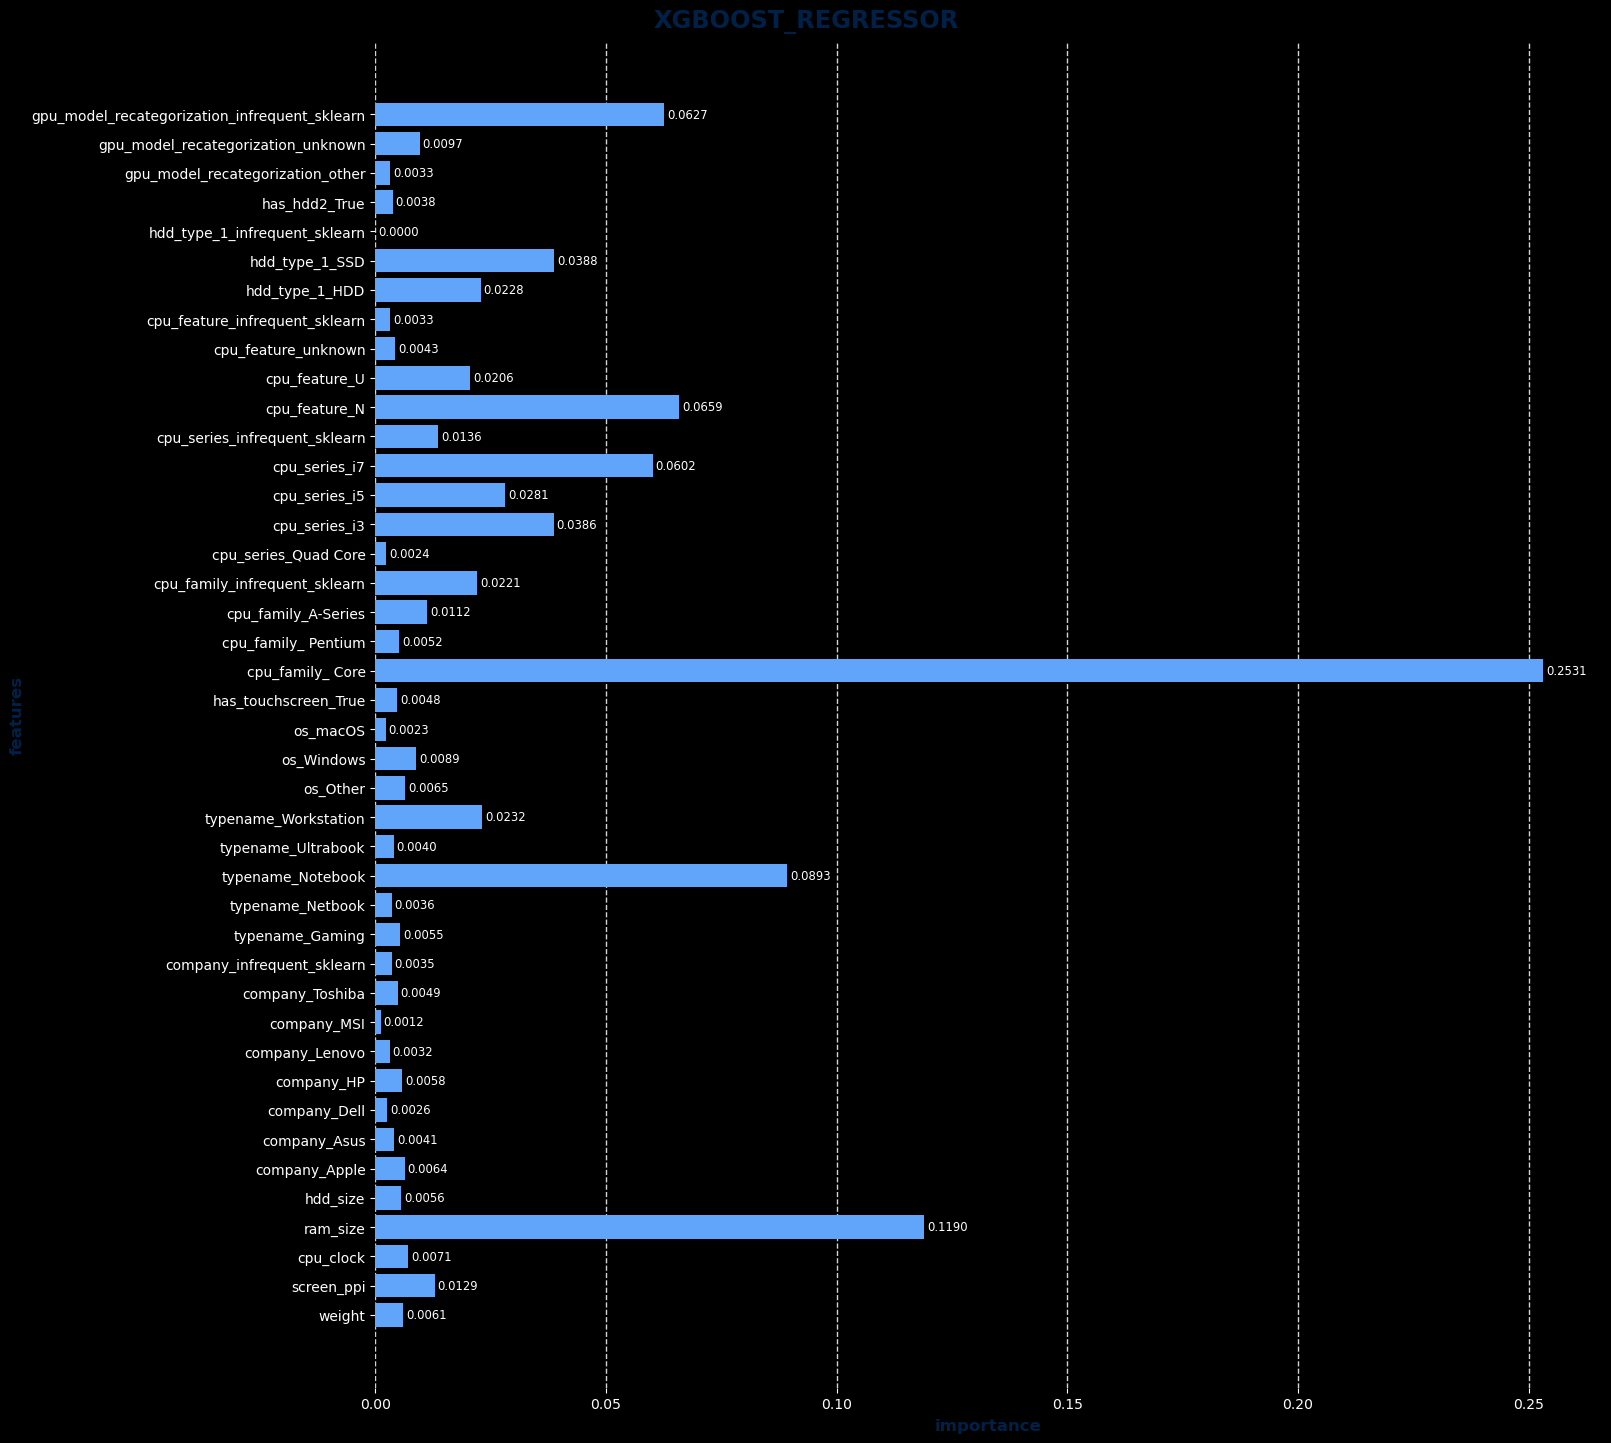

In [519]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()

columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="xgboost_regressor")

plot_feature_importance(data)

In [512]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)

print()

predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
TRAIN
--------------------
RMSE: 260.044
R2: 84.21
--------------------

TEST
--------------------
RMSE: 308.66
R2: 0.83
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6] duri

In [ ]:
--------------------
TRAIN
--------------------
RMSE: 260.044
R2: 84.21
--------------------

TEST
--------------------
RMSE: 308.66
R2: 0.83
--------------------

#### Reentrenamiento

Agregamos nuestra variable al las features seleccionadas y realizamos una nueva búsqueda de hiperparámetros.

In [521]:
df_data = pd.concat([df_train, df_test])
df_data.head()

company        product     typename  inches       os  weight  \
laptop_id                                                                
1118           HP       ZBook 17  Workstation    17.3  Windows    3.00   
153          Dell  Inspiron 5577       Gaming    15.6  Windows    2.56   
275         Apple    MacBook Pro    Ultrabook    13.3    macOS    1.37   
1100           HP  EliteBook 840     Notebook    14.0  Windows    1.54   
131          Dell  Inspiron 5770     Notebook    17.3  Windows    2.80   

             price  has_touchscreen screen_panel screen_type  ... hdd_size_2  \
laptop_id                                                     ...              
1118       2899.00            False    IPS Panel     Full HD  ...        0.0   
153        1249.26            False      unknown     Full HD  ...        0.0   
275        1958.90            False    IPS Panel     Quad HD  ...        0.0   
1100       1030.99            False      unknown     Full HD  ...        0.0   
131        1396.00            False      unknown     Full HD  ...     2048.0   

           hdd_type_2  gpu_brand   gpu_family gpu_model gpu_integrated  \
laptop_id                                                                
1118          unknown        AMD      FirePro    W6150M          False   
153           unknown     Nvidia  GeForce GTX      1050          False   
275           unknown      Intel        Iris        550           True   
1100          unknown      Intel          HD        520           True   
131               HDD        AMD       Radeon       530          False   

          has_hdd2 log_price hdd_size gpu_model_recategorization  
laptop_id                                                         
1118         False  7.972466     1024                     W6150M  
153          False  7.131107      512                    unknown  
275          False  7.580649      512                      other  
1100         False  6.939244      500                    unknown  
131           True  7.242082     2304                    unknown  

[5 rows x 34 columns]

He realizado dos iteraciones con optuna y las agregamos a nuestras mejores métricas para que obtenga una referencia de búsqueda. Ya la mejora es marginal y sin otro tratamiento de los datos, se va a dificultar la búsqueda.

In [532]:
best_params = {
	"n_estimators": 1515,
	"learning_rate": 0.020703996140737292,
	"max_depth": 6,
	"min_child_weight": 4,
	"gamma": 0.0007640001052207483,
	"subsample": 0.717166560762961,
	"colsample_bytree": 0.6480713782022252,
	"reg_alpha": 0.08317180477667008,
	"reg_lambda": 2.1021395364079845,
	"max_delta_step": 2
}

In [534]:
def objective(trial):
	xgboost_regressor = XGBRegressor(
		n_estimators=trial.suggest_int(
			"n_estimators",
			int(0.8 * 1850),
			int(1.2 * 1850)
		),
		learning_rate=trial.suggest_float(
			"learning_rate",
			0.015,
			0.05,
			log=True
		),
		max_depth=trial.suggest_int("max_depth", 6, 9),
		min_child_weight=trial.suggest_int("min_child_weight", 4, 8),
		gamma=trial.suggest_float(
			"gamma",
			1e-5,
			1e-2,
			log=True
		),
		subsample=trial.suggest_float("subsample", 0.65, 0.85),
		colsample_bytree=trial.suggest_float(
			"colsample_bytree",
			0.55,
			0.75
		),
		reg_alpha=trial.suggest_float("reg_alpha", 0.01, 1.0, log=True),
		reg_lambda=trial.suggest_float("reg_lambda", 1.0, 5.0, log=True),
		max_delta_step=trial.suggest_int("max_delta_step", 0, 5),
		objective="reg:squarederror",
		random_state=42,
		n_jobs=-1
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", xgboost_regressor)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)


	results = cross_validate(
		model,
		df_data,
		df_data["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()


study = optuna.create_study(
	direction="maximize",
	sampler=optuna.samplers.TPESampler(seed=42, multivariate=True),
	pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)
)
study.enqueue_trial(best_params)
study.optimize(objective, n_trials=100)

print(study.best_params)

/tmp/ipykernel_306629/4016047086.py:65: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  sampler=optuna.samplers.TPESampler(seed=42, multivariate=True),
[I 2026-02-21 21:27:31,250] A new study created in memory with name: no-name-2462ab80-3d42-4529-a143-f720531564f2
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserW

{'n_estimators': 1564, 'learning_rate': 0.025730016480550743, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 4.8283879569195844e-05, 'subsample': 0.679298647103441, 'colsample_bytree': 0.6843767342915823, 'reg_alpha': 0.1679472557142066, 'reg_lambda': 1.791420198077108, 'max_delta_step': 0}


In [535]:
study.best_params

{'n_estimators': 1564,
 'learning_rate': 0.025730016480550743,
 'max_depth': 8,
 'min_child_weight': 4,
 'gamma': 4.8283879569195844e-05,
 'subsample': 0.679298647103441,
 'colsample_bytree': 0.6843767342915823,
 'reg_alpha': 0.1679472557142066,
 'reg_lambda': 1.791420198077108,
 'max_delta_step': 0}

In [536]:
xgboost_regressor = XGBRegressor(
	**study.best_params,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   gamma=4.8283879569195844e-05,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.025730016480550743,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=0,
                                                                   max_depth=8,
                                                                   max_leaves=None,
                                                                   min_child_weight=4,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1564,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

In [537]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)

print()

predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
TRAIN
--------------------
RMSE: 265.094
R2: 83.70
--------------------

TEST
--------------------
RMSE: 315.82
R2: 0.82
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 6, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


## Train for win

In [ ]:
#df_test.set_index("laptop_id", inplace=True)
df_test.to_csv(path_or_buf=f"{path}/df_test_formated.csv", index=True)
df_train.to_csv(path_or_buf=f"{path}/df_train_formated.csv", index=True)

In [460]:
df_data = pd.concat([df_train, df_test])
df_data.head()

company        product     typename  inches       os  weight  \
laptop_id                                                                
1118           HP       ZBook 17  Workstation    17.3  Windows    3.00   
153          Dell  Inspiron 5577       Gaming    15.6  Windows    2.56   
275         Apple    MacBook Pro    Ultrabook    13.3    macOS    1.37   
1100           HP  EliteBook 840     Notebook    14.0  Windows    1.54   
131          Dell  Inspiron 5770     Notebook    17.3  Windows    2.80   

             price  has_touchscreen screen_panel screen_type  ... hdd_type_1  \
laptop_id                                                     ...              
1118       2899.00            False    IPS Panel     Full HD  ...        HDD   
153        1249.26            False      unknown     Full HD  ...        SSD   
275        1958.90            False    IPS Panel     Quad HD  ...        SSD   
1100       1030.99            False      unknown     Full HD  ...        HDD   
131        1396.00            False      unknown     Full HD  ...        SSD   

           hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_id                                                             
1118              0.0     unknown        AMD      FirePro    W6150M   
153               0.0     unknown     Nvidia  GeForce GTX      1050   
275               0.0     unknown      Intel        Iris        550   
1100              0.0     unknown      Intel          HD        520   
131            2048.0         HDD        AMD       Radeon       530   

          gpu_integrated has_hdd2 log_price hdd_size  
laptop_id                                             
1118               False    False  7.972466     1024  
153                False    False  7.131107      512  
275                 True    False  7.580649      512  
1100                True    False  6.939244      500  
131                False     True  7.242082     2304  

[5 rows x 33 columns]

In [538]:
model.fit(df_data, df_data["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   gamma=4.8283879569195844e-05,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.025730016480550743,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=0,
                                                                   max_depth=8,
                                                                   max_leaves=None,
                                                                   min_child_weight=4,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1564,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

In [539]:
predictions = model.predict(X_pred)
submission = pd.DataFrame(predictions,
						  columns=["Price_in_euros"],
						  index=X_pred["laptop_id"])
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})
submission.to_csv("submission.csv", index=False)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [540]:
submission

laptop_ID  Price_in_euros
0          209     1188.633301
1         1281      284.907349
2         1168      378.883301
3         1231      812.013306
4         1020     1002.257874
..         ...             ...
386        820     2218.085938
387        948      970.572388
388        483     2004.069702
389       1017      878.400269
390        421     1250.212524

[391 rows x 2 columns]

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [333]:
X_pred = pd.read_csv("./data/test.csv")
X_pred.head()

laptop_ID Company                          Product            TypeName  \
0        209  Lenovo               Legion Y520-15IKBN              Gaming   
1       1281    Acer                   Aspire ES1-531            Notebook   
2       1168  Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3       1231    Dell                    Inspiron 7579  2 in 1 Convertible   
4       1020      HP                      ProBook 640            Notebook   

   Inches                           ScreenResolution  \
0    15.6                          Full HD 1920x1080   
1    15.6                                   1366x768   
2    15.6                                   1366x768   
3    15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4    14.0                          Full HD 1920x1080   

                                    Cpu   Ram     Memory  \
0           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD   
1  Intel Celeron Dual Core N3060 1.6GHz   4GB  500GB HDD   
2            Intel Core i3 6006U 2.0GHz   4GB    1TB HDD   
3            Intel Core i5 7200U 2.5GHz   8GB  256GB SSD   
4            Intel Core i5 7200U 2.5GHz   4GB  256GB SSD   

                       Gpu       OpSys   Weight  
0  Nvidia GeForce GTX 1060       No OS    2.4kg  
1    Intel HD Graphics 400       Linux    2.4kg  
2    Intel HD Graphics 520       No OS    1.9kg  
3    Intel HD Graphics 620  Windows 10  2.191kg  
4    Intel HD Graphics 620  Windows 10   1.95kg

In [334]:
X_pred.tail()

laptop_ID  Company          Product            TypeName  Inches  \
386        820      MSI      GE72MVR 7RG              Gaming    17.3   
387        948  Toshiba  Tecra Z40-C-12X            Notebook    14.0   
388        483     Dell  Precision M5520         Workstation    15.6   
389       1017       HP      Probook 440            Notebook    14.0   
390        421     Asus     ZenBook Flip  2 in 1 Convertible    13.3   

                              ScreenResolution                          Cpu  \
386                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
387                IPS Panel Full HD 1920x1080   Intel Core i5 6200U 2.3GHz   
388                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
389                                   1366x768   Intel Core i5 7200U 2.5GHz   
390  IPS Panel Full HD / Touchscreen 1920x1080   Intel Core i5 7200U 2.5GHz   

      Ram                Memory                      Gpu       OpSys  Weight  
386  16GB  512GB SSD +  1TB HDD  Nvidia GeForce GTX 1070  Windows 10   2.9kg  
387   4GB             128GB SSD    Intel HD Graphics 520  Windows 10  1.47kg  
388   8GB             256GB SSD      Nvidia Quadro M1200  Windows 10  1.78kg  
389   4GB             500GB HDD    Intel HD Graphics 620  Windows 10  1.64kg  
390   8GB             256GB SSD    Intel HD Graphics 620  Windows 10  1.27kg

In [335]:
X_pred.info()

<class 'pandas.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         391 non-null    int64  
 1   Company           391 non-null    str    
 2   Product           391 non-null    str    
 3   TypeName          391 non-null    str    
 4   Inches            391 non-null    float64
 5   ScreenResolution  391 non-null    str    
 6   Cpu               391 non-null    str    
 7   Ram               391 non-null    str    
 8   Memory            391 non-null    str    
 9   Gpu               391 non-null    str    
 10  OpSys             391 non-null    str    
 11  Weight            391 non-null    str    
dtypes: float64(1), int64(1), str(10)
memory usage: 36.8 KB


### 2. Replicar el procesado para ``test.csv``

In [336]:
X_pred.sample(10)

laptop_ID Company                             Product   TypeName  Inches  \
102          1   Apple                         MacBook Pro  Ultrabook    13.3   
119        220    Dell                       Inspiron 5370  Ultrabook    13.3   
122        265    Dell                       Inspiron 5770   Notebook    17.3   
266        140    Asus   FX753VD-GC086T (i5-7300HQ/8GB/1TB     Gaming    17.3   
91          90    Asus  FX503VM-E4007T (i7-7700HQ/16GB/1TB     Gaming    15.6   
360        950    Dell                         Vostro 3568   Notebook    15.6   
200        193    Dell                       Inspiron 5770   Notebook    17.3   
160        555      HP                              250 G6   Notebook    15.6   
296       1259    Asus                ZenBook UX310UA-WB71  Ultrabook    13.3   
192       1071    Acer                      Aspire ES1-523   Notebook    15.6   

                       ScreenResolution                          Cpu   Ram  \
102  IPS Panel Retina Display 2560x1600         Intel Core i5 2.3GHz   8GB   
119         IPS Panel Full HD 1920x1080   Intel Core i7 8550U 1.8GHz   8GB   
122                   Full HD 1920x1080   Intel Core i7 8550U 1.8GHz   8GB   
266                   Full HD 1920x1080  Intel Core i5 7300HQ 2.5GHz   8GB   
91          IPS Panel Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz  16GB   
360                            1366x768   Intel Core i3 6006U 2.0GHz   4GB   
200                   Full HD 1920x1080   Intel Core i7 8550U 1.8GHz   8GB   
160                   Full HD 1920x1080     Intel Core i3 6006U 2GHz   4GB   
296                   Full HD 1920x1080   Intel Core i7 6500U 2.5GHz   8GB   
192                            1366x768    AMD A8-Series 7410 2.2GHz   8GB   

                   Memory                           Gpu       OpSys  Weight  
102             128GB SSD  Intel Iris Plus Graphics 640       macOS  1.37kg  
119             256GB SSD                AMD Radeon 530  Windows 10   1.4kg  
122  128GB SSD +  1TB HDD                AMD Radeon 530  Windows 10   2.8kg  
266  128GB SSD +  1TB HDD       Nvidia GeForce GTX 1050  Windows 10     3kg  
91   128GB SSD +  1TB HDD       Nvidia GeForce GTX 1060  Windows 10   2.2kg  
360               1TB HDD         Intel HD Graphics 520  Windows 10  2.18kg  
200  128GB SSD +  1TB HDD                AMD Radeon 530  Windows 10   2.8kg  
160             500GB HDD         Intel HD Graphics 520  Windows 10  1.86kg  
296             256GB SSD         Intel HD Graphics 520  Windows 10  1.45kg  
192               1TB HDD                 AMD Radeon R5  Windows 10   2.4kg

#### `ScreenResolution`

In [337]:
screen_data = X_pred["ScreenResolution"].apply(extract_screen_data)
X_pred = pd.concat([X_pred, pd.DataFrame(screen_data.tolist())], axis=1)
columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
X_pred.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel  \
327                         1600x900            False          NaN   
256                Full HD 1920x1080            False          NaN   
103  Full HD / Touchscreen 1920x1080             True          NaN   
28                         2560x1440            False          NaN   
385                Full HD 1920x1080            False          NaN   

    screen_type screen_resolution  
327         NaN          1600x900  
256     Full HD         1920x1080  
103     Full HD         1920x1080  
28          NaN         2560x1440  
385     Full HD         1920x1080

In [338]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

ScreenResolution  has_touchscreen screen_panel screen_type  \
0    Full HD 1920x1080            False          NaN     Full HD   
1             1366x768            False          NaN         NaN   
2             1366x768            False          NaN         NaN   
4    Full HD 1920x1080            False          NaN     Full HD   
5             1600x900            False          NaN         NaN   
..                 ...              ...          ...         ...   
383           1366x768            False          NaN         NaN   
385  Full HD 1920x1080            False          NaN     Full HD   
386  Full HD 1920x1080            False          NaN     Full HD   
388  Full HD 1920x1080            False          NaN     Full HD   
389           1366x768            False          NaN         NaN   

    screen_resolution  
0           1920x1080  
1            1366x768  
2            1366x768  
4           1920x1080  
5            1600x900  
..                ...  
383          1366x768  
385         1920x1080  
386         1920x1080  
388         1920x1080  
389          1366x768  

[291 rows x 5 columns]

In [339]:
X_pred["screen_type"] = X_pred["screen_resolution"].apply(screen_tier)

data = X_pred["screen_resolution"].str.split("x", expand=True).astype(int)
X_pred = pd.concat(
	[
		X_pred,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

X_pred["screen_ppi"] = round(
	((X_pred["screen_width"]**2 + X_pred["screen_height"]**2)**0.5)/X_pred["Inches"],
	2
)

X_pred.fillna({"screen_panel": "unknown"}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu       OpSys   Weight  has_touchscreen  \
0    Nvidia GeForce GTX 1060       No OS    2.4kg            False   
1      Intel HD Graphics 400       Linux    2.4kg            False   
2      Intel HD Graphics 520       No OS    1.9kg            False   
3      Intel HD Graphics 620  Windows 10  2.191kg             True   
4      Intel HD Graphics 620  Windows 10   1.95kg            False   
..                       ...         ...      ...              ...   
386  Nvidia GeForce GTX 1070  Windows 10    2.9kg            False   
387    Intel HD Graphics 520  Windows 10   1.47kg            False   
388      Nvidia Quadro M1200  Windows 10   1.78kg            False   
389    Intel HD Graphics 620  Windows 10   1.64kg            False   
390    Intel HD Graphics 620  Windows 10   1.27kg             True   

    screen_panel screen_type screen_resolution  screen_width  screen_height  \
0        unknown     Full HD         1920x1080          1920           1080   
1        unknown          HD          1366x768          1366            768   
2        unknown          HD          1366x768          1366            768   
3      IPS Panel     Full HD         1920x1080          1920           1080   
4        unknown     Full HD         1920x1080          1920           1080   
..           ...         ...               ...           ...            ...   
386      unknown     Full HD         1920x1080          1920           1080 

In [342]:
for column in columns:
	mask = X_pred[column] == ""
	print(f"{column}:", X_pred.loc[mask, columns].shape)

ScreenResolution: (0, 5)
has_touchscreen: (0, 5)
screen_panel: (0, 5)
screen_type: (0, 5)
screen_resolution: (0, 5)


In [340]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [ScreenResolution, has_touchscreen, screen_panel, screen_type, screen_resolution]
Index: []

In [343]:
X_pred["screen_panel"] = X_pred["screen_panel"].astype("category")
X_pred["screen_type"] = X_pred["screen_type"].astype("category")
X_pred["screen_resolution"] = X_pred["screen_resolution"].astype("category")

In [344]:
X_pred[columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ScreenResolution   391 non-null    str     
 1   has_touchscreen    391 non-null    bool    
 2   screen_panel       391 non-null    category
 3   screen_type        391 non-null    category
 4   screen_resolution  391 non-null    category
dtypes: bool(1), category(3), str(1)
memory usage: 4.9 KB


#### `CPU`

In [345]:
cpu_data = pd.DataFrame(X_pred.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
X_pred = pd.concat([X_pred, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_model",
	"cpu_feature",
	"cpu_gen",
	"cpu_clock",
]
X_pred.sample(5).loc[:, columns]

Cpu cpu_brand cpu_family cpu_series  \
337           Intel Atom x5-Z8550 1.44GHz     Intel       Atom         x5   
201           Intel Core i7 6700HQ 2.6GHz     Intel       Core         i7   
42              AMD A9-Series 9410 2.9GHz       AMD   A-Series         A9   
298         Intel Xeon E3-1535M v6 3.1GHz     Intel       Xeon         E3   
1    Intel Celeron Dual Core N3060 1.6GHz     Intel    Celeron  Dual Core   

    cpu_model cpu_feature cpu_gen cpu_clock  
337      8550           Z       8      1.44  
201      6700          HQ       6       2.6  
42       9410         NaN       9       2.9  
298      1535           M       1       3.1  
1        3060           N       3       1.6

In [346]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Cpu cpu_brand cpu_family cpu_series cpu_model  \
5        AMD A8-Series 7410 2.2GHz       AMD   A-Series         A8      7410   
27   Samsung Cortex A72&A53 2.0GHz   Samsung     Cortex    A72&A53       NaN   
37             AMD FX 8800P 2.1GHz       AMD         FX        NaN      8800   
41        Intel Core M 6Y30 0.9GHz     Intel       Core          M      6Y30   
42       AMD A9-Series 9410 2.9GHz       AMD   A-Series         A9      9410   
60            Intel Core i7 2.9GHz     Intel       Core         i7       NaN   
69             AMD Ryzen 1700 3GHz       AMD      Ryzen        NaN      1700   
102           Intel Core i5 2.3GHz     Intel       Core         i5       NaN   
126       Intel Core M 6Y75 1.2GHz     Intel       Core          M      6Y75   
142            Intel Core M 1.1GHz     Intel       Core          M       NaN   
192      AMD A8-Series 7410 2.2GHz       AMD   A-Series         A8      7410   
221            Intel Core M 1.2GHz     Intel       Core          M       NaN   
230        AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   
234       AMD E-Series 7110 1.8GHz       AMD   E-Series        NaN      7110   
257        AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   
267       AMD E-Series 9000 2.2GHz       AMD   E-Series        NaN      9000   
269      Intel Core i5 7Y57 1.2GHz     Intel       Core         i5      7Y57   
279      AMD A6-Series 9220 2.5GHz       AMD   A-Series         A6      9220   
295      Intel Core i7 7Y75 1.3GHz     Intel       Core         i7      7Y75   
300      Intel Core i5 7Y54 1.2GHz     Intel       Core         i5      7Y54   
327        AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   
330      AMD A6-Series 9220 2.5GHz       AMD   A-Series         A6      9220   
334        AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   
340      AMD A4-Series 7210 2.2GHz       AMD   A-Series         A4      7210   
373      Intel Core i5 7Y54 1.2GHz     Intel       Core         i5      7Y54   
380        AMD A9-Series 9420 3GHz       AMD   A-Series         A9      9420   

    cpu_feature cpu_gen cpu_clock  
5           NaN       7       2.2  
27          NaN     NaN       2.0  
37            P       8       2.1  
41                  NaN       0.9  
42          NaN       9       2.9  
60          NaN     NaN       2.9  
69          NaN       1         3  
102         NaN     NaN       2.3  
126                 NaN       1.2  
142         NaN     NaN       1.1  
192         NaN       7       2.2  
221         NaN     NaN       1.2  
230         NaN       9         3  
234         NaN       7       1.8  
257         NaN       9         3  
267         NaN       9       2.2  
269                 NaN       1.2  
279         NaN       9       2.5  
295                 NaN       1.3  
300                 NaN       1.2  
327         NaN       9         3  
330         NaN       9       2.5  
334         NaN       9         3  
340         NaN       7       2.2  
373                 NaN       1.2  
380         NaN       9         3

In [347]:
X_pred.fillna({
	"cpu_series": "unknown",
	"cpu_gen": "unknown",
	"cpu_model": "unknown",
	"cpu_feature": "unknown"
}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... screen_width screen_height  screen_ppi  \
0    Nvidia GeForce GTX 1060  ...         1920          1080      141.21   
1      Intel HD Graphics 400  ...         1366           768      100.45   
2      Intel HD Graphics 520  ...         1366           768      100.45   
3      Intel HD Graphics 620  ...         1920          1080      141.21   
4      Intel HD Graphics 620  ...         1920          1080      157.35   
..                       ...  ...          ...           ...         ...   
386  Nvidia GeForce GTX 1070  ...         1920          1080      127.34   
387    Intel HD Graphics 520  ...         1920          1080      157.35   
388      Nvidia Quadro M1200  ...         1920          1080      141.21   
389    Intel HD Graphics 620  ...         1366           768      111.94   
390    Intel HD Graphics 620  ...         1920          1080      165.63   

    cpu_brand cpu_family cpu_series  cpu_model  cpu_feature  cpu_gen cpu_clock  
0       Intel       Core         i7       7700           HQ        7       2.8  
1       Intel    Celeron  Dual Core       3060            N        3       1.6  
2       Intel       Core         i3       6006            U        6       2.0  
3       Intel       Core         i5       7200            U        7       2.5  
4       Intel       Core         i5       7200            U        7       2.5  
..        ...        ...        ...        ...          ...      ...   

In [348]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Cpu, cpu_brand, cpu_family, cpu_series, cpu_model, cpu_feature, cpu_gen, cpu_clock]
Index: []

In [349]:
for column in columns:
	mask = X_pred[column] == ""
	print(f"{column}:", X_pred.loc[mask, columns].shape)

Cpu: (0, 8)
cpu_brand: (0, 8)
cpu_family: (0, 8)
cpu_series: (0, 8)
cpu_model: (0, 8)
cpu_feature: (6, 8)
cpu_gen: (0, 8)
cpu_clock: (0, 8)


In [350]:
X_pred.replace({
	"cpu_feature": {"": "unknown"}
}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... screen_width screen_height  screen_ppi  \
0    Nvidia GeForce GTX 1060  ...         1920          1080      141.21   
1      Intel HD Graphics 400  ...         1366           768      100.45   
2      Intel HD Graphics 520  ...         1366           768      100.45   
3      Intel HD Graphics 620  ...         1920          1080      141.21   
4      Intel HD Graphics 620  ...         1920          1080      157.35   
..                       ...  ...          ...           ...         ...   
386  Nvidia GeForce GTX 1070  ...         1920          1080      127.34   
387    Intel HD Graphics 520  ...         1920          1080      157.35   
388      Nvidia Quadro M1200  ...         1920          1080      141.21   
389    Intel HD Graphics 620  ...         1366           768      111.94   
390    Intel HD Graphics 620  ...         1920          1080      165.63   

    cpu_brand cpu_family cpu_series  cpu_model  cpu_feature  cpu_gen cpu_clock  
0       Intel       Core         i7       7700           HQ        7       2.8  
1       Intel    Celeron  Dual Core       3060            N        3       1.6  
2       Intel       Core         i3       6006            U        6       2.0  
3       Intel       Core         i5       7200            U        7       2.5  
4       Intel       Core         i5       7200            U        7       2.5  
..        ...        ...        ...        ...          ...      ...   

In [351]:
X_pred["cpu_brand"] = X_pred["cpu_brand"].astype("category")
X_pred["cpu_clock"] = X_pred["cpu_clock"].astype(float)
X_pred["cpu_family"] = X_pred["cpu_family"].astype("category")
X_pred["cpu_model"] = X_pred["cpu_model"].astype("category")
X_pred["cpu_model"] = X_pred["cpu_model"].astype("category")
X_pred["cpu_series"] = X_pred["cpu_series"].astype("category")
X_pred["cpu_gen"] = X_pred["cpu_gen"].astype("category")

#### `RAM`

In [352]:
ram_data = X_pred.loc[:, "Ram"].apply(extract_ram_data)
X_pred = pd.concat([X_pred, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
X_pred.sample(5).loc[:, columns]

Ram ram_size ram_capacity
378   8GB        8           GB
264  16GB       16           GB
277   4GB        4           GB
66    4GB        4           GB
368   4GB        4           GB

In [353]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Ram, ram_size, ram_capacity]
Index: []

In [354]:
for column in columns:
	mask = X_pred[column] == ""
	print(f"{column}:", X_pred.loc[mask, columns].shape)

Ram: (0, 3)
ram_size: (0, 3)
ram_capacity: (0, 3)


In [355]:
X_pred["ram_size"] = X_pred["ram_size"].astype(int)
X_pred["ram_capacity"] = X_pred["ram_capacity"].astype("category")

In [356]:
X_pred["ram_capacity"].value_counts()

ram_capacity
GB    391
Name: count, dtype: int64

In [357]:
factor = {"GB": 1, "TB": 1024}
X_pred["ram_size"] = X_pred["ram_size"] * X_pred["ram_capacity"].map(factor).astype(int)

#### `HDD`

In [358]:
memory_data = X_pred.loc[:, "Memory"].apply(extract_memory_data)
X_pred = pd.concat([X_pred, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
X_pred.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2 hdd_capacity_2  \
178  256GB SSD        256             GB        SSD        NaN            NaN   
169  256GB SSD        256             GB        SSD        NaN            NaN   
390  256GB SSD        256             GB        SSD        NaN            NaN   
329  256GB SSD        256             GB        SSD        NaN            NaN   
66   256GB SSD        256             GB        SSD        NaN            NaN   

    hdd_type_2  
178        NaN  
169        NaN  
390        NaN  
329        NaN  
66         NaN

In [359]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2 hdd_capacity_2  \
0    512GB SSD        512             GB        SSD        NaN            NaN   
1    500GB HDD        500             GB        HDD        NaN            NaN   
2      1TB HDD          1             TB        HDD        NaN            NaN   
3    256GB SSD        256             GB        SSD        NaN            NaN   
4    256GB SSD        256             GB        SSD        NaN            NaN   
..         ...        ...            ...        ...        ...            ...   
384  256GB SSD        256             GB        SSD        NaN            NaN   
387  128GB SSD        128             GB        SSD        NaN            NaN   
388  256GB SSD        256             GB        SSD        NaN            NaN   
389  500GB HDD        500             GB        HDD        NaN            NaN   
390  256GB SSD        256             GB        SSD        NaN            NaN   

    hdd_type_2  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
384        NaN  
387        NaN  
388        NaN  
389        NaN  
390        NaN  

[327 rows x 7 columns]

In [360]:
for column in columns:
	mask = X_pred[column] == ""
	print(f"{column}:", X_pred.loc[mask, columns].shape)

Memory: (0, 7)
hdd_size_1: (0, 7)
hdd_capacity_1: (0, 7)
hdd_type_1: (0, 7)
hdd_size_2: (0, 7)
hdd_capacity_2: (0, 7)
hdd_type_2: (0, 7)


In [361]:
X_pred.fillna(
	{
		"hdd_size_2": "0",
		"hdd_capacity_2": "unknown",
		"hdd_type_2": "unknown",
	},
	inplace=True
)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... cpu_gen cpu_clock  ram_size ram_capacity  \
0    Nvidia GeForce GTX 1060  ...       7       2.8        16           GB   
1      Intel HD Graphics 400  ...       3       1.6         4           GB   
2      Intel HD Graphics 520  ...       6       2.0         4           GB   
3      Intel HD Graphics 620  ...       7       2.5         8           GB   
4      Intel HD Graphics 620  ...       7       2.5         4           GB   
..                       ...  ...     ...       ...       ...          ...   
386  Nvidia GeForce GTX 1070  ...       7       2.8        16           GB   
387    Intel HD Graphics 520  ...       6       2.3         4           GB   
388      Nvidia Quadro M1200  ...       7       2.8         8           GB   
389    Intel HD Graphics 620  ...       7       2.5         4           GB   
390    Intel HD Graphics 620  ...       7       2.5         8           GB   

    hdd_size_1 hdd_capacity_1  hdd_type_1  hdd_size_2  hdd_capacity_2  \
0          512             GB         SSD           0         unknown   
1          500             GB         HDD           0         unknown   
2            1             TB         HDD           0         unknown   
3          256             GB         SSD           0         unknown   
4          256             GB         SSD           0         unknown   
..         ...            ...         ...         ...             ...   
386        512        

In [362]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Memory, hdd_size_1, hdd_capacity_1, hdd_type_1, hdd_size_2, hdd_capacity_2, hdd_type_2]
Index: []

In [363]:
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].str.replace("1.0", "1")
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].astype(int)

factor = {"GB": 1, "TB": 1024}
X_pred["hdd_size_1"] = X_pred["hdd_size_1"] * X_pred["hdd_capacity_1"].map(factor).astype(int)

In [364]:
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].str.replace("1.0", "1")
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(int)

factor = {"GB": 1, "TB": 1024, "unknown": 0}
X_pred["hdd_size_2"] = X_pred["hdd_size_2"] * X_pred["hdd_capacity_2"].map(factor).astype(int)

In [365]:
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(int)

X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].astype("category")
X_pred["hdd_type_1"] = X_pred["hdd_type_1"].astype("category")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].astype("category")
X_pred["hdd_type_2"] = X_pred["hdd_type_2"].astype("category")

In [366]:
X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].str.replace("TB", "GB")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].str.replace("TB", "GB")

In [367]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[:, columns]

Memory  hdd_size_1 hdd_capacity_1 hdd_type_1  hdd_size_2  \
0               512GB SSD         512             GB        SSD           0   
1               500GB HDD         500             GB        HDD           0   
2                 1TB HDD        1024             GB        HDD           0   
3               256GB SSD         256             GB        SSD           0   
4               256GB SSD         256             GB        SSD           0   
..                    ...         ...            ...        ...         ...   
386  512GB SSD +  1TB HDD         512             GB        SSD        1024   
387             128GB SSD         128             GB        SSD           0   
388             256GB SSD         256             GB        SSD           0   
389             500GB HDD         500             GB        HDD           0   
390             256GB SSD         256             GB        SSD           0   

    hdd_capacity_2 hdd_type_2  
0          unknown    unknown  
1          unknown    unknown  
2          unknown    unknown  
3          unknown    unknown  
4          unknown    unknown  
..             ...        ...  
386             GB        HDD  
387        unknown    unknown  
388        unknown    unknown  
389        unknown    unknown  
390        unknown    unknown  

[391 rows x 7 columns]

#### `GPU`

In [368]:
columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = X_pred["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
X_pred = pd.concat([X_pred, data], axis=1)

columns.insert(0, "Gpu")
X_pred.sample(5).loc[:, columns]

Gpu gpu_brand    gpu_family gpu_model
157  Nvidia GeForce GTX 1050    Nvidia   GeForce GTX      1050
151           AMD Radeon 520       AMD        Radeon       520
11    Intel UHD Graphics 620     Intel  UHD Graphics       620
215    Intel HD Graphics 620     Intel   HD Graphics       620
14     Intel HD Graphics 620     Intel   HD Graphics       620

In [369]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand   gpu_family gpu_model
27        ARM Mali T860 MP4       NaN          NaN       NaN
108       Intel HD Graphics     Intel  HD Graphics       NaN
133  Nvidia GeForce GTX1080       NaN          NaN       NaN
136  Nvidia GeForce GTX1060       NaN          NaN       NaN
139       Intel HD Graphics     Intel  HD Graphics       NaN
195       Intel HD Graphics     Intel  HD Graphics       NaN
346       Intel HD Graphics     Intel  HD Graphics       NaN

In [370]:
X_pred.loc[133, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"
X_pred.loc[136, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, X_pred.loc[133, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[133, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[133, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[133, "gpu_model"] = is_match.group("model").strip()

is_match = re.search(pattern, X_pred.loc[136, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[136, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[136, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[136, "gpu_model"] = is_match.group("model").strip()


X_pred["gpu_family"] = X_pred["gpu_family"].str.replace("Graphics", "")

In [371]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand gpu_family gpu_model
27   ARM Mali T860 MP4       NaN        NaN       NaN
108  Intel HD Graphics     Intel        HD        NaN
139  Intel HD Graphics     Intel        HD        NaN
195  Intel HD Graphics     Intel        HD        NaN
346  Intel HD Graphics     Intel        HD        NaN

In [373]:
X_pred.loc[27, "gpu_brand"] = "ARM"
X_pred.loc[27, "gpu_family"] = "Mali"
X_pred.loc[27, "gpu_model"] = "T860 MP4"

In [374]:
for column in columns:
	mask = X_pred[column] == ""
	print(f"{column}:", X_pred.loc[mask, columns].shape)

Gpu: (0, 4)
gpu_brand: (0, 4)
gpu_family: (0, 4)
gpu_model: (11, 4)


In [375]:
X_pred.replace({
	"gpu_model": {"": "unknown"}
}, inplace=True)
X_pred.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... ram_capacity hdd_size_1  hdd_capacity_1  \
0    Nvidia GeForce GTX 1060  ...           GB        512              GB   
1      Intel HD Graphics 400  ...           GB        500              GB   
2      Intel HD Graphics 520  ...           GB       1024              GB   
3      Intel HD Graphics 620  ...           GB        256              GB   
4      Intel HD Graphics 620  ...           GB        256              GB   
..                       ...  ...          ...        ...             ...   
386  Nvidia GeForce GTX 1070  ...           GB        512              GB   
387    Intel HD Graphics 520  ...           GB        128              GB   
388      Nvidia Quadro M1200  ...           GB        256              GB   
389    Intel HD Graphics 620  ...           GB        500              GB   
390    Intel HD Graphics 620  ...           GB        256              GB   

    hdd_type_1 hdd_size_2 hdd_capacity_2  hdd_type_2  gpu_brand   gpu_family  \
0          SSD          0        unknown     unknown     Nvidia  GeForce GTX   
1          HDD          0        unknown     unknown      Intel          HD    
2          HDD          0        unknown     unknown      Intel          HD    
3          SSD          0        unknown     unknown      Intel          HD    
4          SSD          0        unknown     unknown      Intel          HD    
..         ...        ...            ...         ...        ...  

In [376]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Gpu, gpu_brand, gpu_family, gpu_model]
Index: []

In [377]:
X_pred["gpu_brand"] = X_pred["gpu_brand"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")
X_pred["gpu_model"] = X_pred["gpu_model"].astype("category")

#### `Limpieza`

In [378]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
X_pred.drop(columns=to_delete, inplace=True)

X_pred["Company"] = X_pred["Company"].astype("category")
X_pred["TypeName"] = X_pred["TypeName"].astype("category")
# X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["Inches"] = X_pred["Inches"].astype(float)
X_pred["Weight"] = X_pred["Weight"].apply(lambda x: x.replace("kg", ""))
X_pred["Weight"] = X_pred["Weight"].astype(float)

In [ ]:
X_pred["OpSys"].unique()

In [379]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

X_pred.replace(maps, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches    OpSys  Weight  has_touchscreen screen_panel screen_type  ...  \
0      15.6    No OS   2.400            False      unknown     Full HD  ...   
1      15.6    Linux   2.400            False      unknown          HD  ...   
2      15.6    No OS   1.900            False      unknown          HD  ...   
3      15.6  Windows   2.191             True    IPS Panel     Full HD  ...   
4      14.0  Windows   1.950            False      unknown     Full HD  ...   
..      ...      ...     ...              ...          ...         ...  ...   
386    17.3  Windows   2.900            False      unknown     Full HD  ...   
387    14.0  Windows   1.470            False    IPS Panel     Full HD  ...   
388    15.6  Windows   1.780            False      unknown     Full HD  ...   
389    14.0  Windows   1.640            False      unknown          HD  ...   
390    13.3  Windows   1.270             True    IPS Panel     Full HD  ...   

    ram_capacity  hdd_size_1  hdd_capacity_1  hdd_type_1 hdd_size_2  \
0             GB         512              GB         SSD          0   
1             GB         500              GB         HDD          0   
2             GB        1024              GB         HDD          0   
3             GB         256              GB         SSD          0   
4             GB         256              GB         SSD          0   
..           ...         ...             ...         ...        ...   
386           GB         512              GB         SSD       1024   
387           GB         128              GB         SSD          0   
388           GB         256              GB         SSD          0   
389           GB         500              GB         HDD          0   
390           GB         256              GB         SSD          0   

    hdd_capacity_2 hdd_type_2 gpu_brand   gpu_family gpu_model  
0          unknown    unknown    Nvidia  GeForce GTX      1060  
1          unknown    unknown     Intel          HD        400  
2          unknown    unknown     Intel          HD        520  
3          unknown    unknown     Intel          HD        620  
4          unknown    unknown     Intel          HD        620  
..             ...        ...       ...          ...       ...  
386             GB        HDD    Nvidia  GeForce GTX      1070  
387        unknown    unknown     Intel          HD        520  
388        unknown    unknown    Nvidia       Quadro     M1200  
389        unknown    unknown     Intel          HD        620  
390        unknown    unknown     Intel          HD        620  

[391 rows x 32 columns]

In [380]:
X_pred.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)


X_pred["gpu_integrated"] = X_pred["gpu_brand"].str.contains("intel", case=False)
X_pred["has_hdd2"] = X_pred["hdd_size_2"] != 0

X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")

In [381]:
X_pred.rename(str.lower, axis="columns", inplace=True)
X_pred.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [382]:
X_pred["hdd_size"] = (
	X_pred["hdd_size_1"] + X_pred["hdd_size_2"]
).astype(int)

X_pred[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)
X_pred["os"] = X_pred["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company            product            typename  inches  \
299        420    Acer          Aspire R7  2 in 1 Convertible    13.3   
24         210    Dell      Inspiron 3567            Notebook    15.6   
386        820     MSI        GE72MVR 7RG              Gaming    17.3   
267       1225  Lenovo  IdeaPad 320-15AST            Notebook    15.6   
51          93    Acer           Aspire 5            Notebook    15.6   

          os  weight  has_touchscreen screen_panel screen_type  ...  \
299  Windows     1.6             True    IPS Panel     Full HD  ...   
24   Windows     2.3             True      unknown          HD  ...   
386  Windows     2.9            False      unknown     Full HD  ...   
267  Windows     2.2            False      unknown          HD  ...   
51   Windows     2.2            False      unknown     Full HD  ...   

    hdd_size_1  hdd_type_1  hdd_size_2  hdd_type_2 gpu_brand   gpu_family  \
299        256         SSD           0     unknown     Intel          HD    
24        1024         HDD           0     unknown     Intel          HD    
386        512         SSD        1024         HDD    Nvidia  GeForce GTX   
267        500         HDD           0     unknown       AMD   Radeon R2    
51        1024         HDD           0     unknown    Nvidia      GeForce   

    gpu_model gpu_integrated has_hdd2 hdd_size  
299       520           True    False      256  
24        620           True    False     1024  
386      1070          False     True     1536  
267   unknown          False    False      500  
51      MX150          False    False     1024  

[5 rows x 32 columns]

In [494]:
X_pred.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)
X_pred["gpu_model_recategorization"] = X_pred[
	"gpu_model"
].apply(recategorization)

In [ ]:
X_pred.iloc[:, 20:40].info()

In [495]:
X_pred["company"] = X_pred["company"].astype(str)
maps = {
	"company": {
		"Fujitsu": "other",
		"Mediacom": "other",
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company               product            typename  inches  \
128         80    Acer  Aspire A515-51G-32MX            Notebook    15.6   
321       1172    Dell                XPS 15            Notebook    15.6   
164        487    Dell         Inspiron 7570            Notebook    15.6   
81         994    Dell         Inspiron 7579  2 in 1 Convertible    15.6   
211        108      HP   Pavilion 14-BK001nv            Notebook    14.0   

          os  weight  has_touchscreen screen_panel screen_type  ...  \
128  Windows    2.20            False      unknown     Full HD  ...   
321  Windows    2.04             True    IPS Panel         UHD  ...   
164  Windows    2.16            False    IPS Panel     Full HD  ...   
81   Windows    2.19             True    IPS Panel     Full HD  ...   
211  Windows    1.58            False    IPS Panel     Full HD  ...   

    hdd_type_1  hdd_size_2  hdd_type_2  gpu_brand gpu_family gpu_model  \
128        HDD           0     unknown     Nvidia    GeForce     MX130   
321        SSD           0     unknown     Nvidia    GeForce      960M   
164        SSD           0     unknown     Nvidia    GeForce     940MX   
81         SSD           0     unknown      Intel        HD        620   
211        SSD           0     unknown     Nvidia    GeForce     940MX   

    gpu_integrated has_hdd2 hdd_size gpu_model_recategorization  
128          False    False     1024                      other  
321          False    False      256                    unknown  
164          False    False      512                    unknown  
81            True    False      512                    unknown  
211          False    False      256                    unknown  

[5 rows x 33 columns]

In [496]:
#X_pred.set_index("laptop_id", inplace=True)
X_pred.to_csv(path_or_buf=f"{path}/X_pred_formated.csv", index=True)

### Predecir

In [ ]:
predictions = model.predict(X_pred)
submission = pd.DataFrame(predictions,
						  columns=["Price_in_euros"],
						  index=X_pred.index)
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})
submission.to_csv("submission.csv", index=False)

**¡OJO! ¿Por qué me da error?**

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

![wow.jpeg](attachment:wow.jpeg)

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`.

In [ ]:
sample = pd.read_csv("data/sample_submission.csv")

In [ ]:
sample.head()

In [ ]:
sample.shape

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [ ]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(predictions, columns=["Price_in_euros"], index=X_pred.index)
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})

In [ ]:
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})

In [ ]:
submission.drop(columns=["level_0"], inplace=True)

In [ ]:
submission.shape
submission.to_csv("submission.csv", index=False)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.

    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.

    Si no, LEE EL MENSAJE Y HAZLE CASO.

    Si aún no:
    - apaga tu ordenador,
    - date una vuelta,
    - enciendelo otra vez,
    - abre este notebook y
    - leelo todo de nuevo.
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")
                img = Image.open("gfg.png")
                img.show()
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [ ]:
chequeador(submission)